In [29]:
# This journal is a stress-testing of the models trained using siku. 

# Typical data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error, r2_score


# Additional helper libraries
from joblib import load # For loading the saved models

In [30]:
# First we need to load our trained models using joblib
fullModel = load('../sikuOutput/Canada_full_dataset_model.joblib')
below100kModel = load('../sikuOutput/Canada_below_100k_model.joblib')
below30kModel = load('../sikuOutput/Canada_below_30k_model.joblib')

# We'll use the provincial datasets to test the models. Let's load them all into a list.
years = [2016, 2021]
locationList = ['PEI', 'NS', 'NB', 'NL', 'QC', 'ON', 'MB', 'SK', 'AB', 'BC', 'YK', 'NT', 'NU']
import2016 = []
import2021 = []

for location in locationList:
    for year in years:
        locationData = pd.read_csv(f'../processedData/processed_{location}_{year}.csv')
        entry = { 'name': location, 'data': locationData}
        if year == 2016:
            import2016.append(entry)
        else:
            import2021.append(entry)


c:\Users\danes\Documents\ACENETMicrocredentialinAdvancedComputing\ISP\CommunityGrowthPrediction\ispEnv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danes\Documents\ACENETMicrocredentialinAdvancedComputing\ISP\CommunityGrowthPrediction\ispEnv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danes\Documents\ACENETMicrocredentialinAdvan

In [31]:
# We can use our previous method to prepare each file for prediction

def dataPrep(inputData, targetData = import2021[0]['data']):
    '''
    This function takes in two dataframes, one for the input data and one for population targets, and prepares them for prediction using the models.
    Args:
    inputData: A pandas dataframe containing the 2016 data for a province
    targetData: A pandas dataframe containing the 2021 data for a province
    '''

    # The 2021 data only needs the GEO_NAME for cross referencing, the population count for training,
    # and the province for handling duplicate community names
    trimmedTargets = targetData[['GEO_NAME', 'Population, 2021']]
    # Drop any rows with missing population data
    trimmedTargets = trimmedTargets.dropna()
    # Sort the data by community name
    trimmedTargets = trimmedTargets.sort_values(by='GEO_NAME')
    # Take a subset of the 2021 data that matches 
    # the communities in the 2016 data. Note that community name is 'GEO_NAME' in both datasets.
    trimmedTargets = trimmedTargets.merge(inputData[['GEO_NAME']], on=['GEO_NAME'], how='inner')

    # Now let's trim the 2016 data to only include what has a match in our trimmed 2021 data
    trimmedSource = inputData.merge(trimmedTargets[['GEO_NAME']], on=['GEO_NAME'], how='inner')

    # As a last step before we are done, we need to sort the dataframes by the community name so that the
    # data is in the same order for both datasets
    trimmedSource = trimmedSource.sort_values(by='GEO_NAME')
    trimmedTargets = trimmedTargets.sort_values(by='GEO_NAME')
    return trimmedSource, trimmedTargets


In [32]:
def predictProvinces(sourceData, targetData, model = fullModel):
    '''
    This predicts population change for all the provinces in a given source dataset, and returns the results in a list.

    Args:
    sourceData: A list of dictionaries containing the name of the province and the data for that province
    targetData: A list of dictionaries containing the name of the province and the data for that province, for the prediction year
    model: The model to use for prediction. Default is the full model trained on the entire dataset.

    Returns:
    trimmedData: A list of dictionaries containing the name of the province, the source data, the target data, and the predicted population change.
    '''
    results = []
    for i in range(len(sourceData)):
        trimmedSource, trimmedTarget = dataPrep(sourceData[i]['data'], targetData[i]['data'])
        predicted = model.predict(trimmedSource.drop(columns=['GEO_NAME']))
        r2 = r2_score(trimmedTarget['Population, 2021'], predicted)
        rmse = root_mean_squared_error(trimmedTarget['Population, 2021'], predicted)
        results.append(
            {
                'name': sourceData[i]['name'], 
                'sourceData': trimmedSource, 
                'targetData': trimmedTarget,
                'predicted': predicted,
                'r2': r2,
                'rmse': rmse
            }
        )
    return results

In [33]:
# Predict the population changes for all provinces
results = predictProvinces(import2016, import2021)

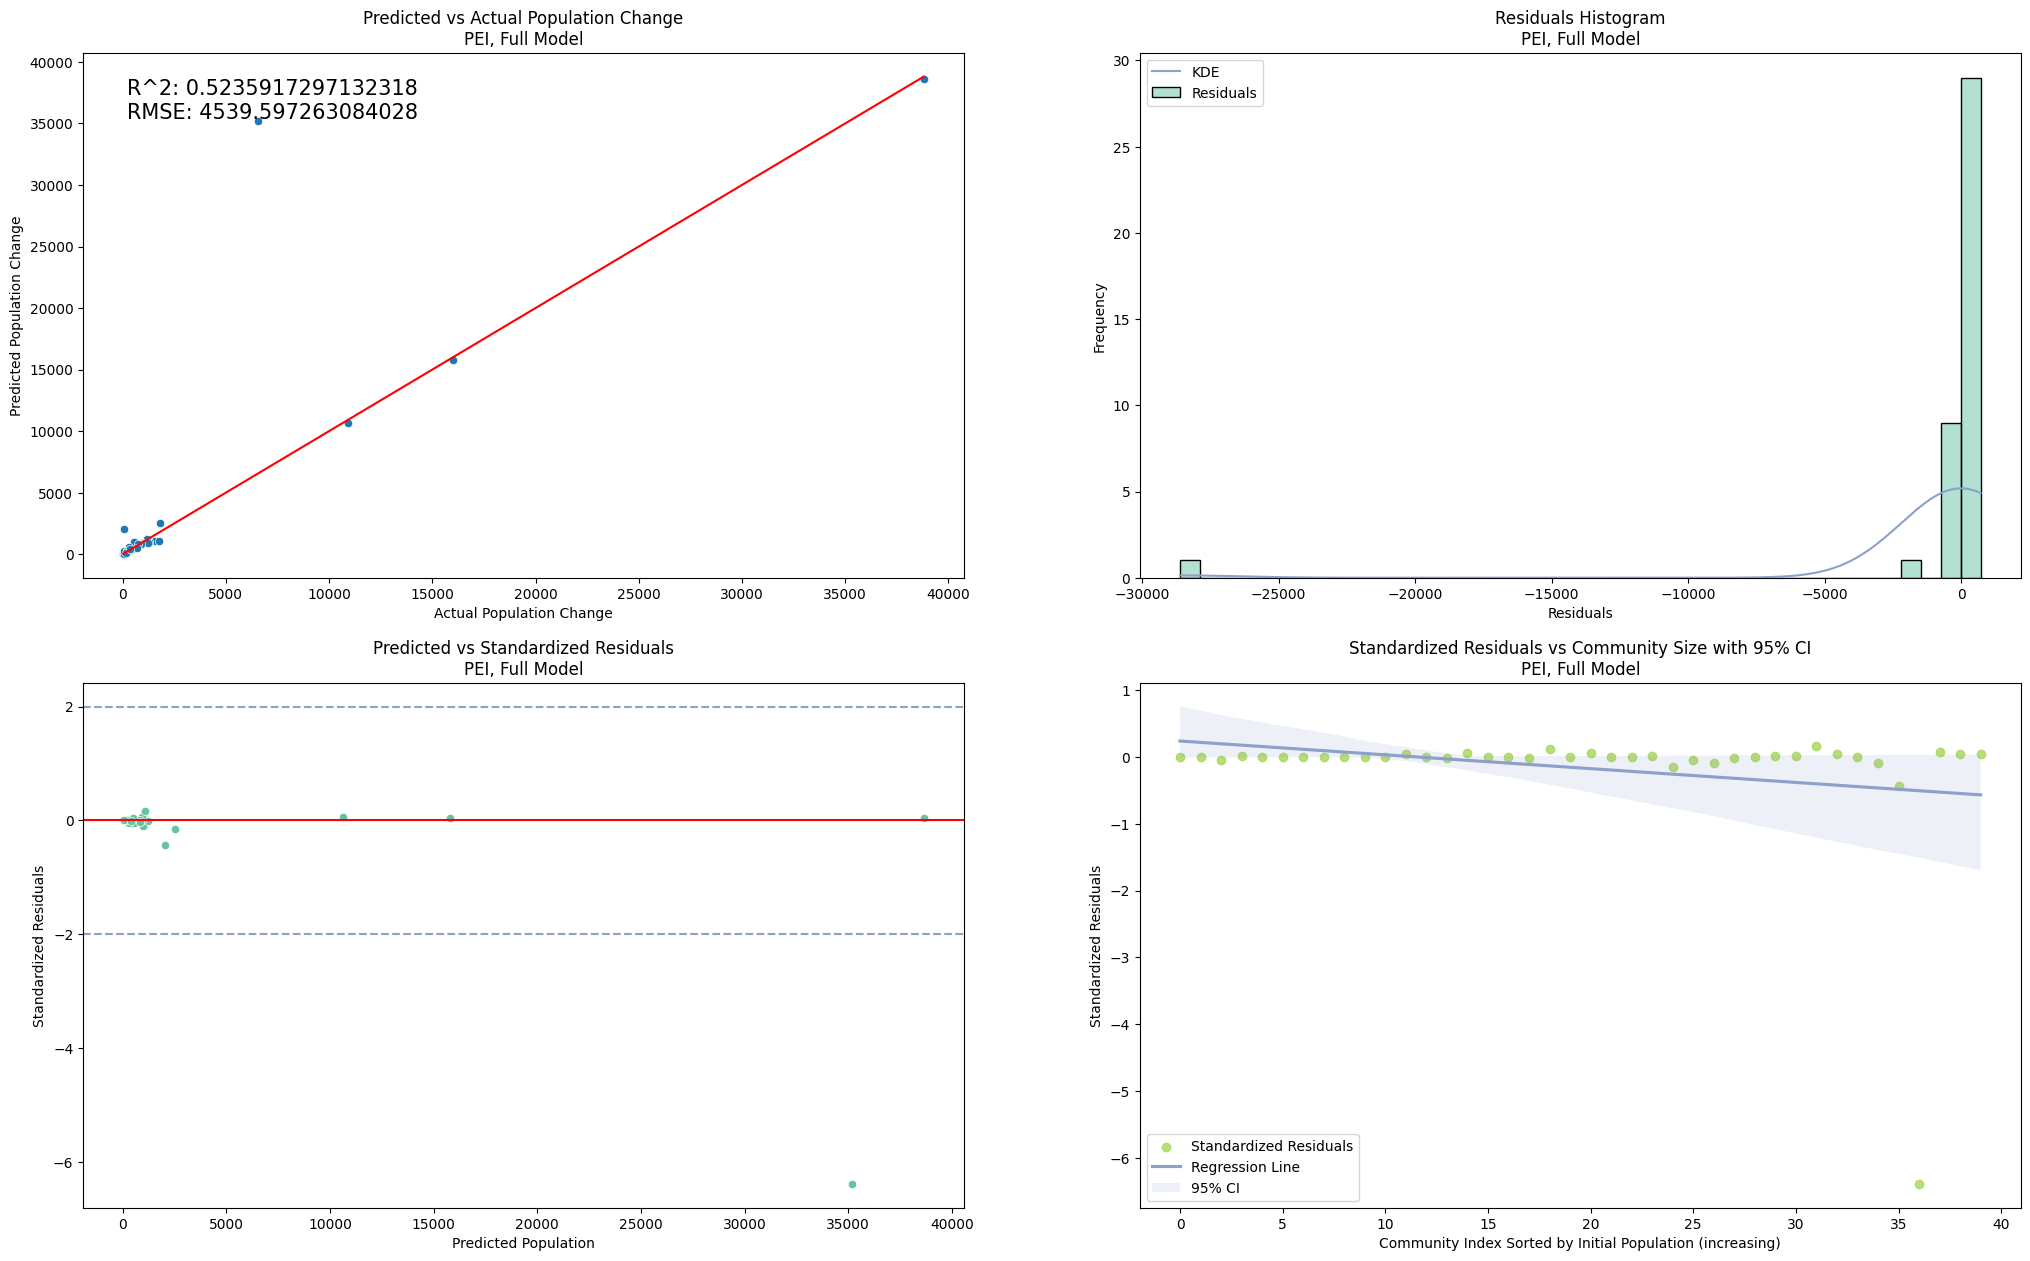

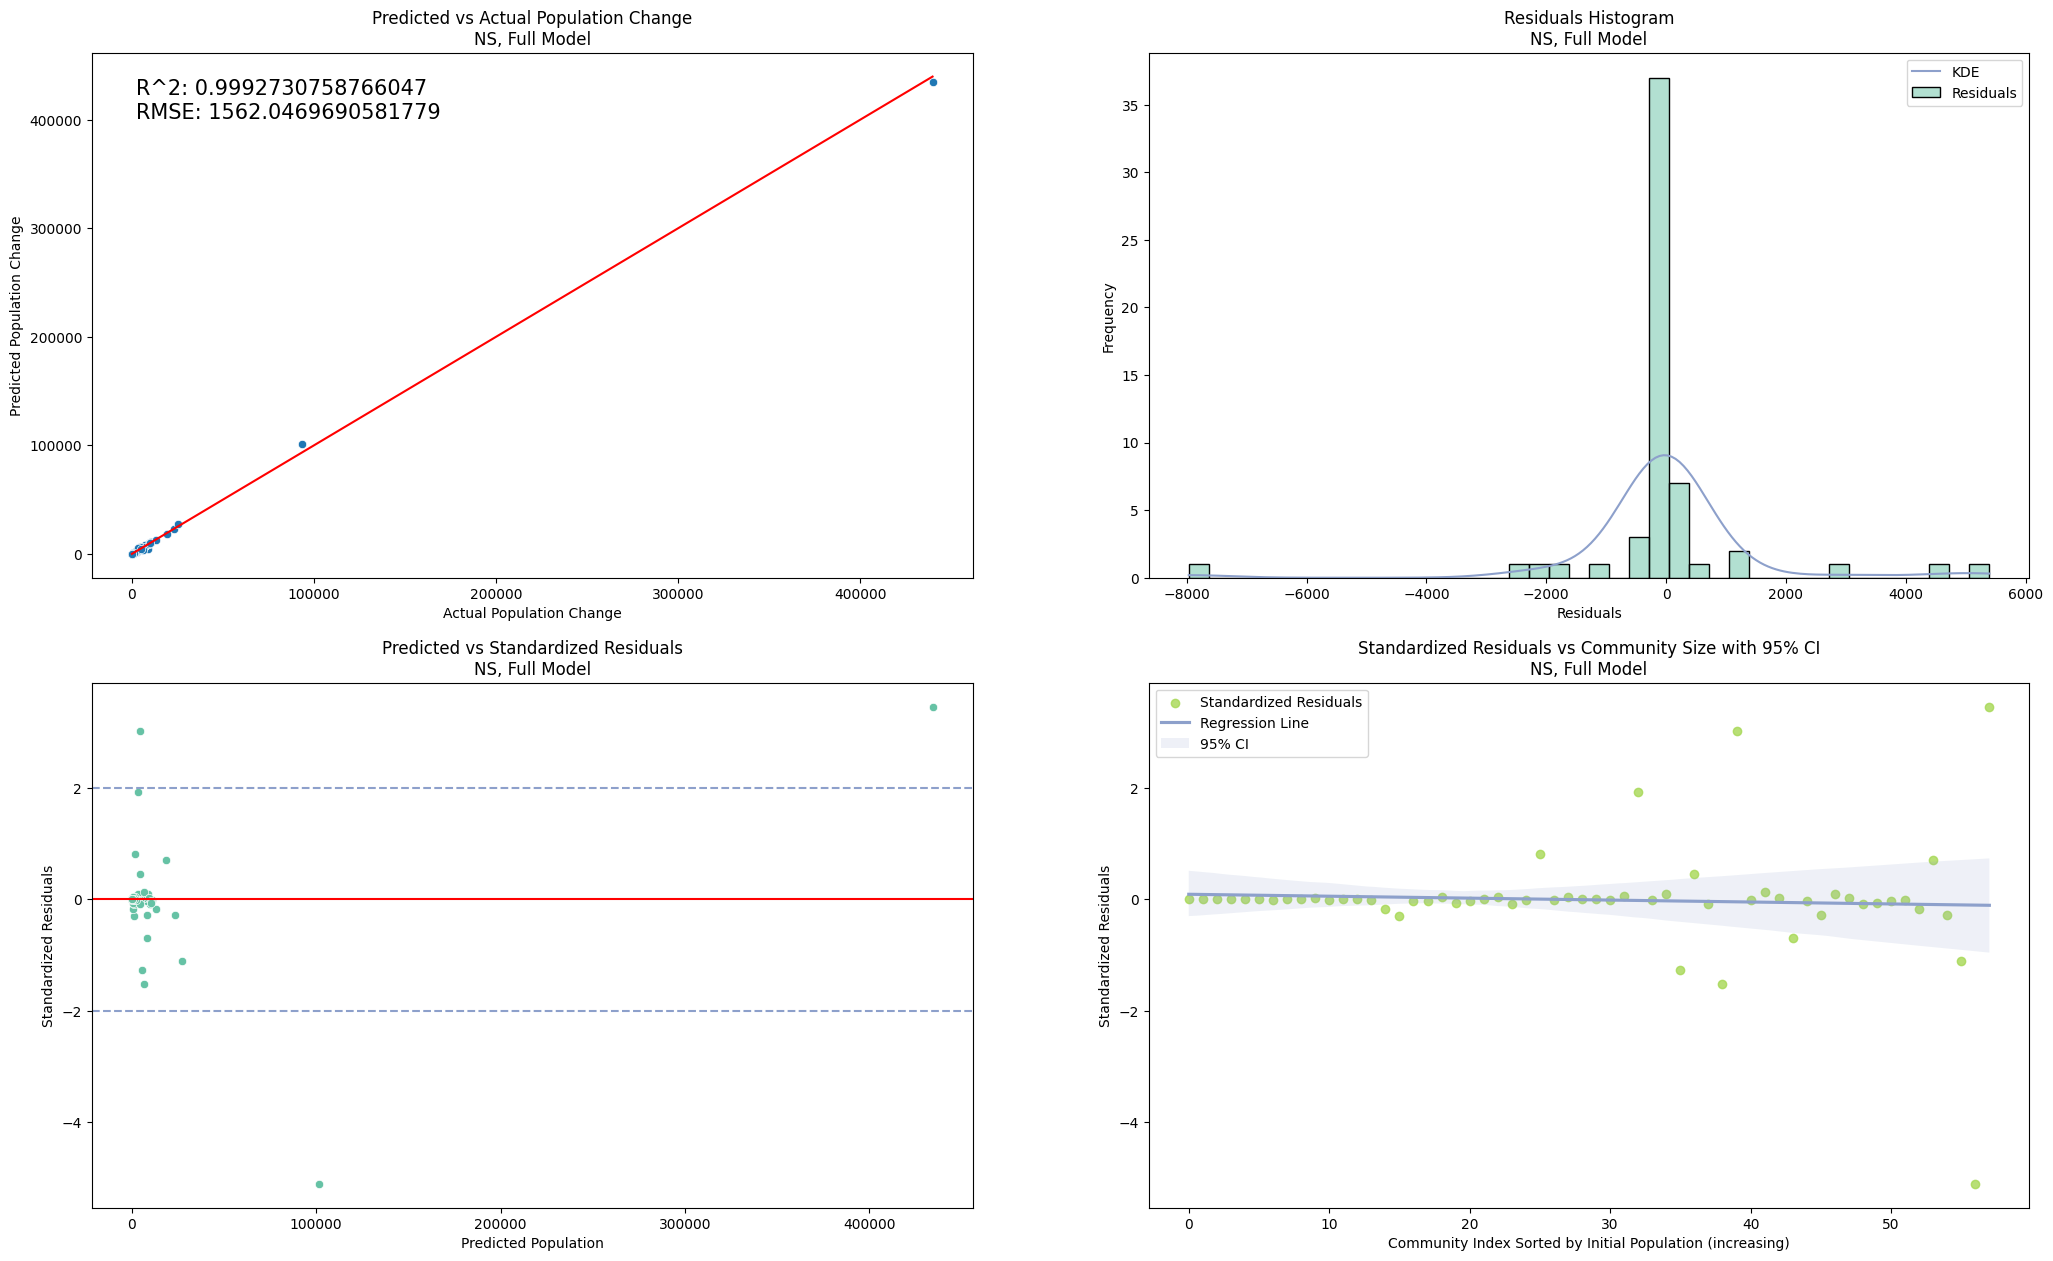

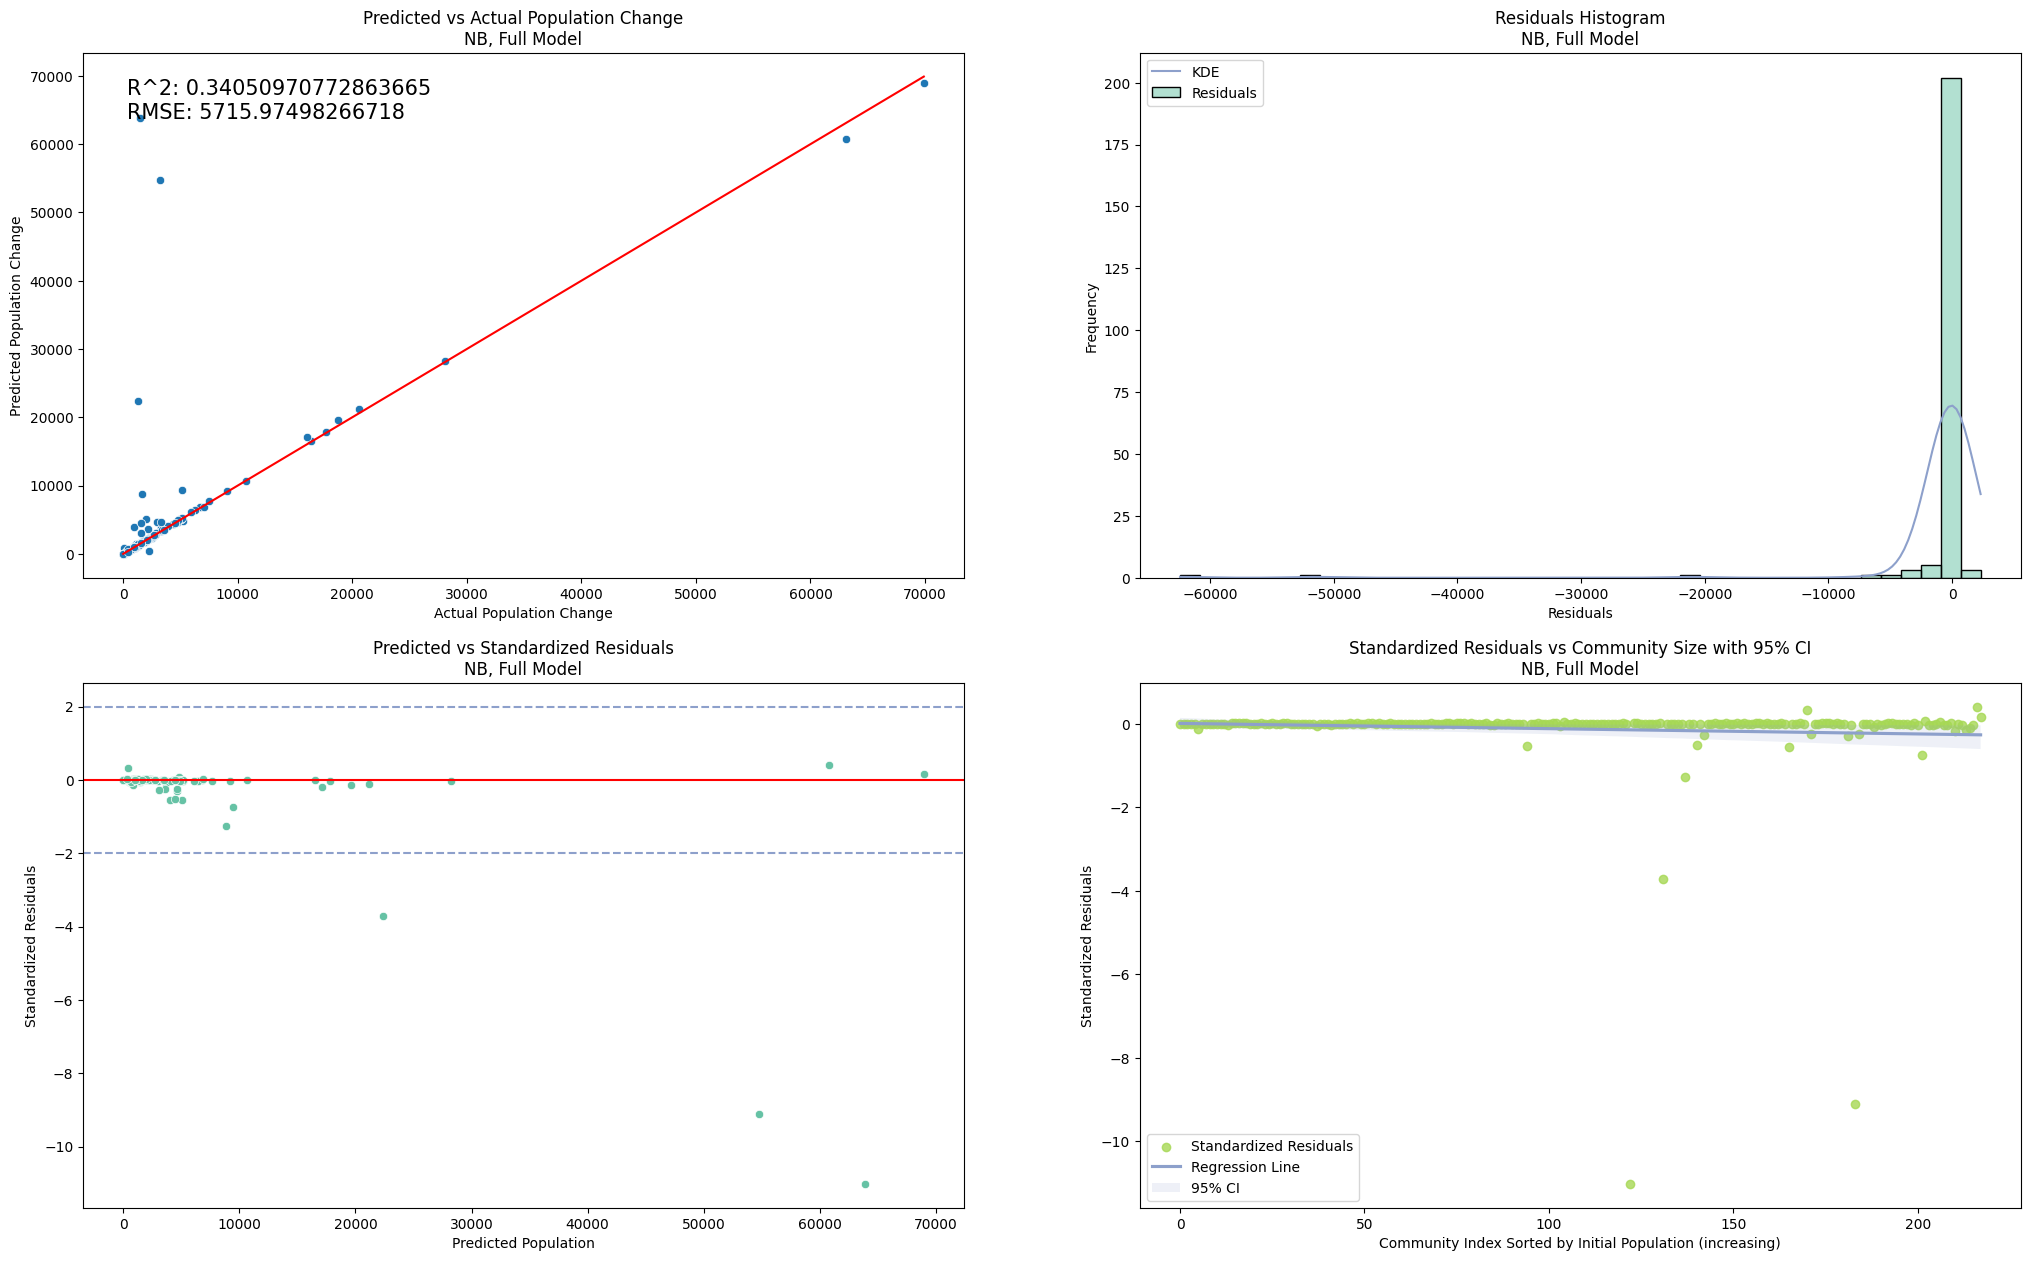

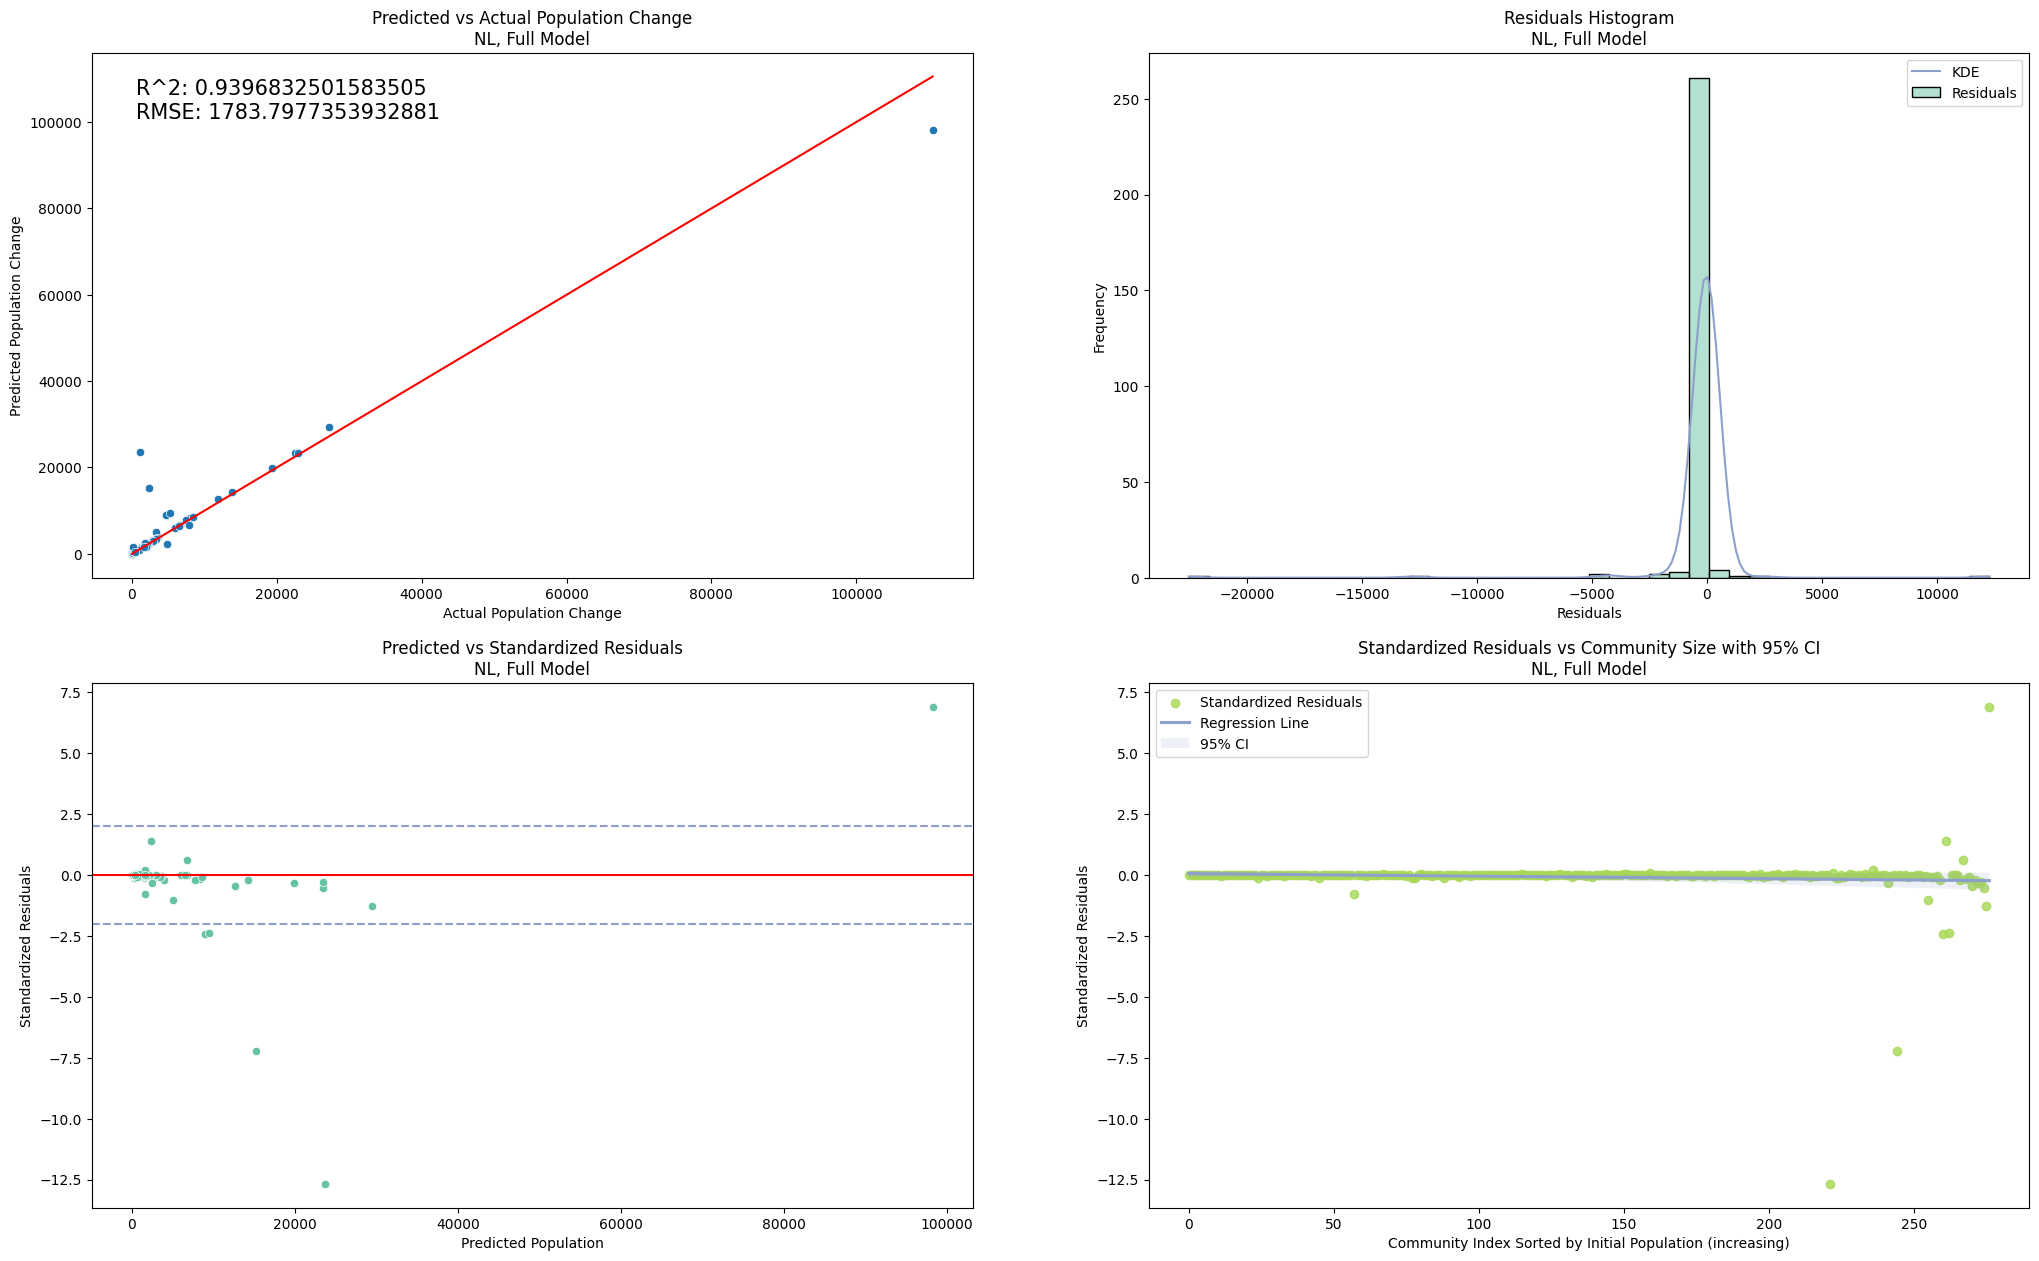

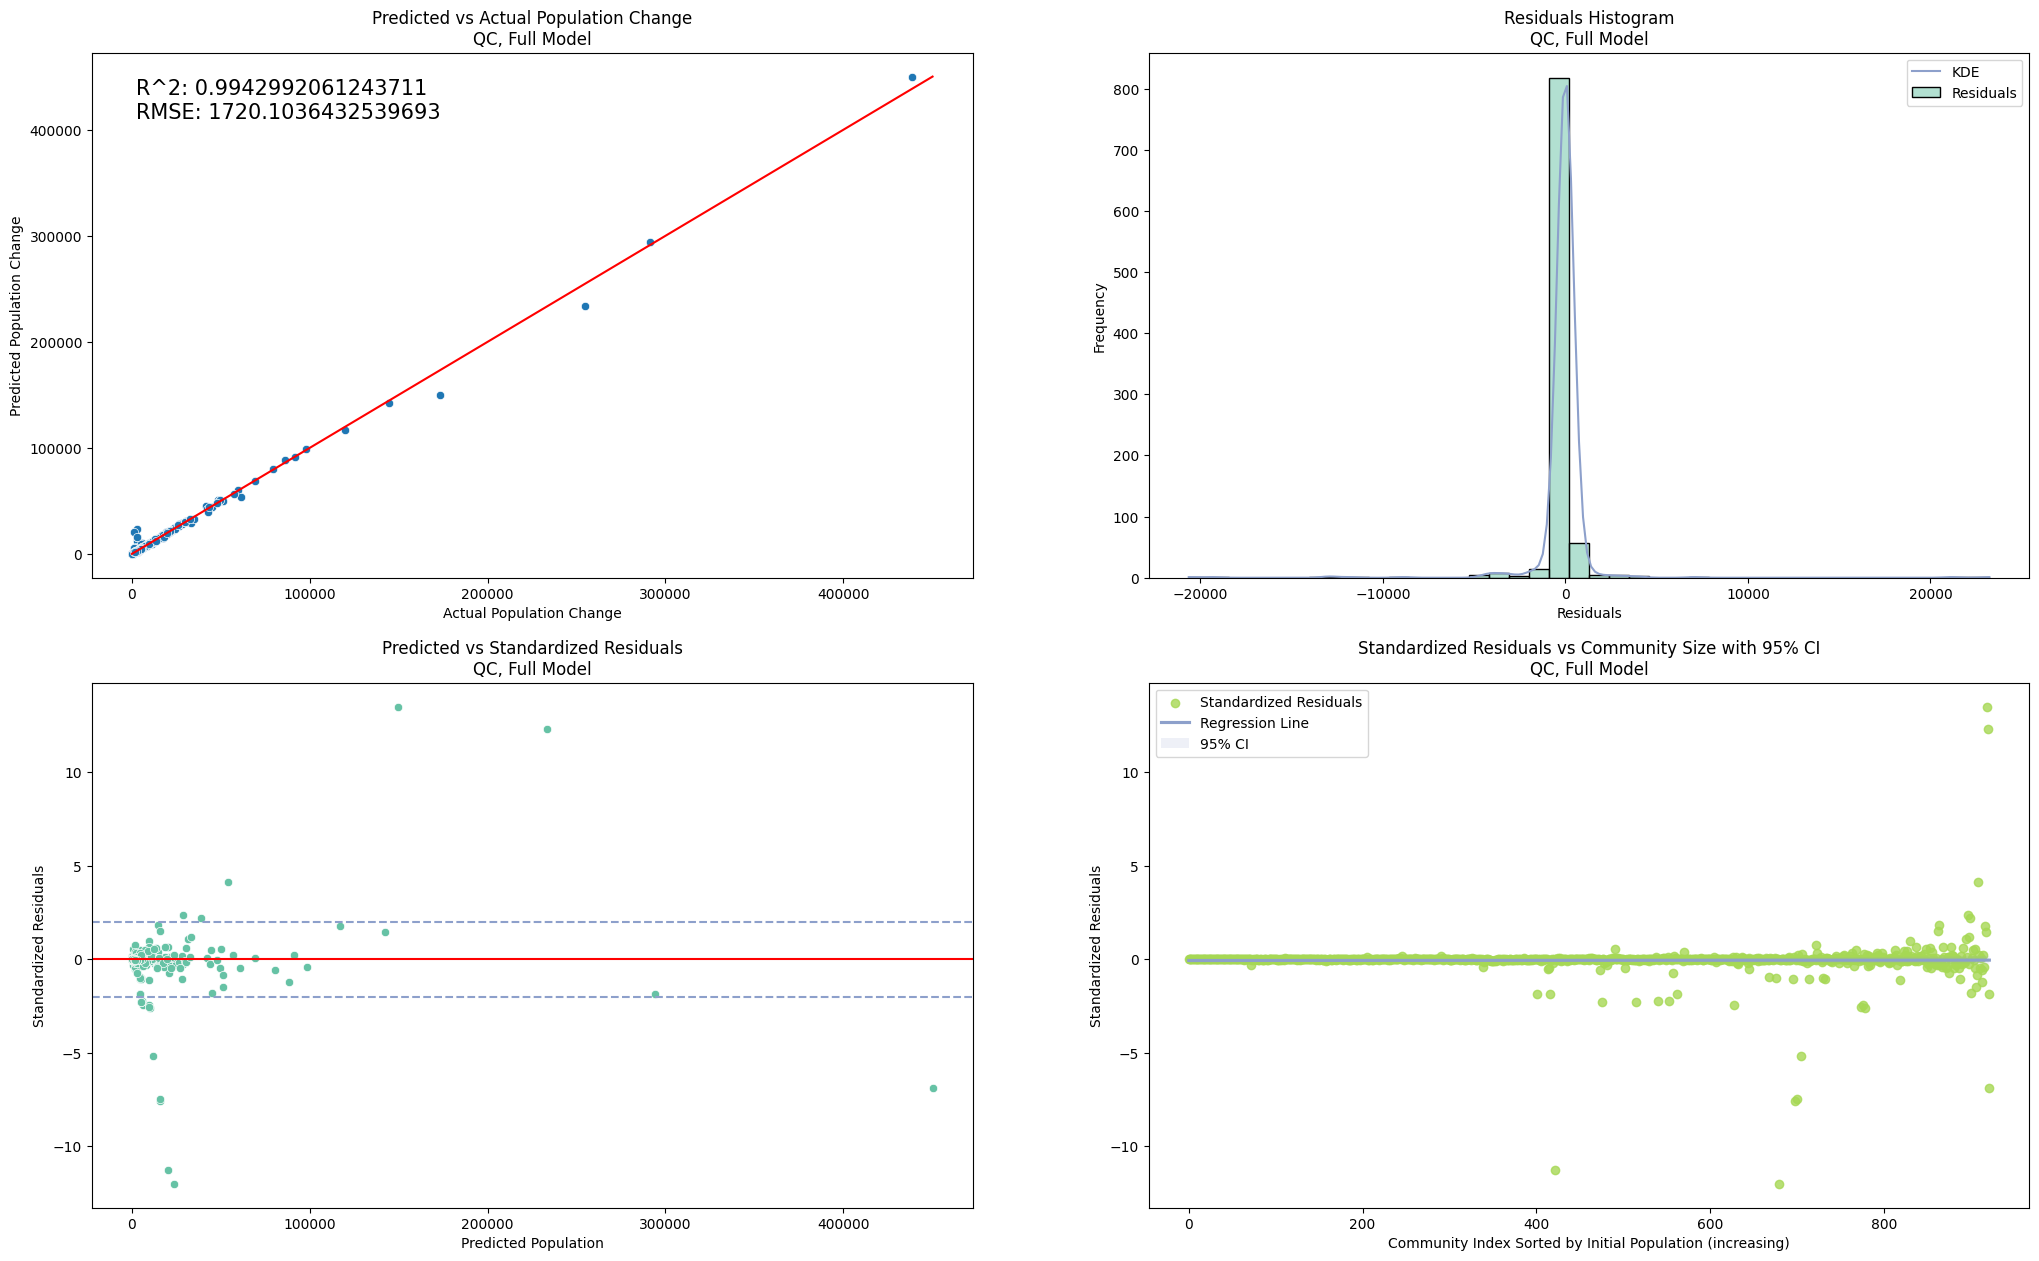

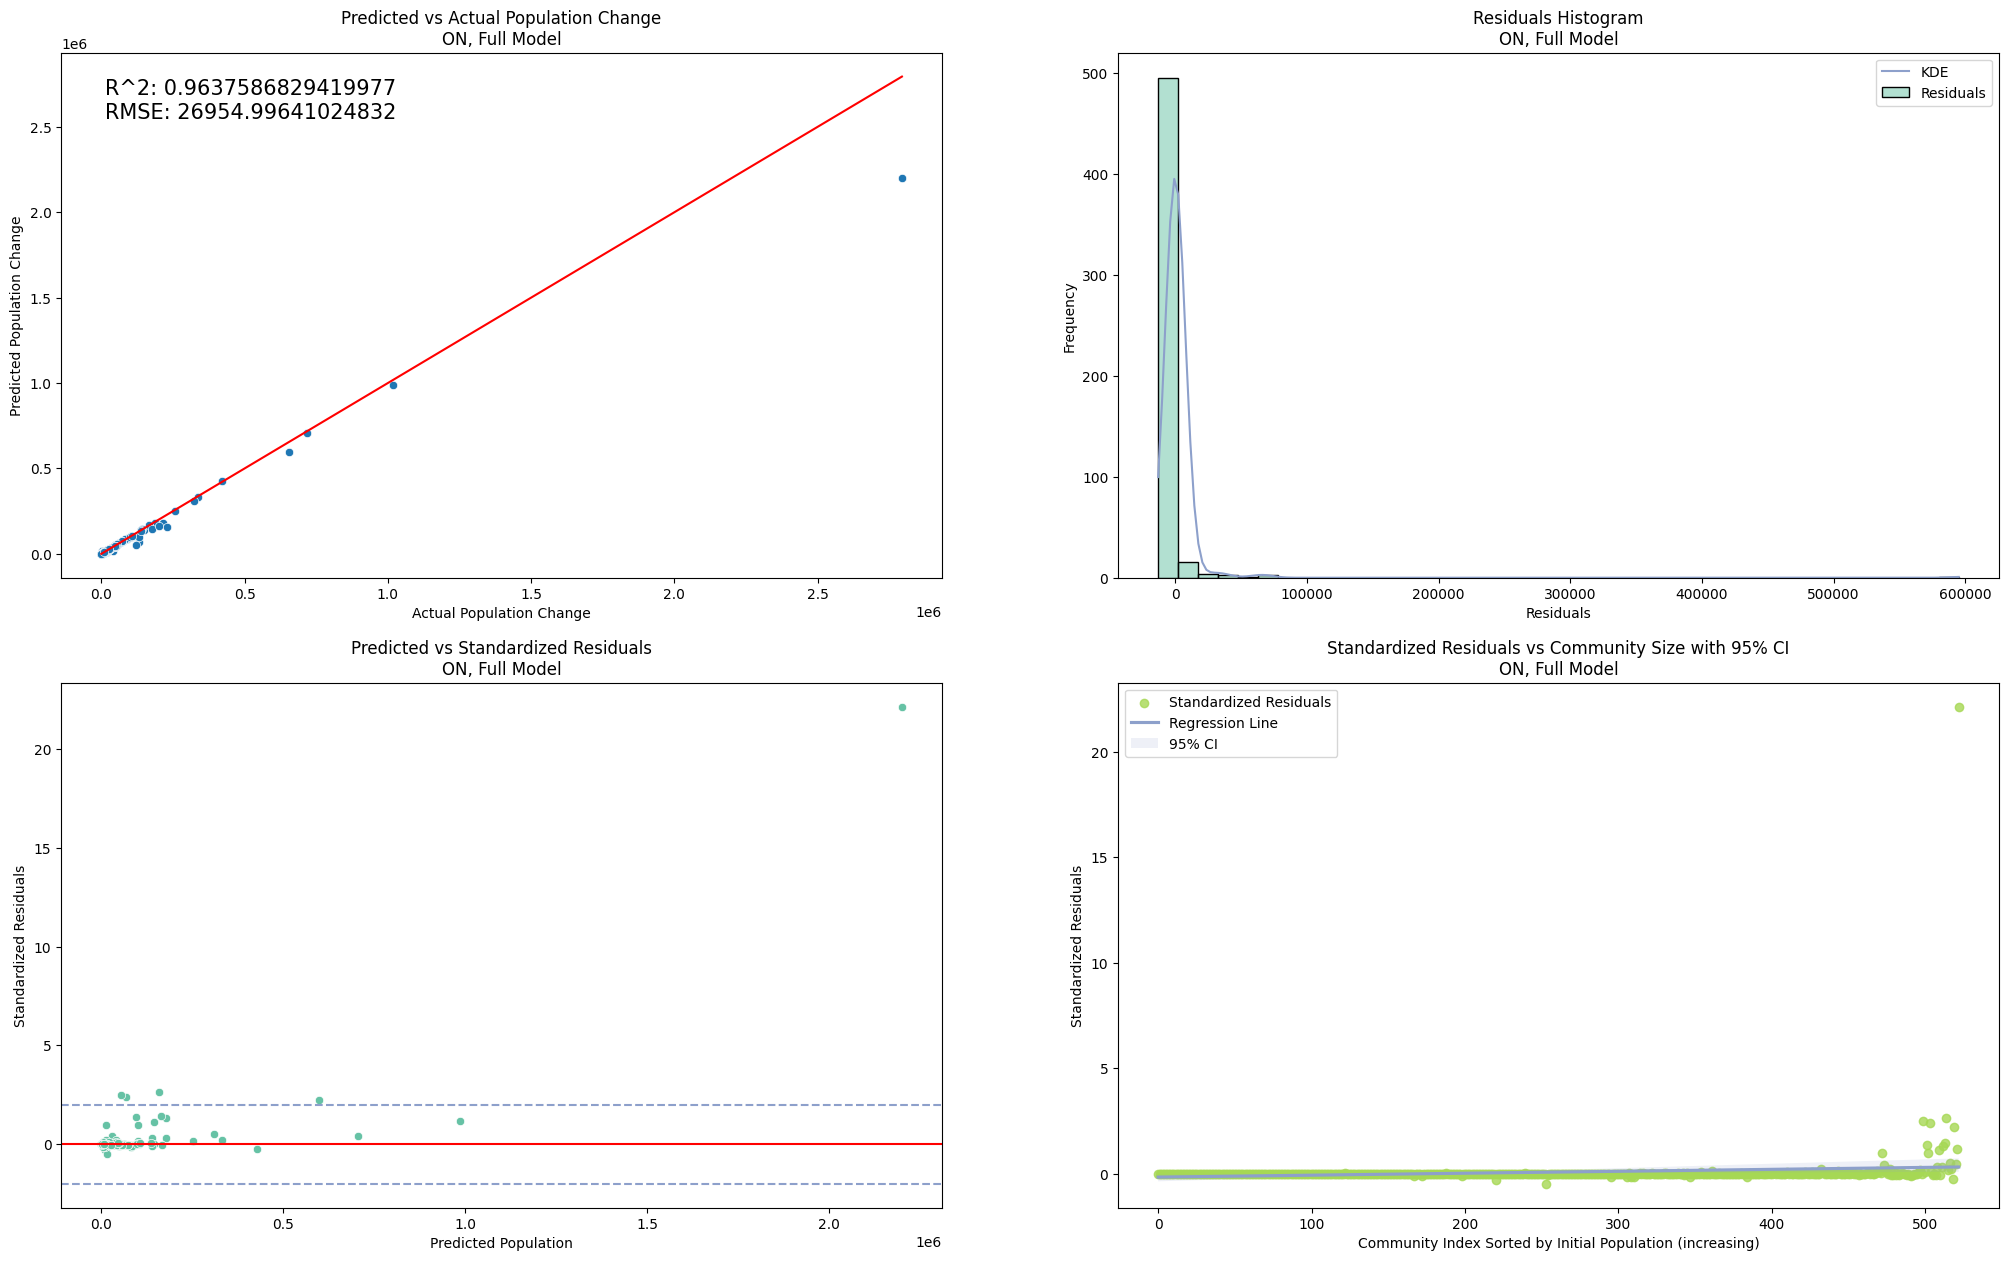

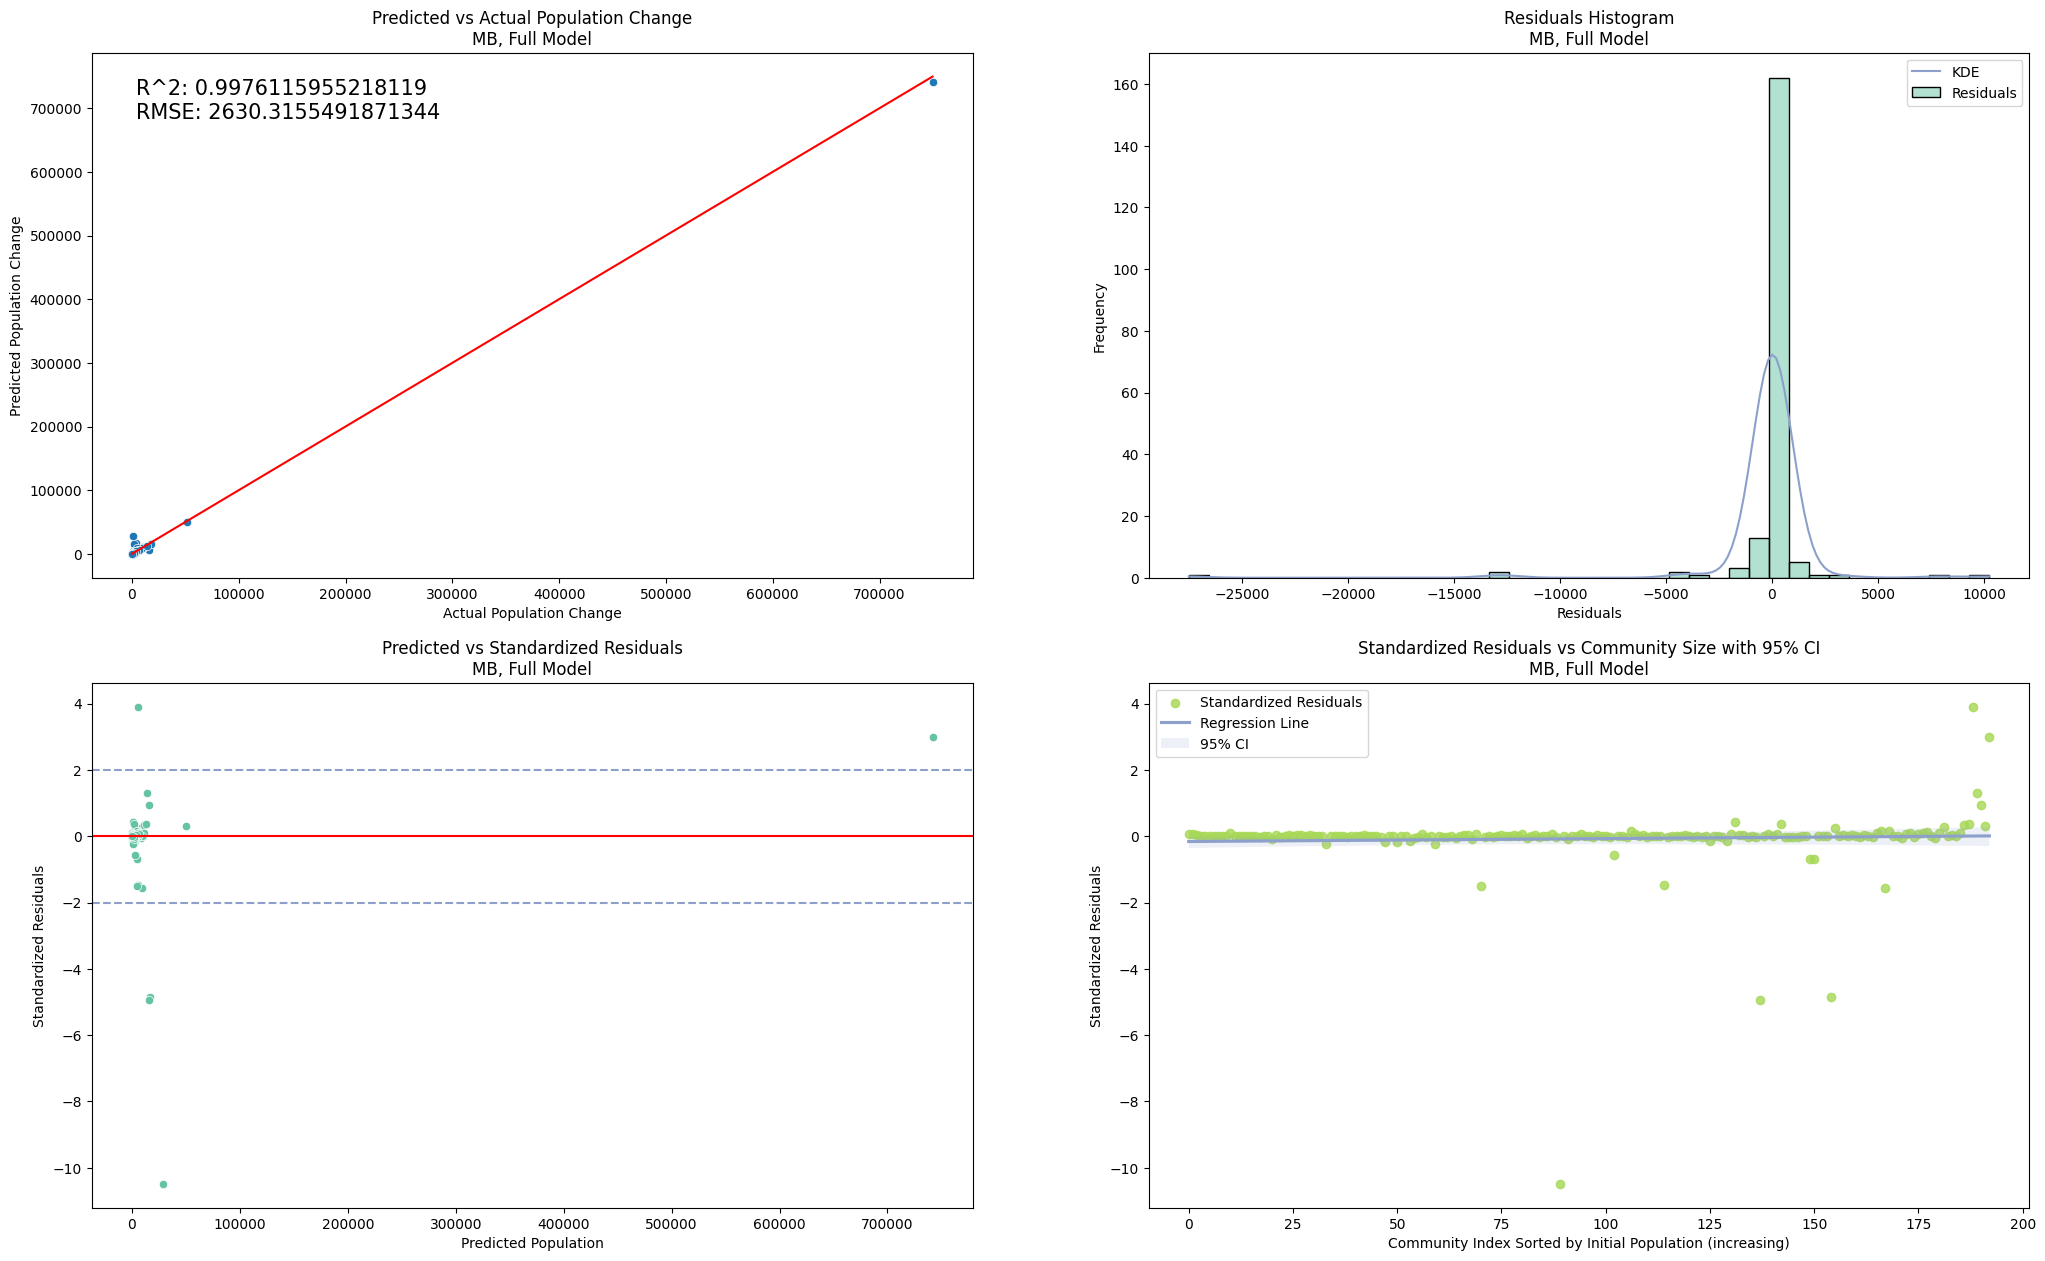

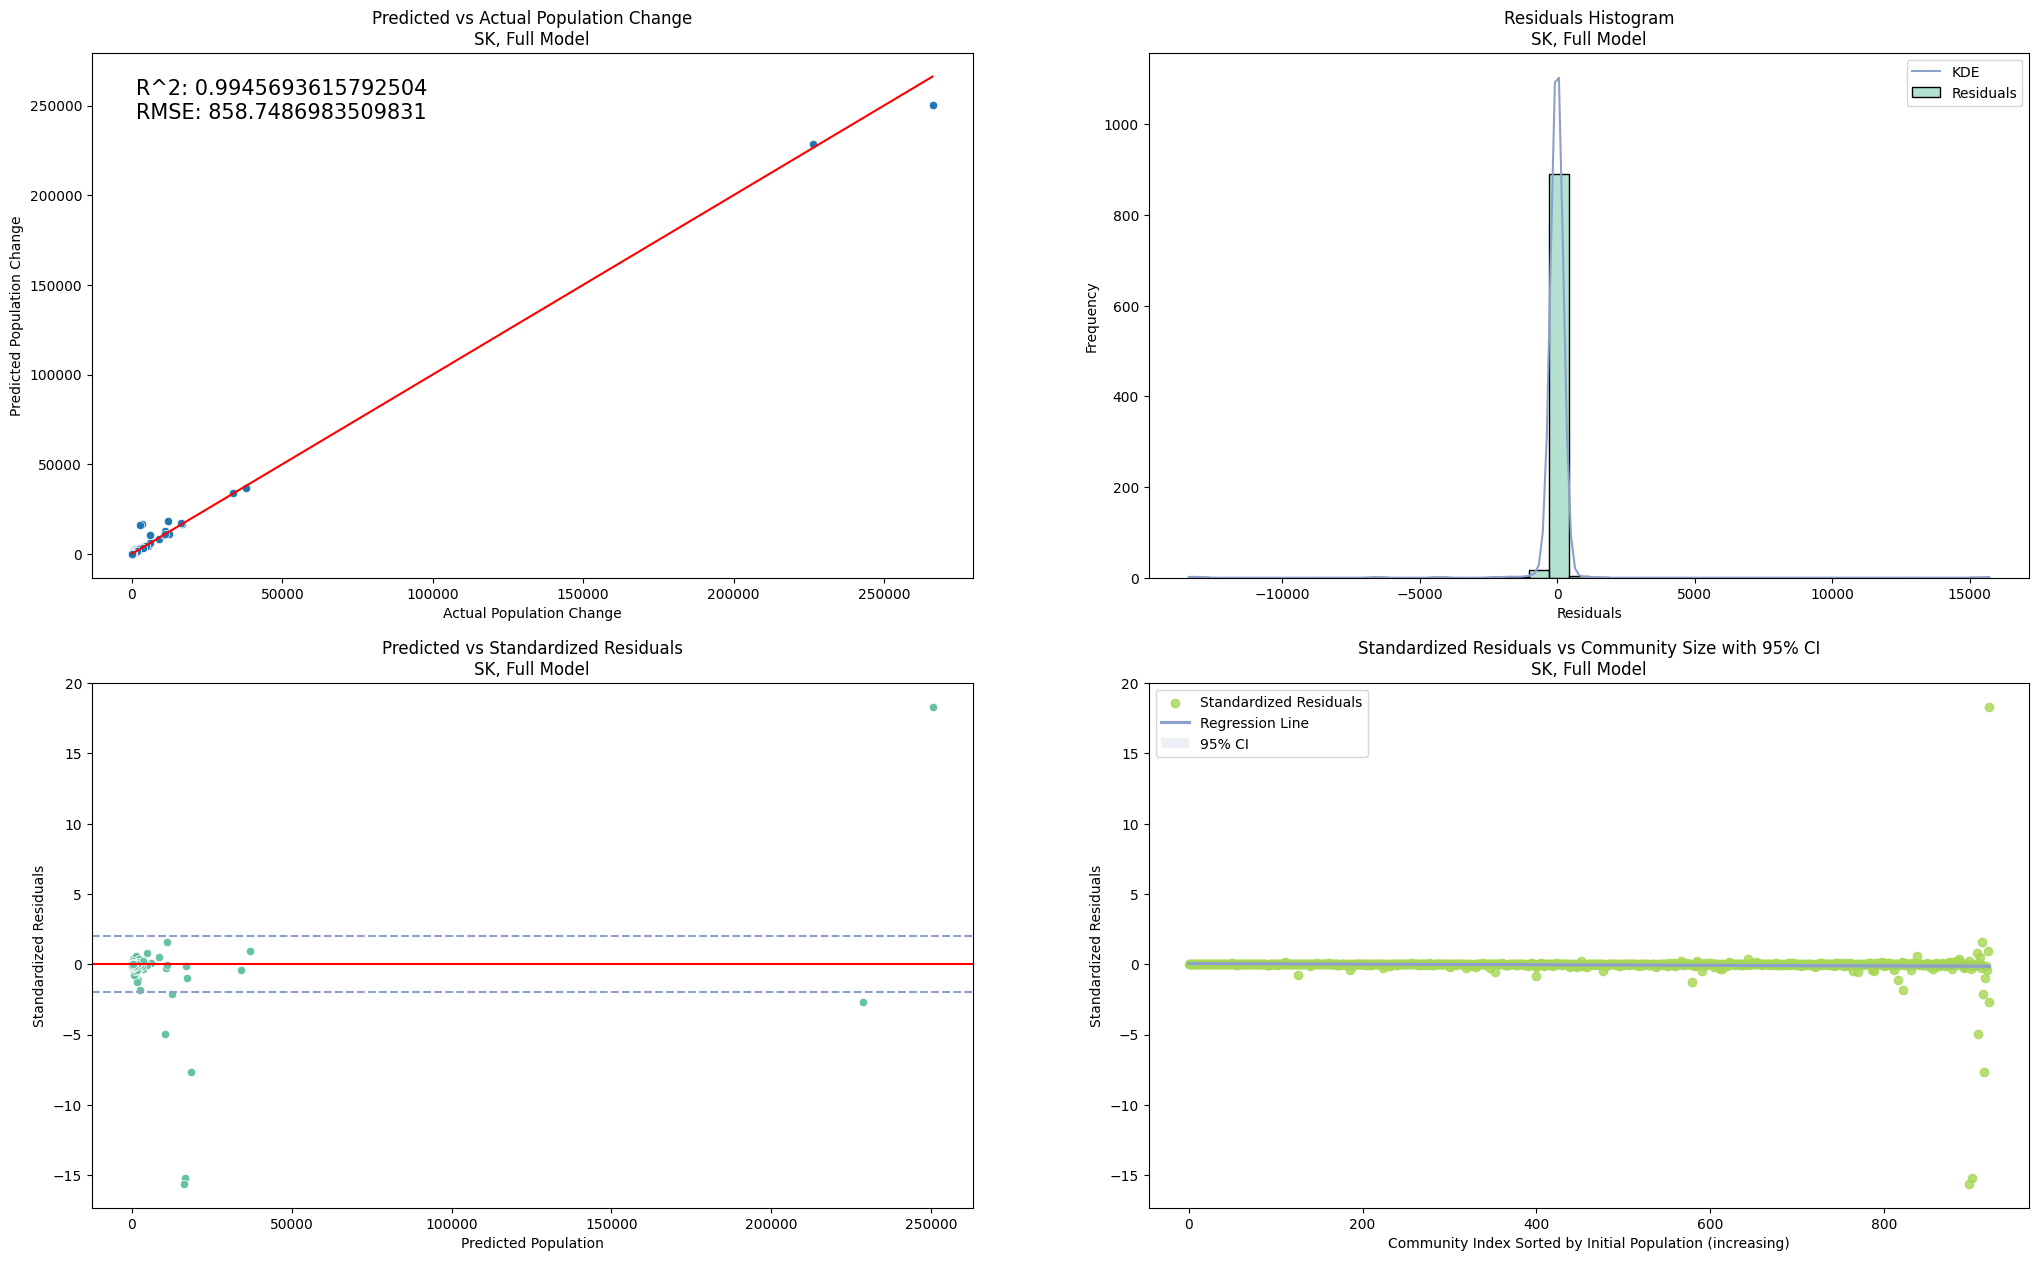

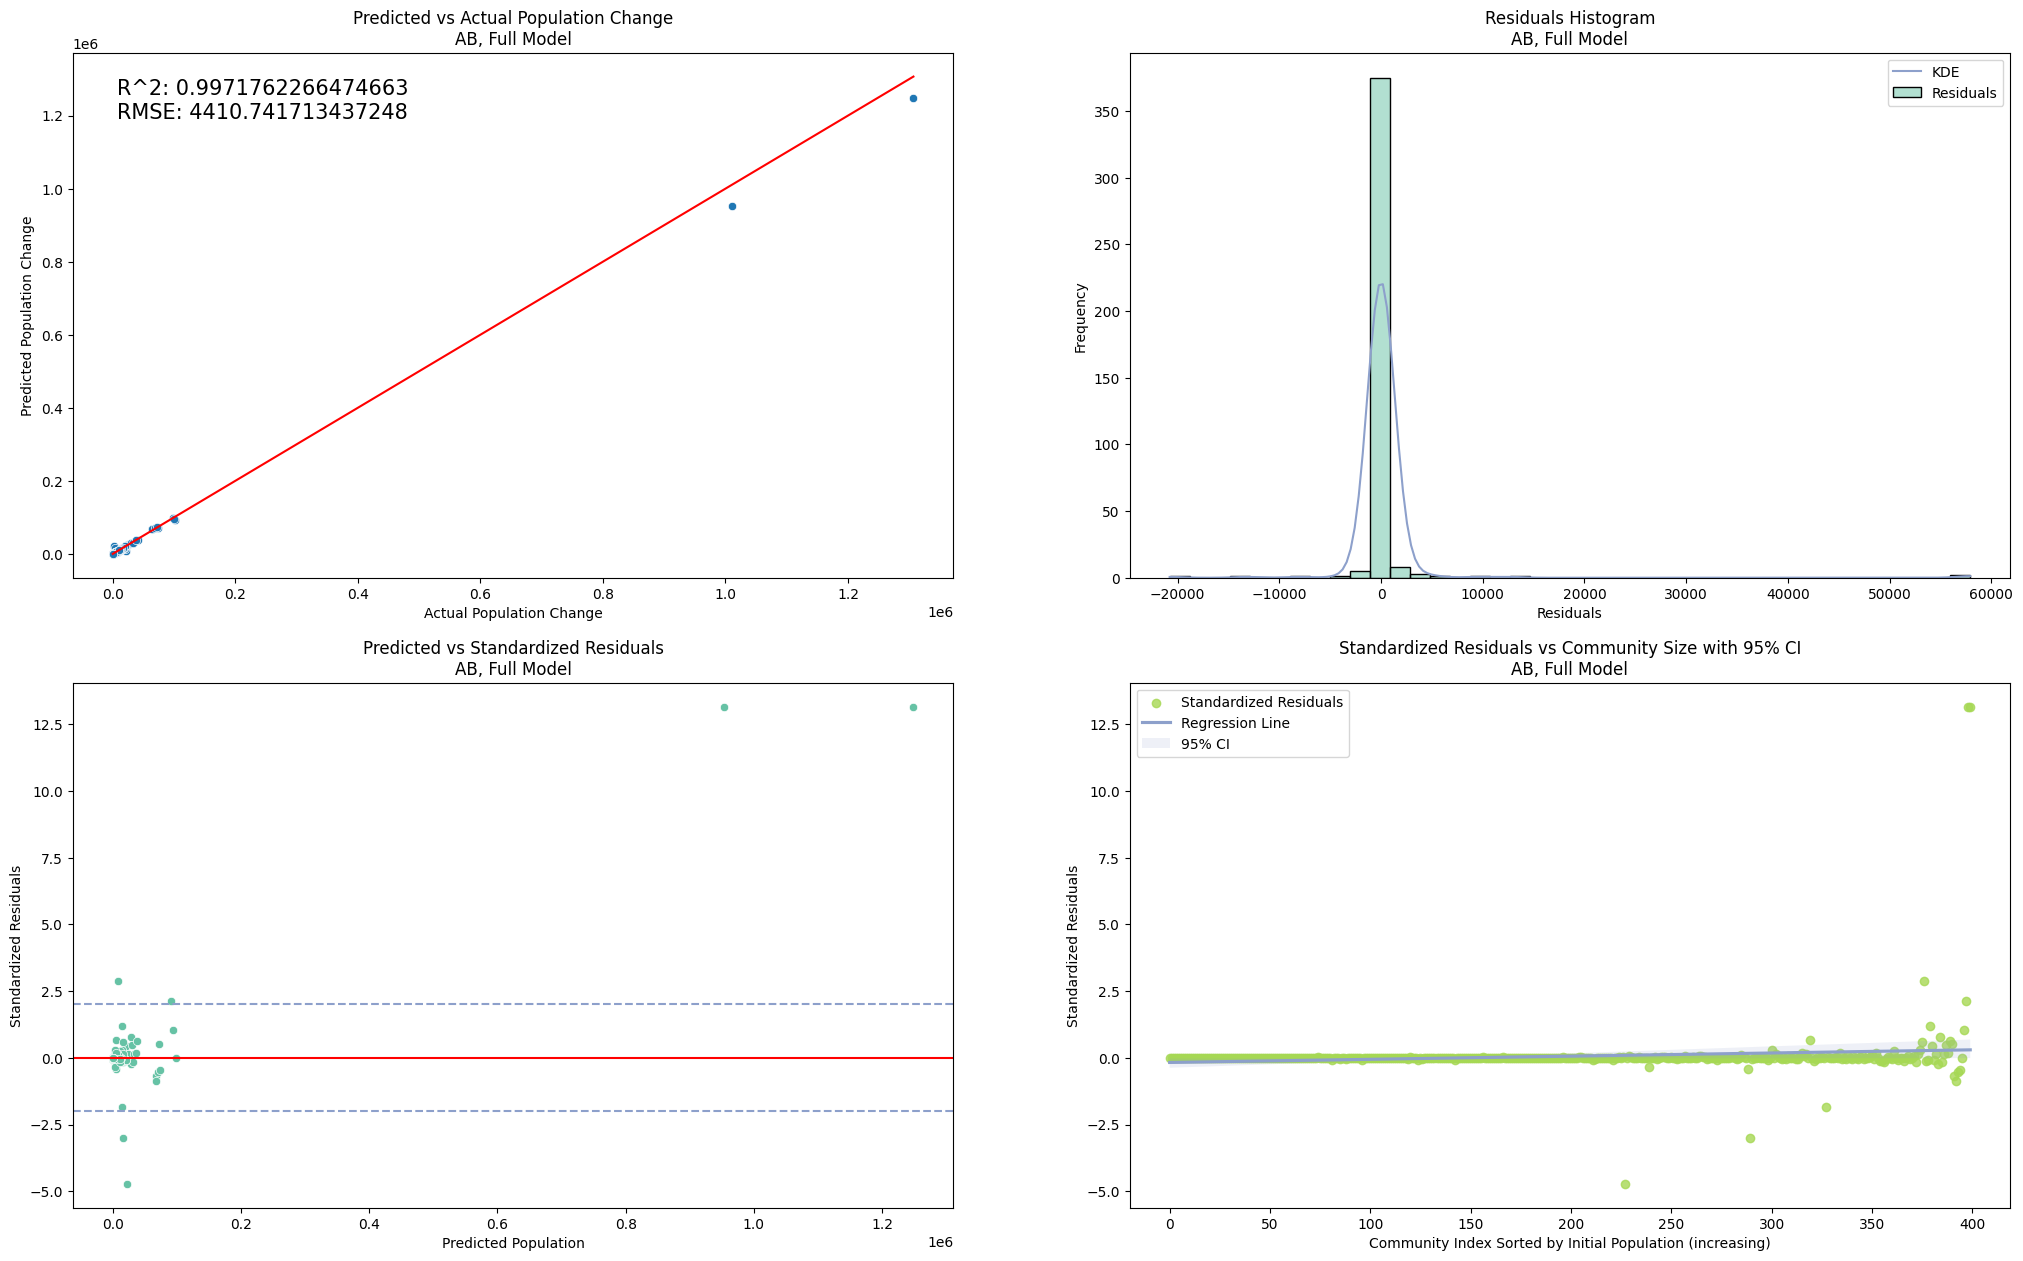

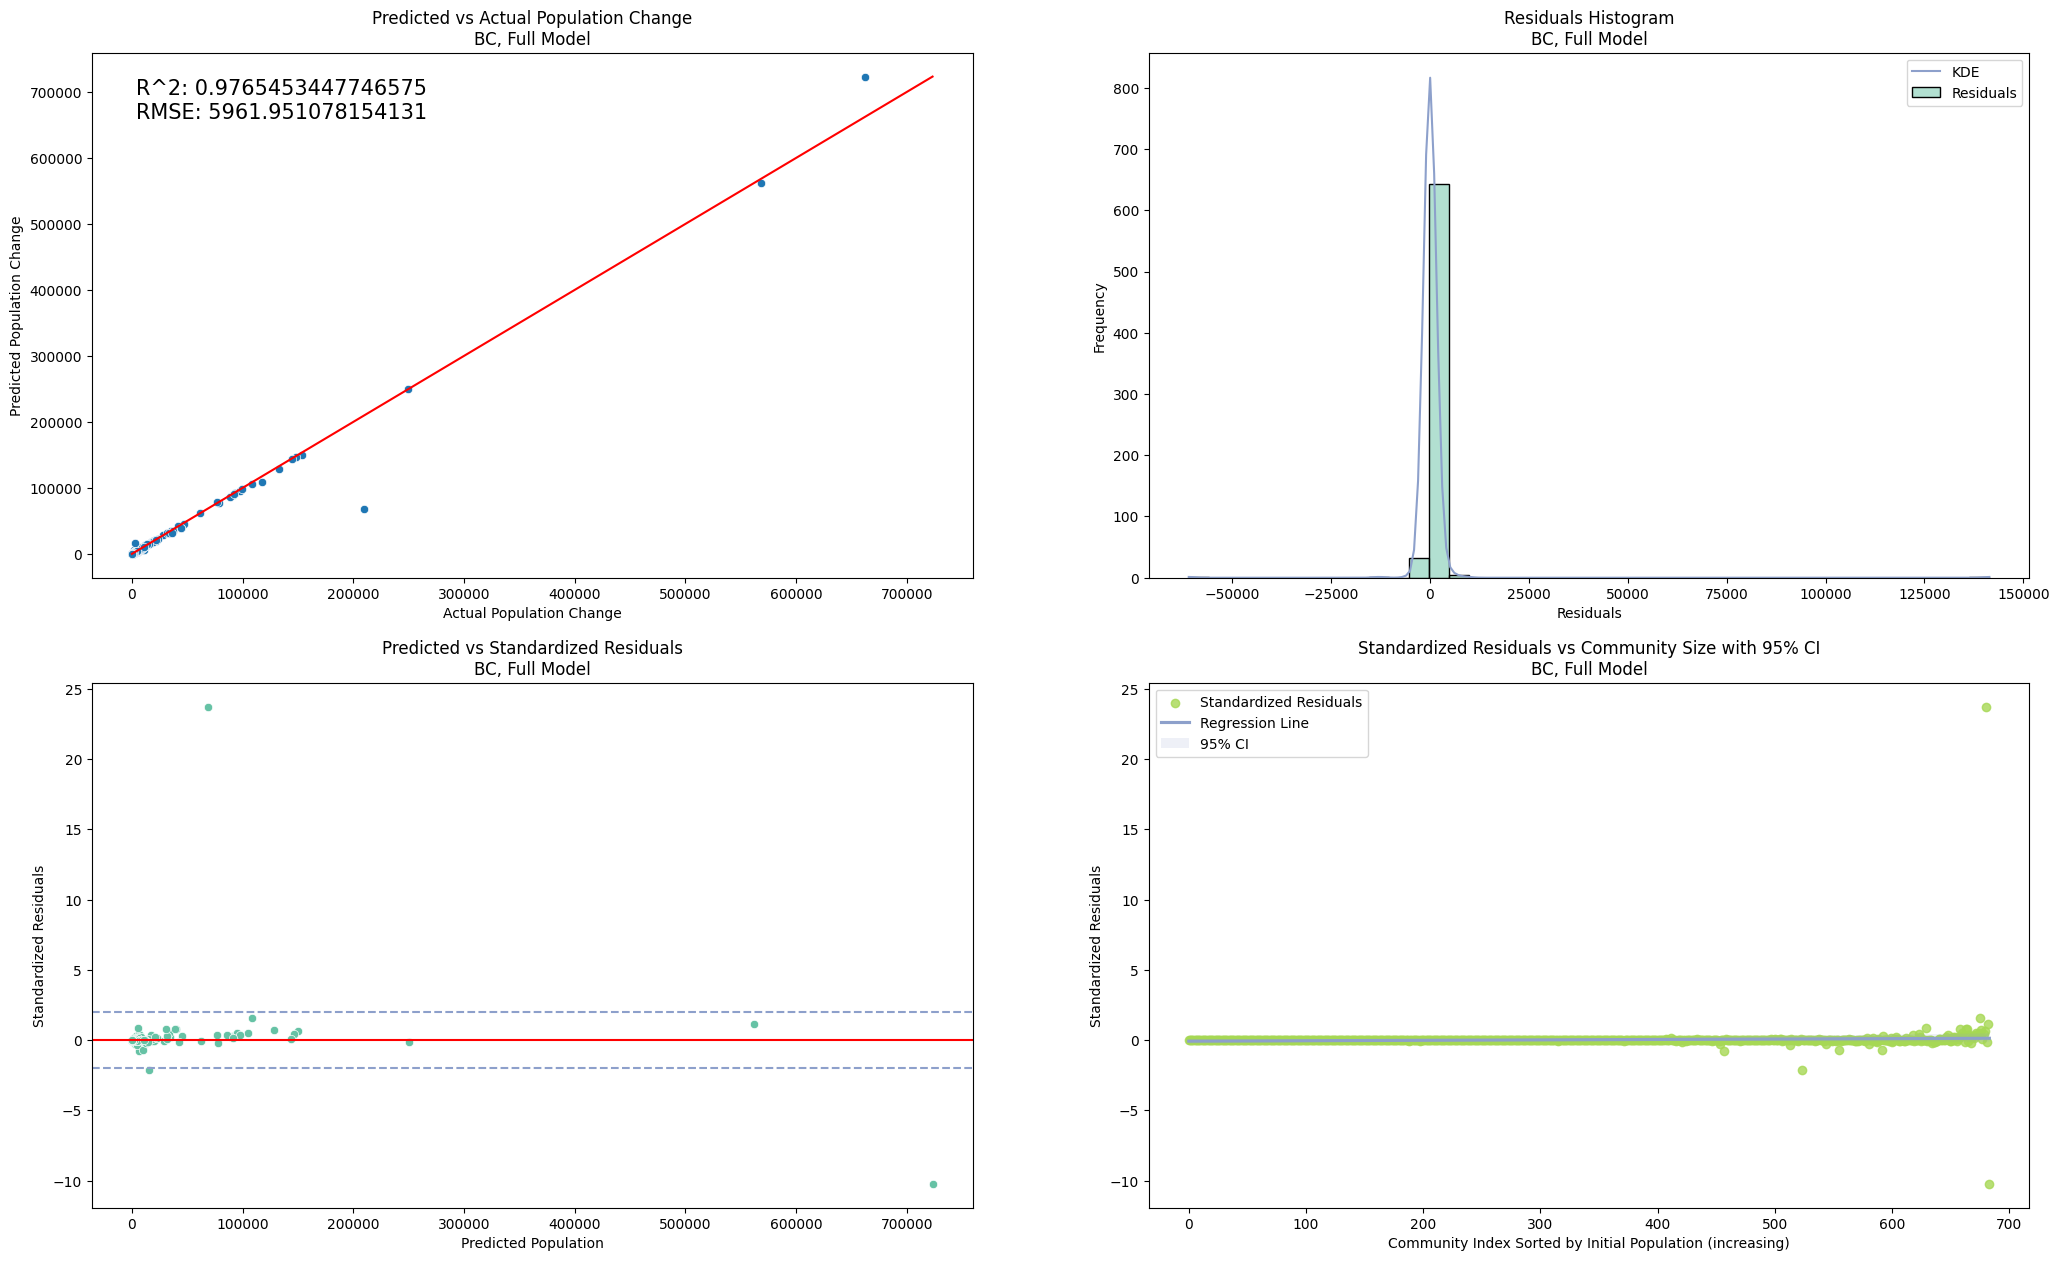

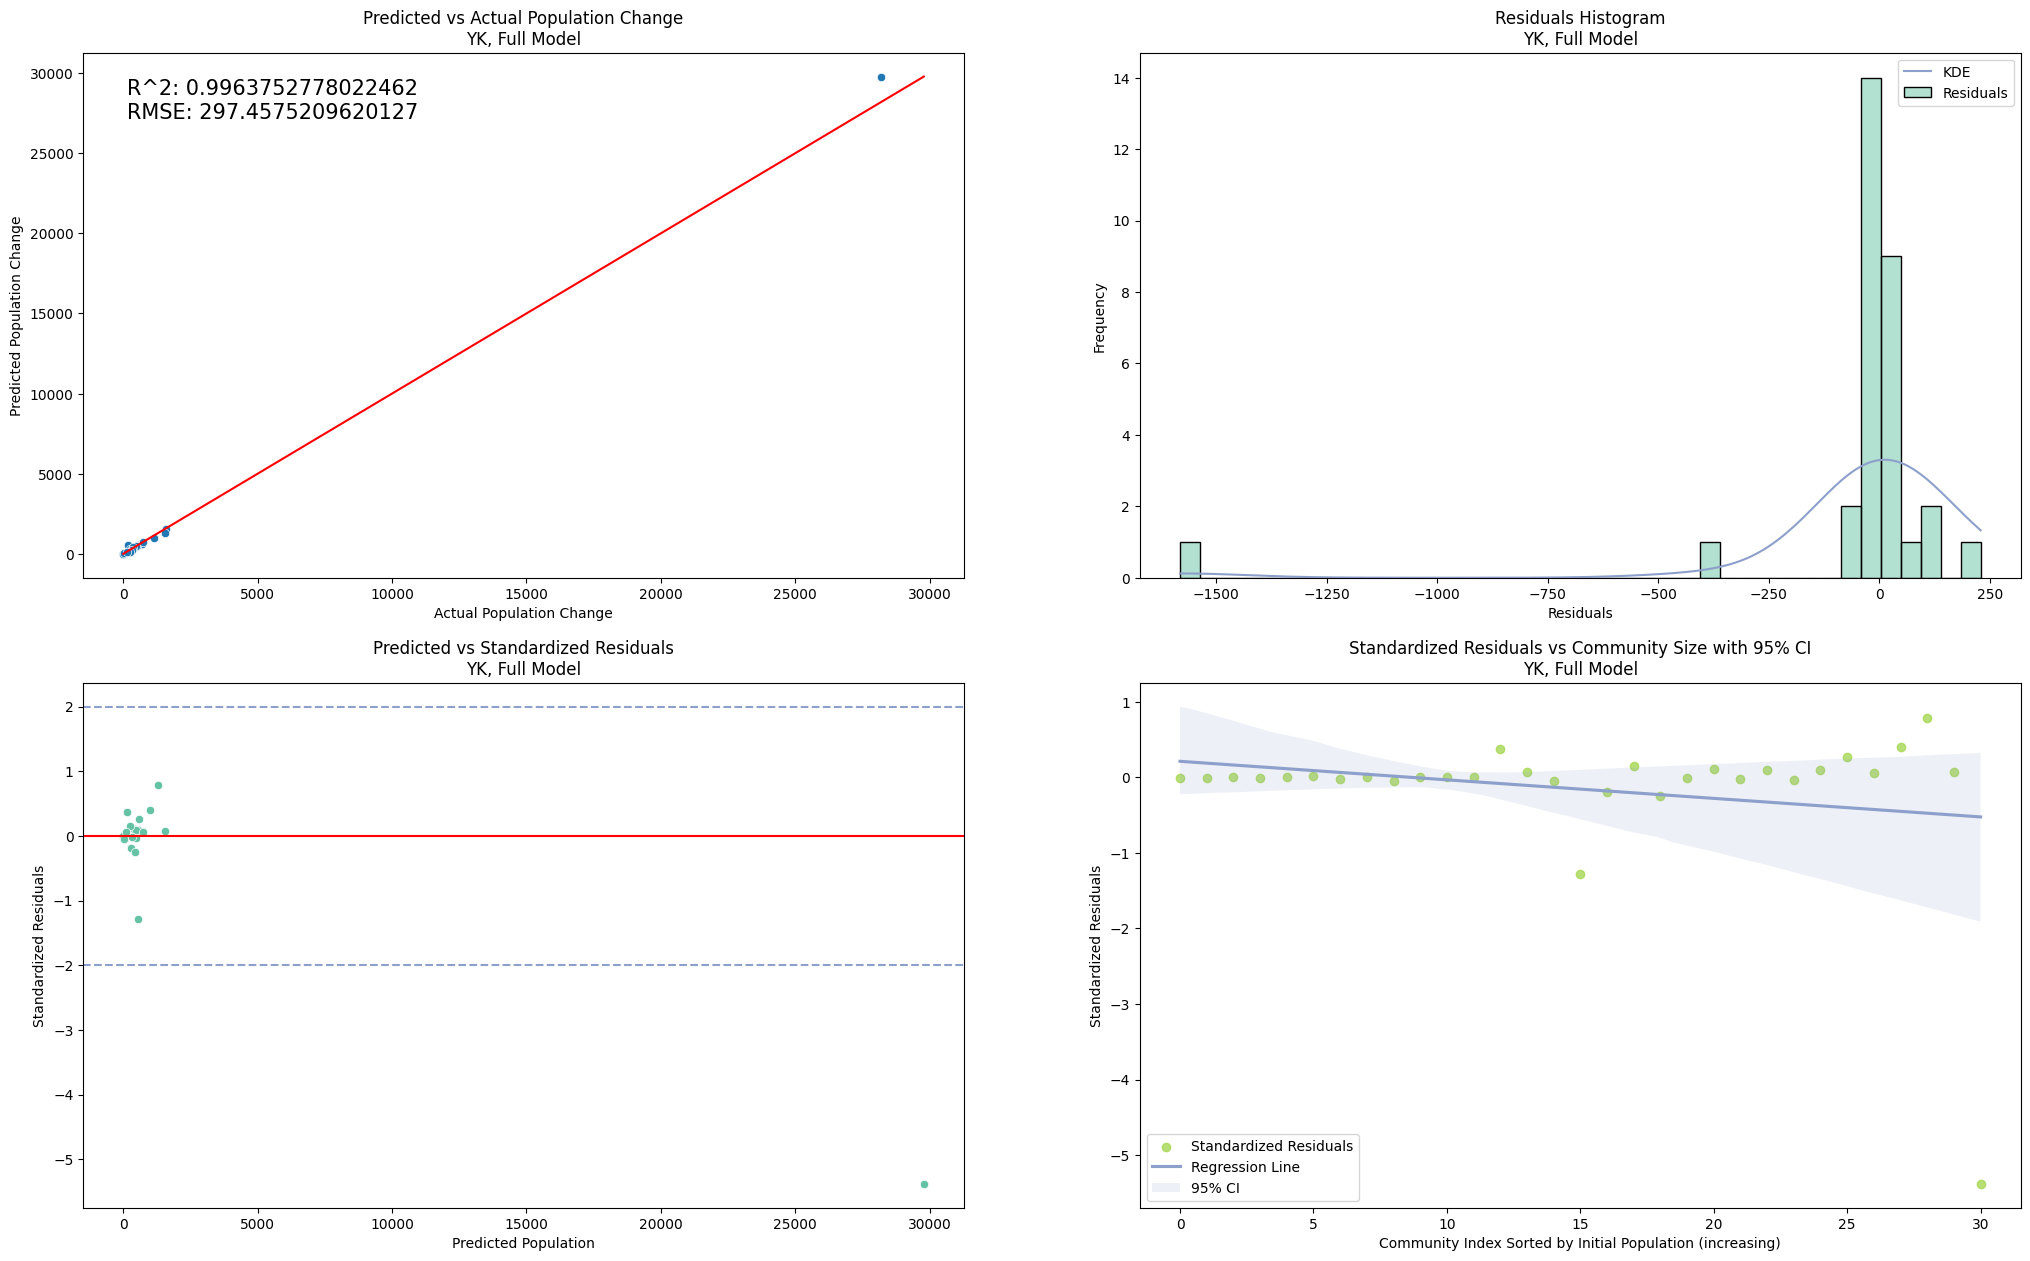

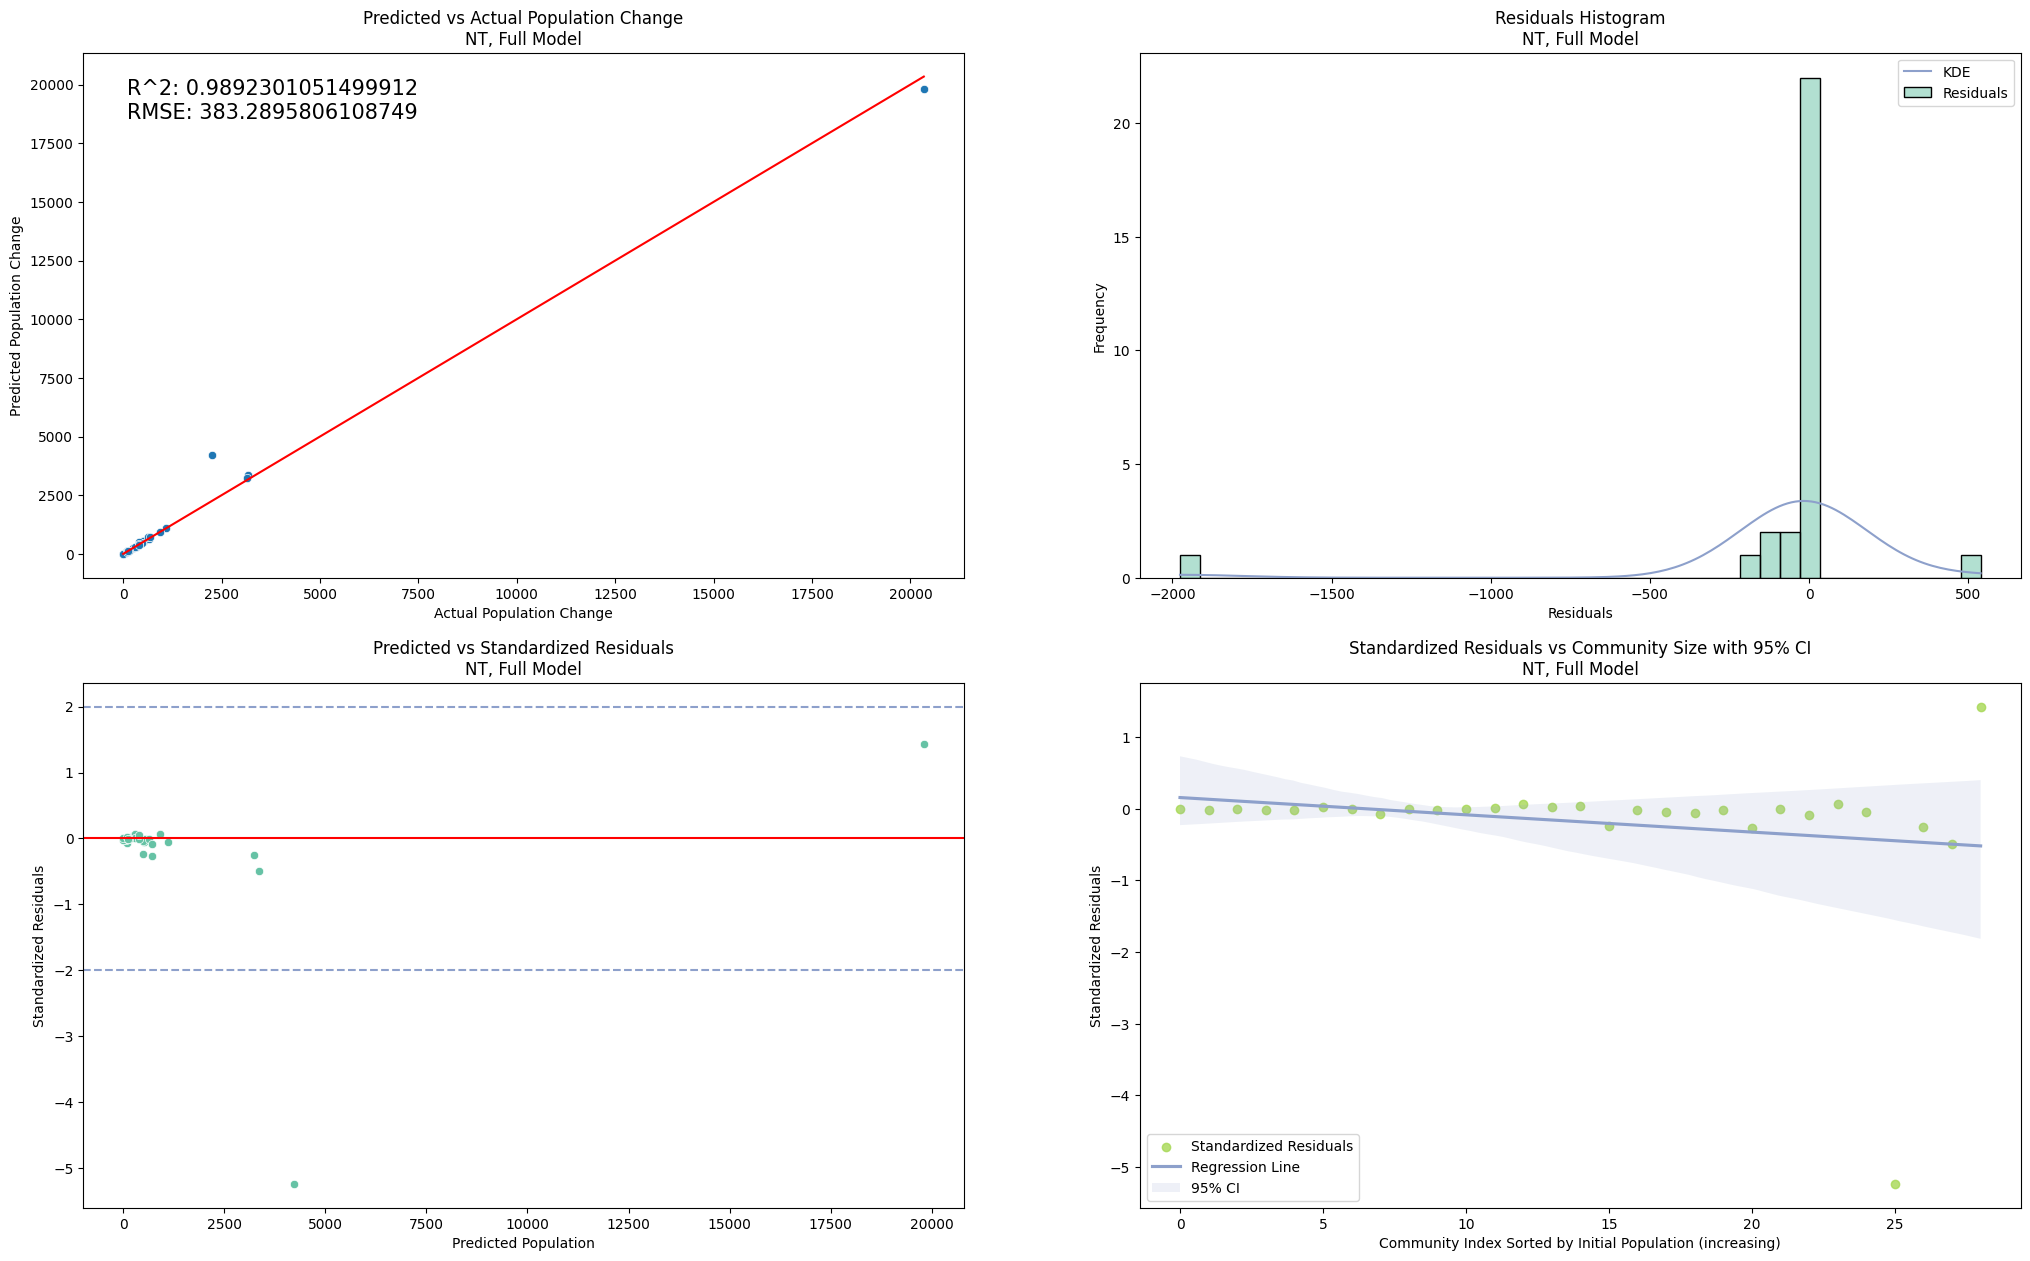

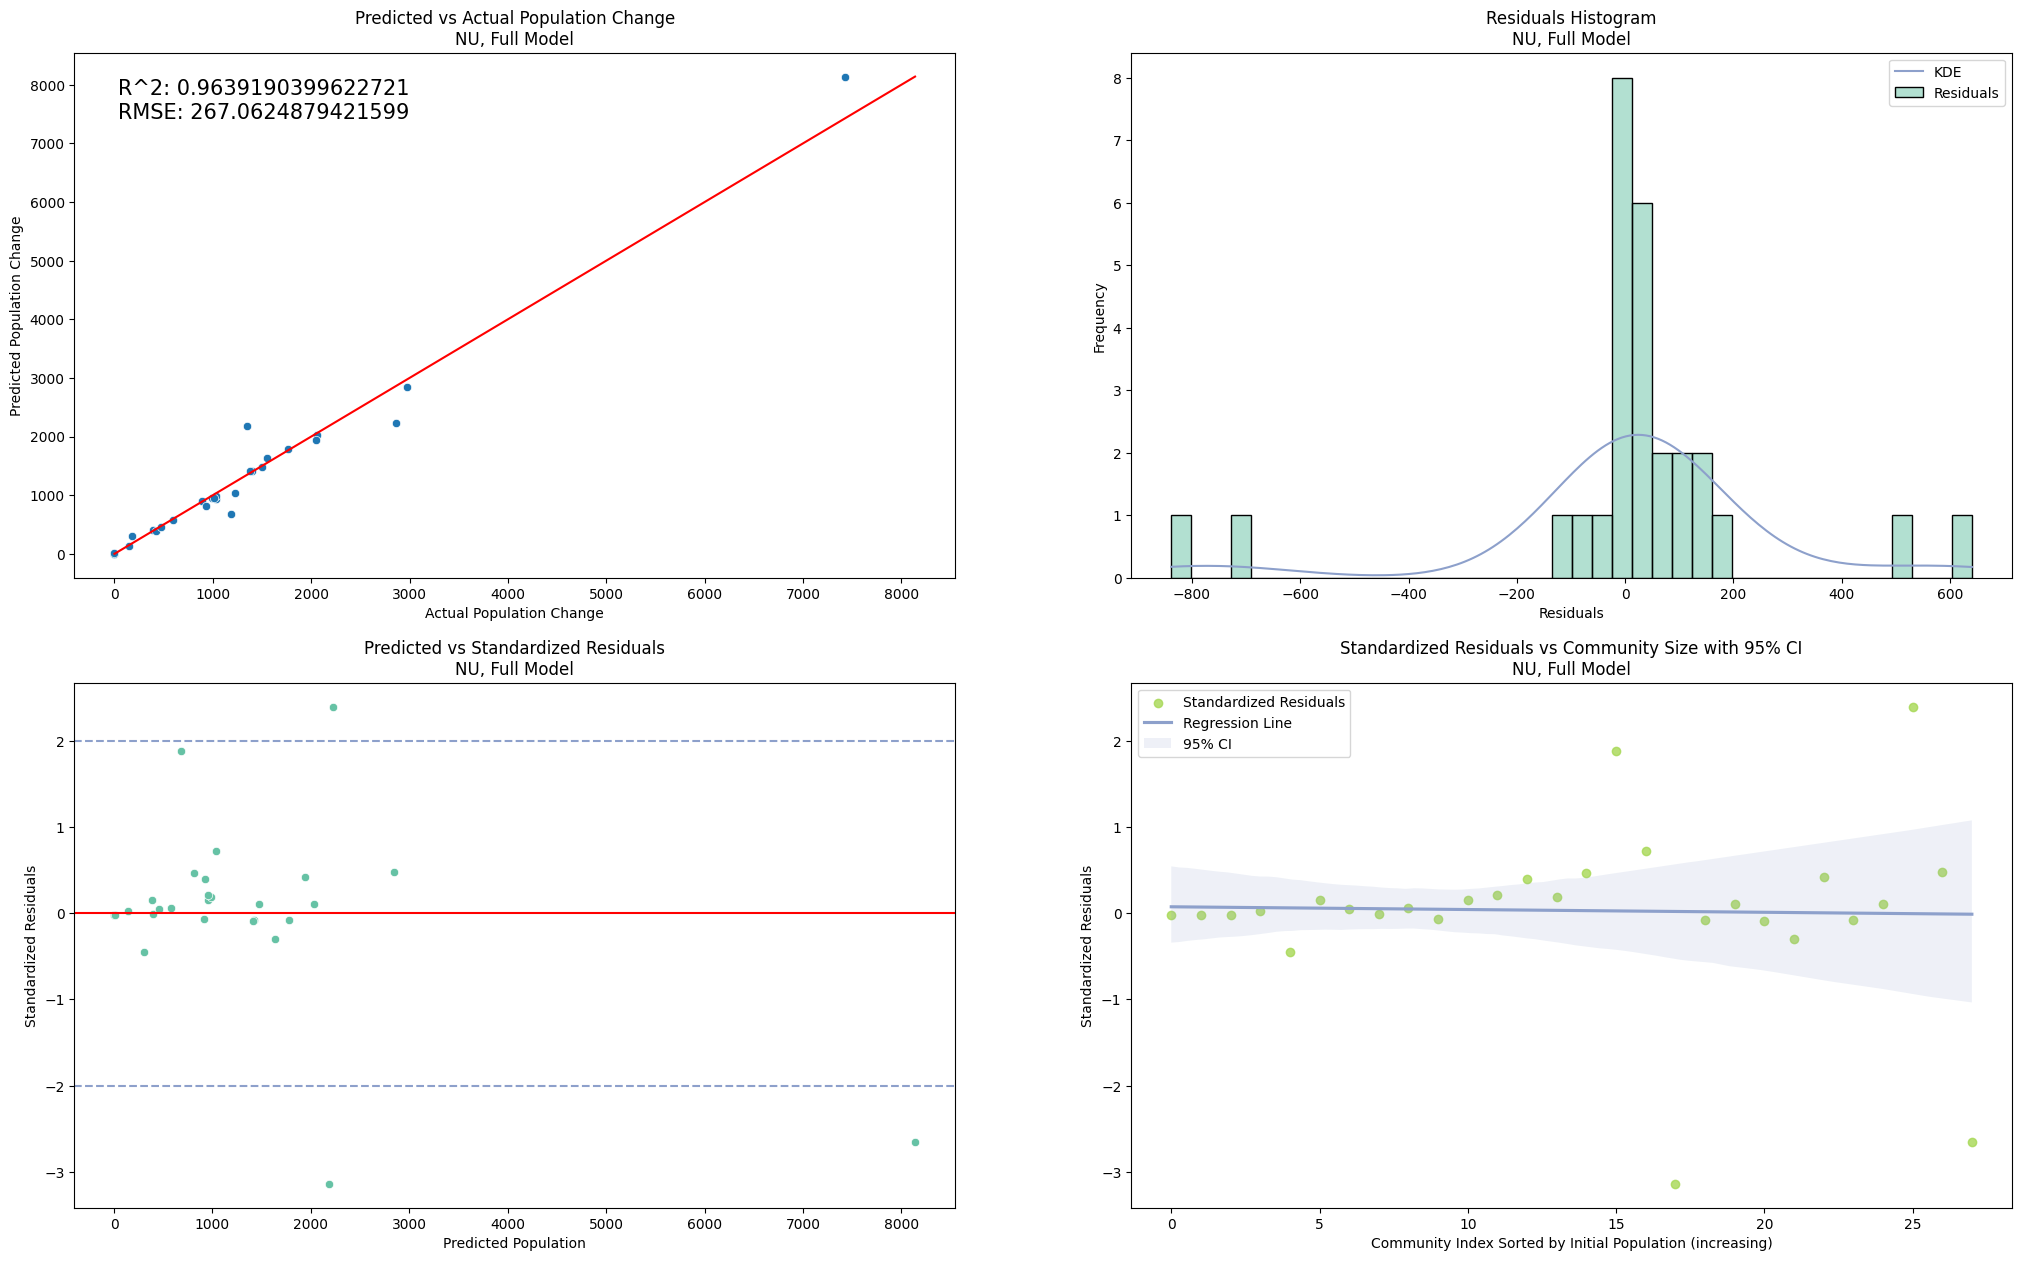

In [43]:
def visualizeResults(results, dataLabel = 'Full Model'):
    '''
    This function takes in a list of results from the predictProvinces function and visualizes the results using seaborn.

    Args:
    results: A list of dictionaries containing the name of the province, the source data, the target data, the predicted population change, the R^2, and the RMSE.
    '''
    for result in results:
        # For each result, we'll plot a number of different graphs as subplots:
        # 1. A scatter plot of the predicted vs actual population change
        # 2. A plot of the percent error
        # 3. A scatter plot of the standardized residuals
        # 4. A plot of the residuals by community size

        # Let's also use seaborn to choose a nice colour palette
        palette = sns.color_palette('Set2')

        fig, axs = plt.subplots(2, 2, figsize=(25, 15))
        # First plot - predicted vs actual
        sns.scatterplot(x=result['targetData']['Population, 2021'], y=result['predicted'], ax=axs[0, 0])
        axs[0, 0].set_title(f'Predicted vs Actual Population Change\n{result["name"]}, {dataLabel}')
        axs[0, 0].set_xlabel('Actual Population Change')
        axs[0, 0].set_ylabel('Predicted Population Change')
        # Add  the R^2 and RMSE to the plot as a text box
        axs[0, 0].text(0.05, 0.95, f'R^2: {result["r2"]}\nRMSE: {result["rmse"]}',
            verticalalignment='top', horizontalalignment='left',
            transform=axs[0, 0].transAxes,
            color='black', fontsize=15)
        
        # Add the 1:1 line using the min and max values of the data
        minVal = min(result['predicted'].min(), result['targetData']['Population, 2021'].min())
        maxVal = max(result['predicted'].max(), result['targetData']['Population, 2021'].max())
        axs[0, 0].plot([minVal, maxVal], [minVal, maxVal], color='red')        

        # Second plot - Histogram of residuals
        residuals = result['targetData']['Population, 2021'] - result['predicted']
        bins = max(np.sqrt(len(residuals)).astype(int), 40)
        sns.histplot(residuals, ax=axs[0, 1], bins = bins, kde=True, color=palette[0])
        # Adjust color of kde line
        axs[0, 1].lines[0].set_color(palette[2])
        axs[0, 1].set_title(f'Residuals Histogram\n{result["name"]}, {dataLabel}')
        axs[0, 1].set_xlabel('Residuals')
        axs[0, 1].set_ylabel('Frequency')
        axs[0, 1].legend(['KDE', 'Residuals'])

        # Third plot - Predicted vs Standardized residuals
        standardizedResiduals = residuals / np.std(residuals)
        sns.scatterplot(x=result['predicted'], y=standardizedResiduals, ax=axs[1, 0], color=palette[0])
        axs[1, 0].set_title(f'Predicted vs Standardized Residuals\n{result["name"]}, {dataLabel}')
        axs[1, 0].set_xlabel('Predicted Population')
        axs[1, 0].set_ylabel('Standardized Residuals')
        axs[1, 0].axhline(y=0, color='red')
        axs[1, 0].axhline(y=2, color=palette[2], linestyle='--')
        axs[1, 0].axhline(y=-2, color=palette[2], linestyle='--')

        # Fourth plot
        # we need to sort by population 2016 to get the correct order
        byPop = result['sourceData'].sort_values(by='Population, 2016')
        # We also need to sort our other values to match the order of our new byPop dataframe
        byPopPred = result['predicted'][byPop.index]
        byPopTarget = result['targetData']['Population, 2021'][byPop.index]
        byPop.reset_index(inplace=True)
        sortedResiduals = byPopTarget - byPopPred
        standardSortedResiduals = sortedResiduals / np.std(sortedResiduals)

        sns.regplot(x=byPop.index, y=standardSortedResiduals, ax=axs[1, 1], ci=95, color = palette[0], scatter_kws={'color': palette[4]}, line_kws={'color': palette[2]})
        axs[1, 1].set_title(f'Standardized Residuals vs Community Size with 95% CI\n{result["name"]}, {dataLabel}')
        axs[1, 1].set_xlabel('Community Index Sorted by Initial Population (increasing)')
        axs[1, 1].set_ylabel('Standardized Residuals')
        axs[1, 1].legend(['Standardized Residuals', 'Regression Line', '95% CI'])

        fig.savefig(f'./figures/{result["name"]}_{dataLabel}.png')

visualizeResults(results)

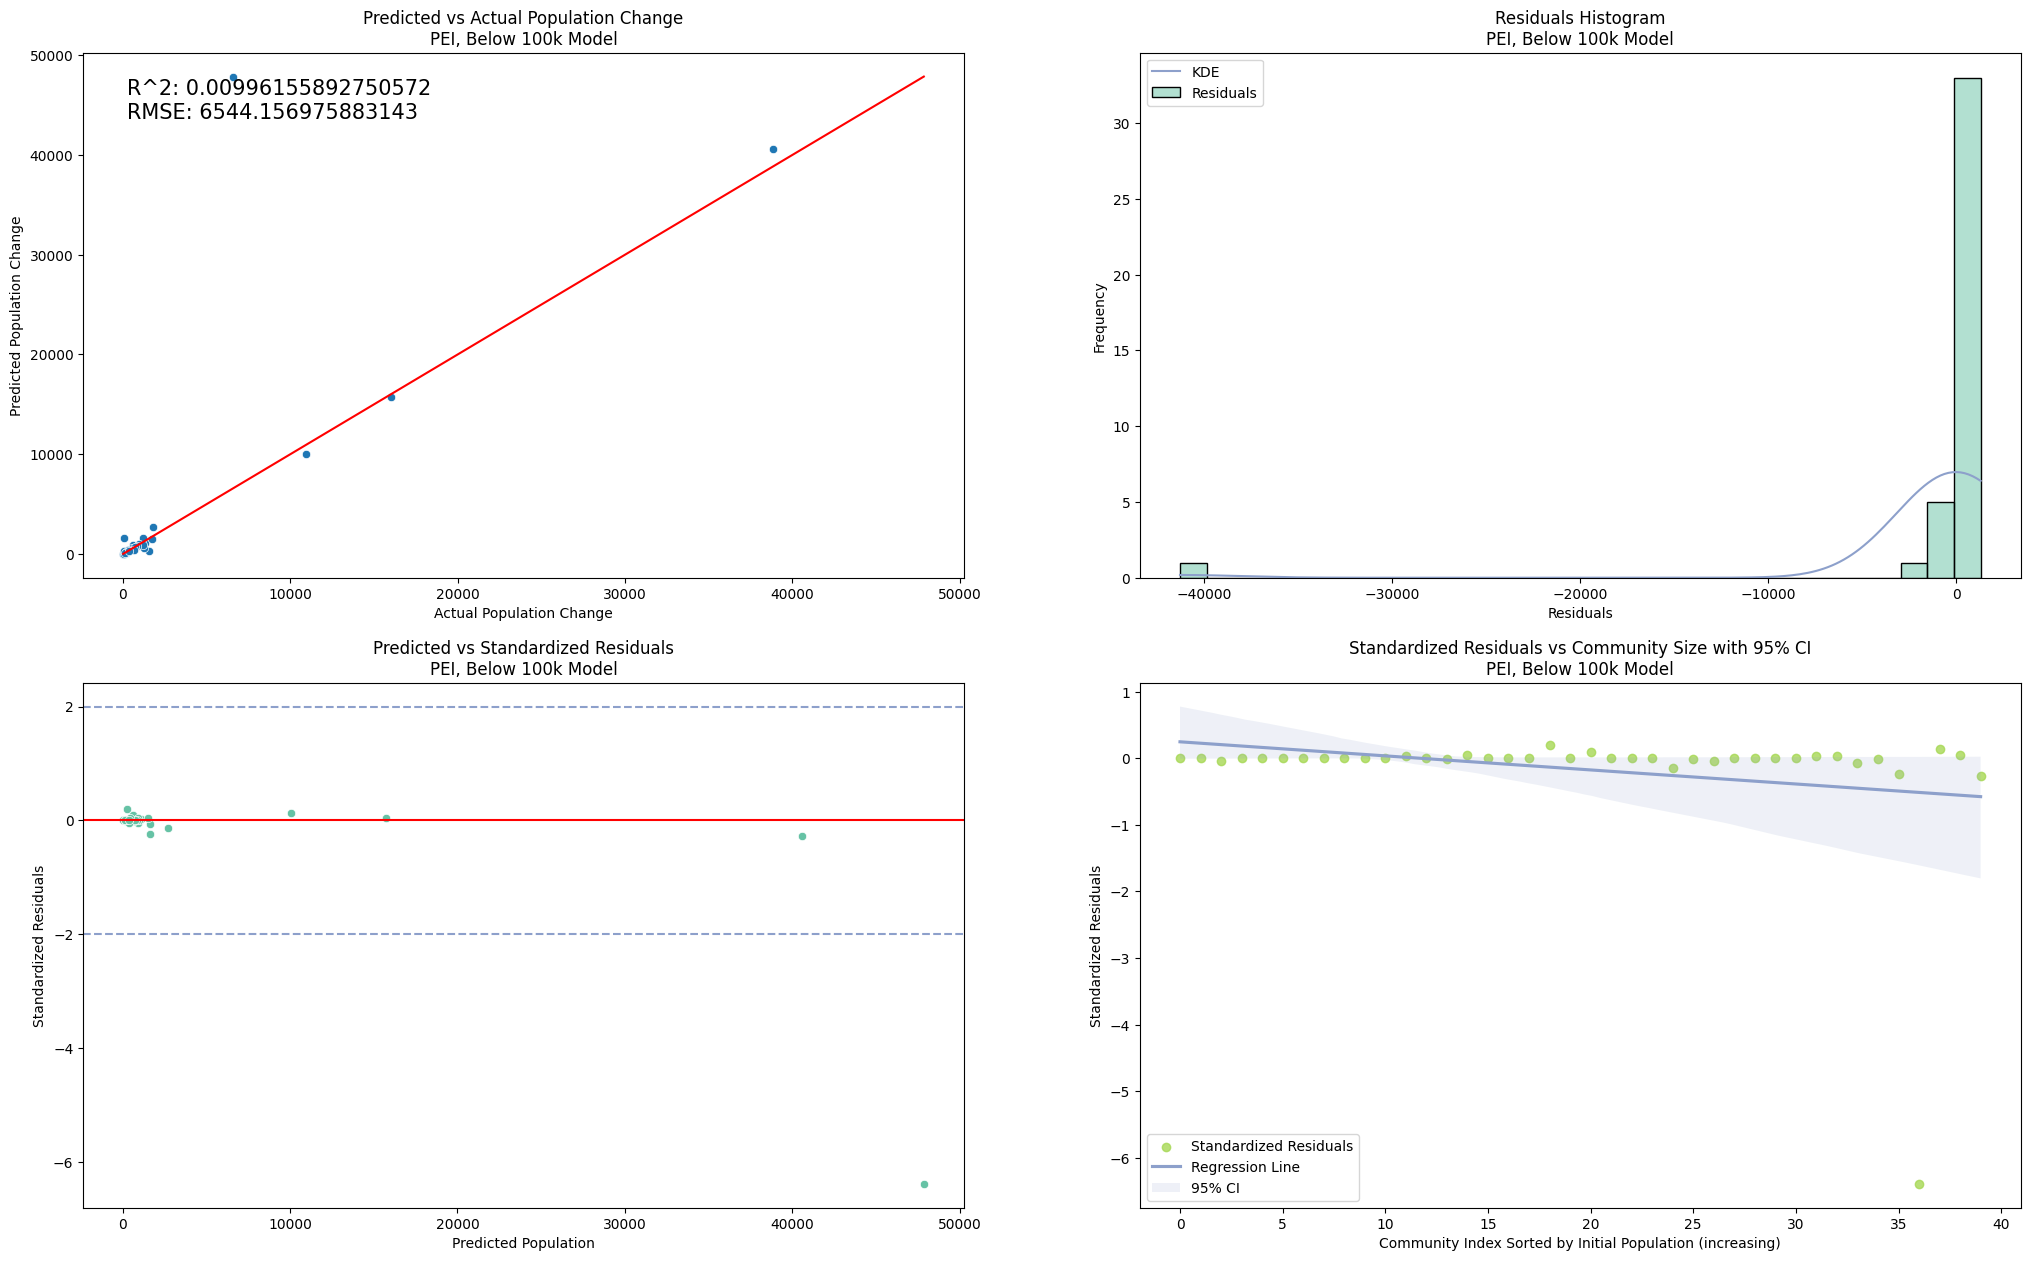

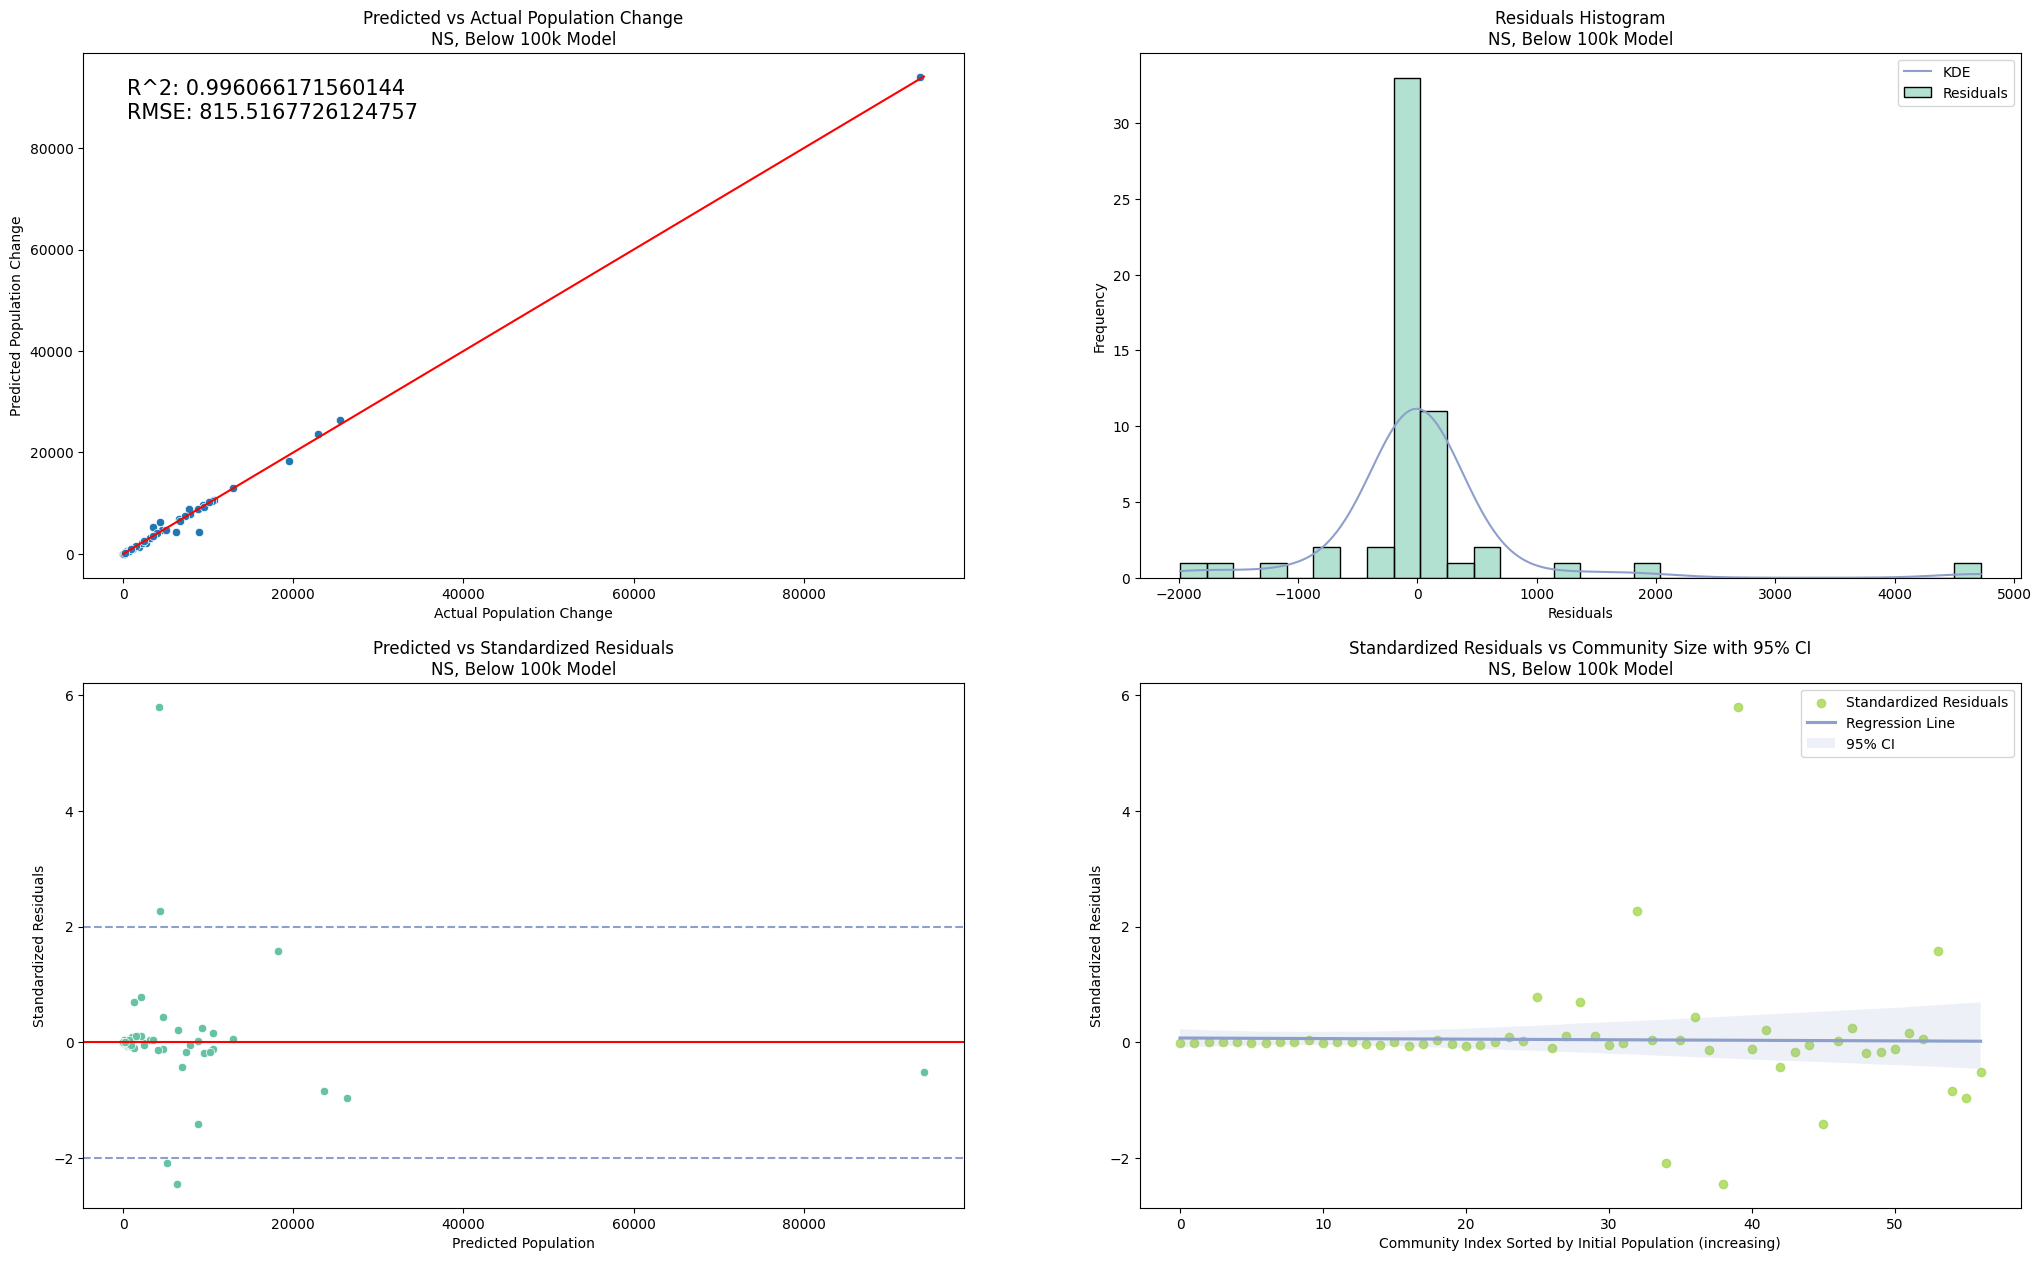

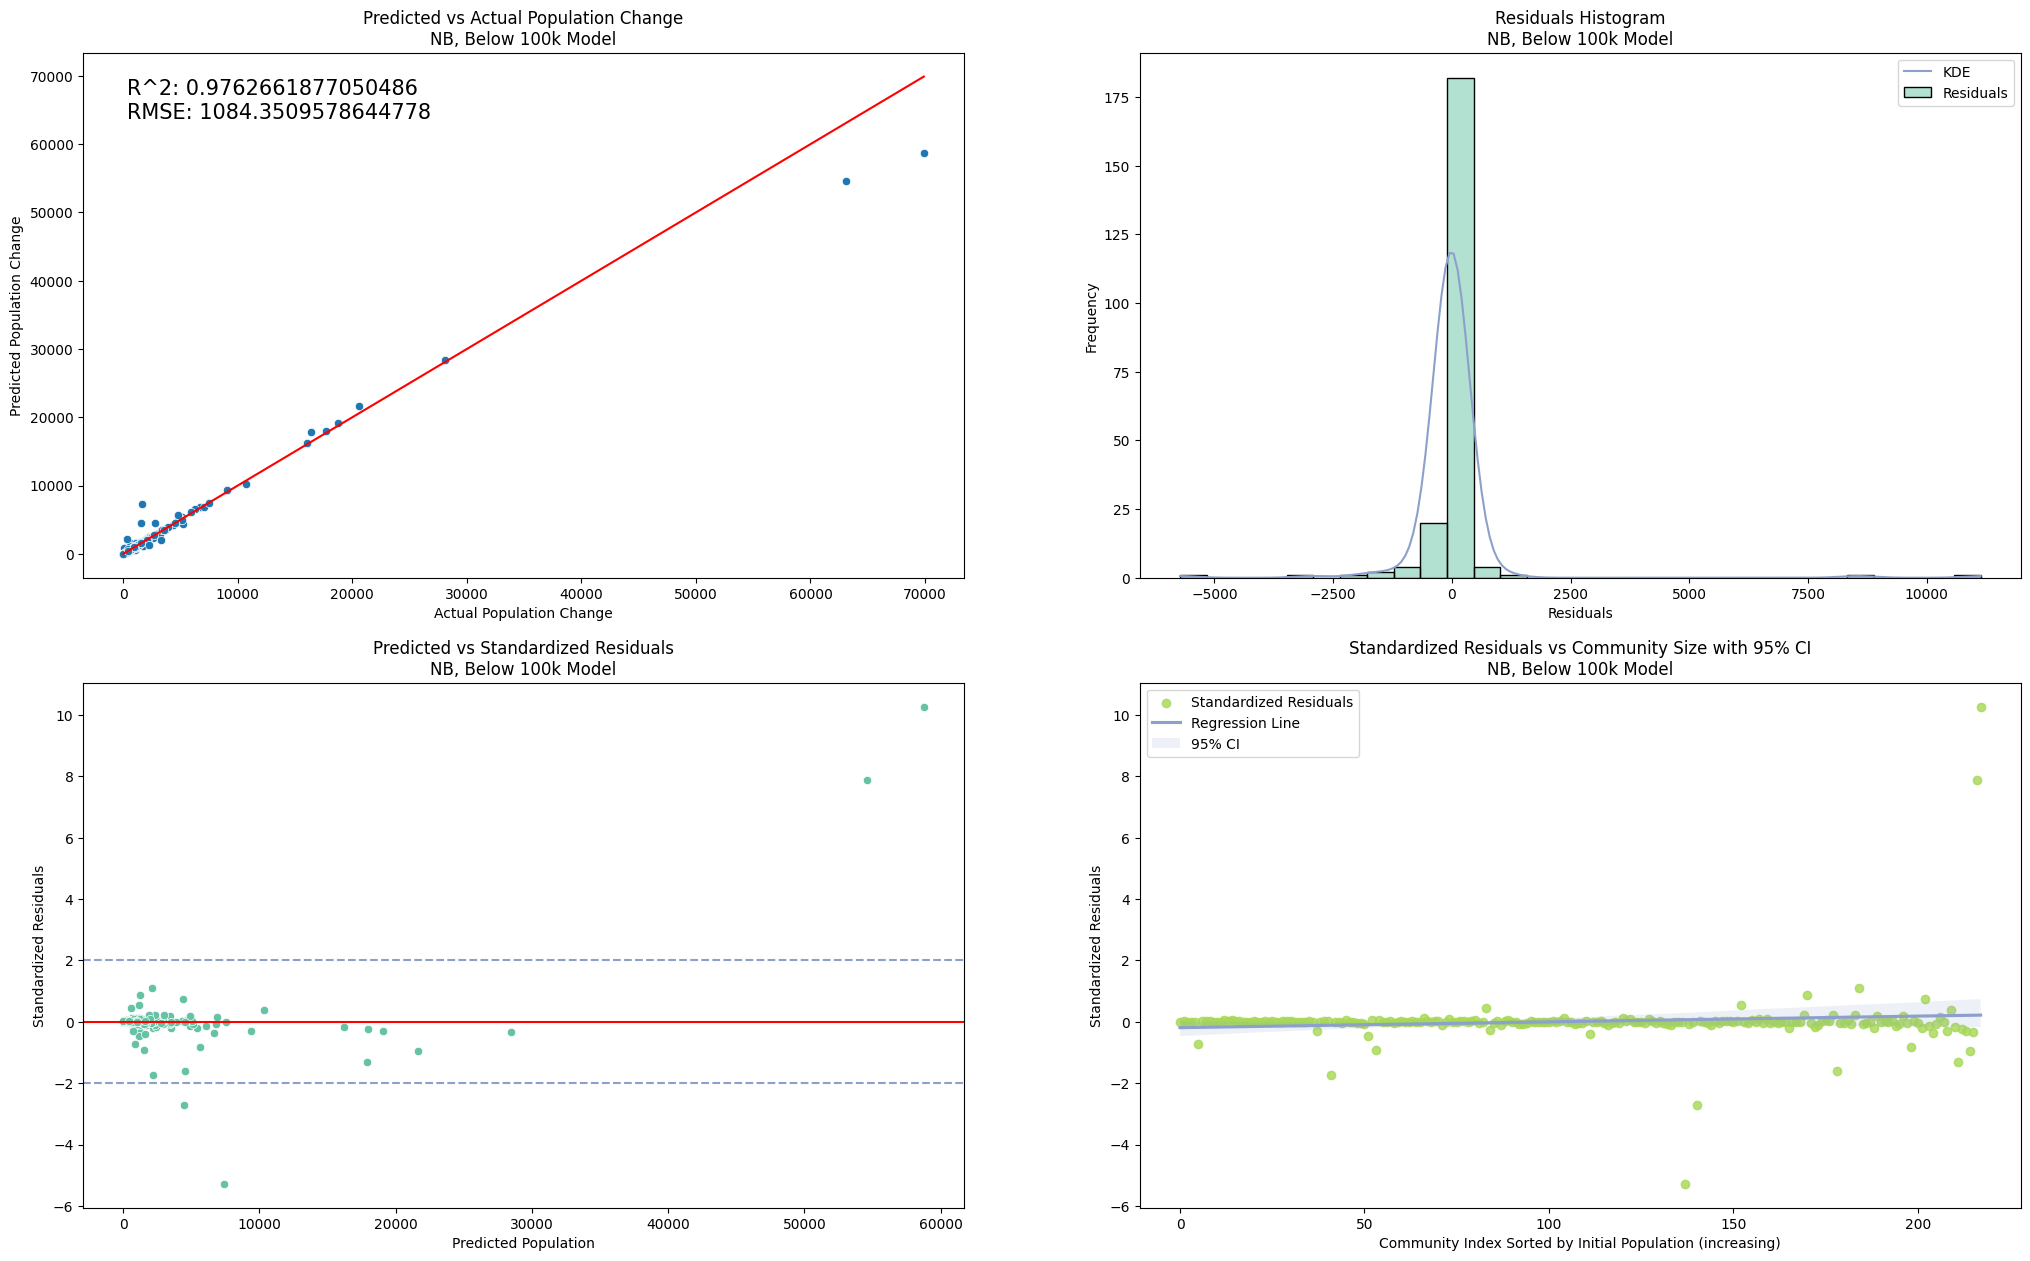

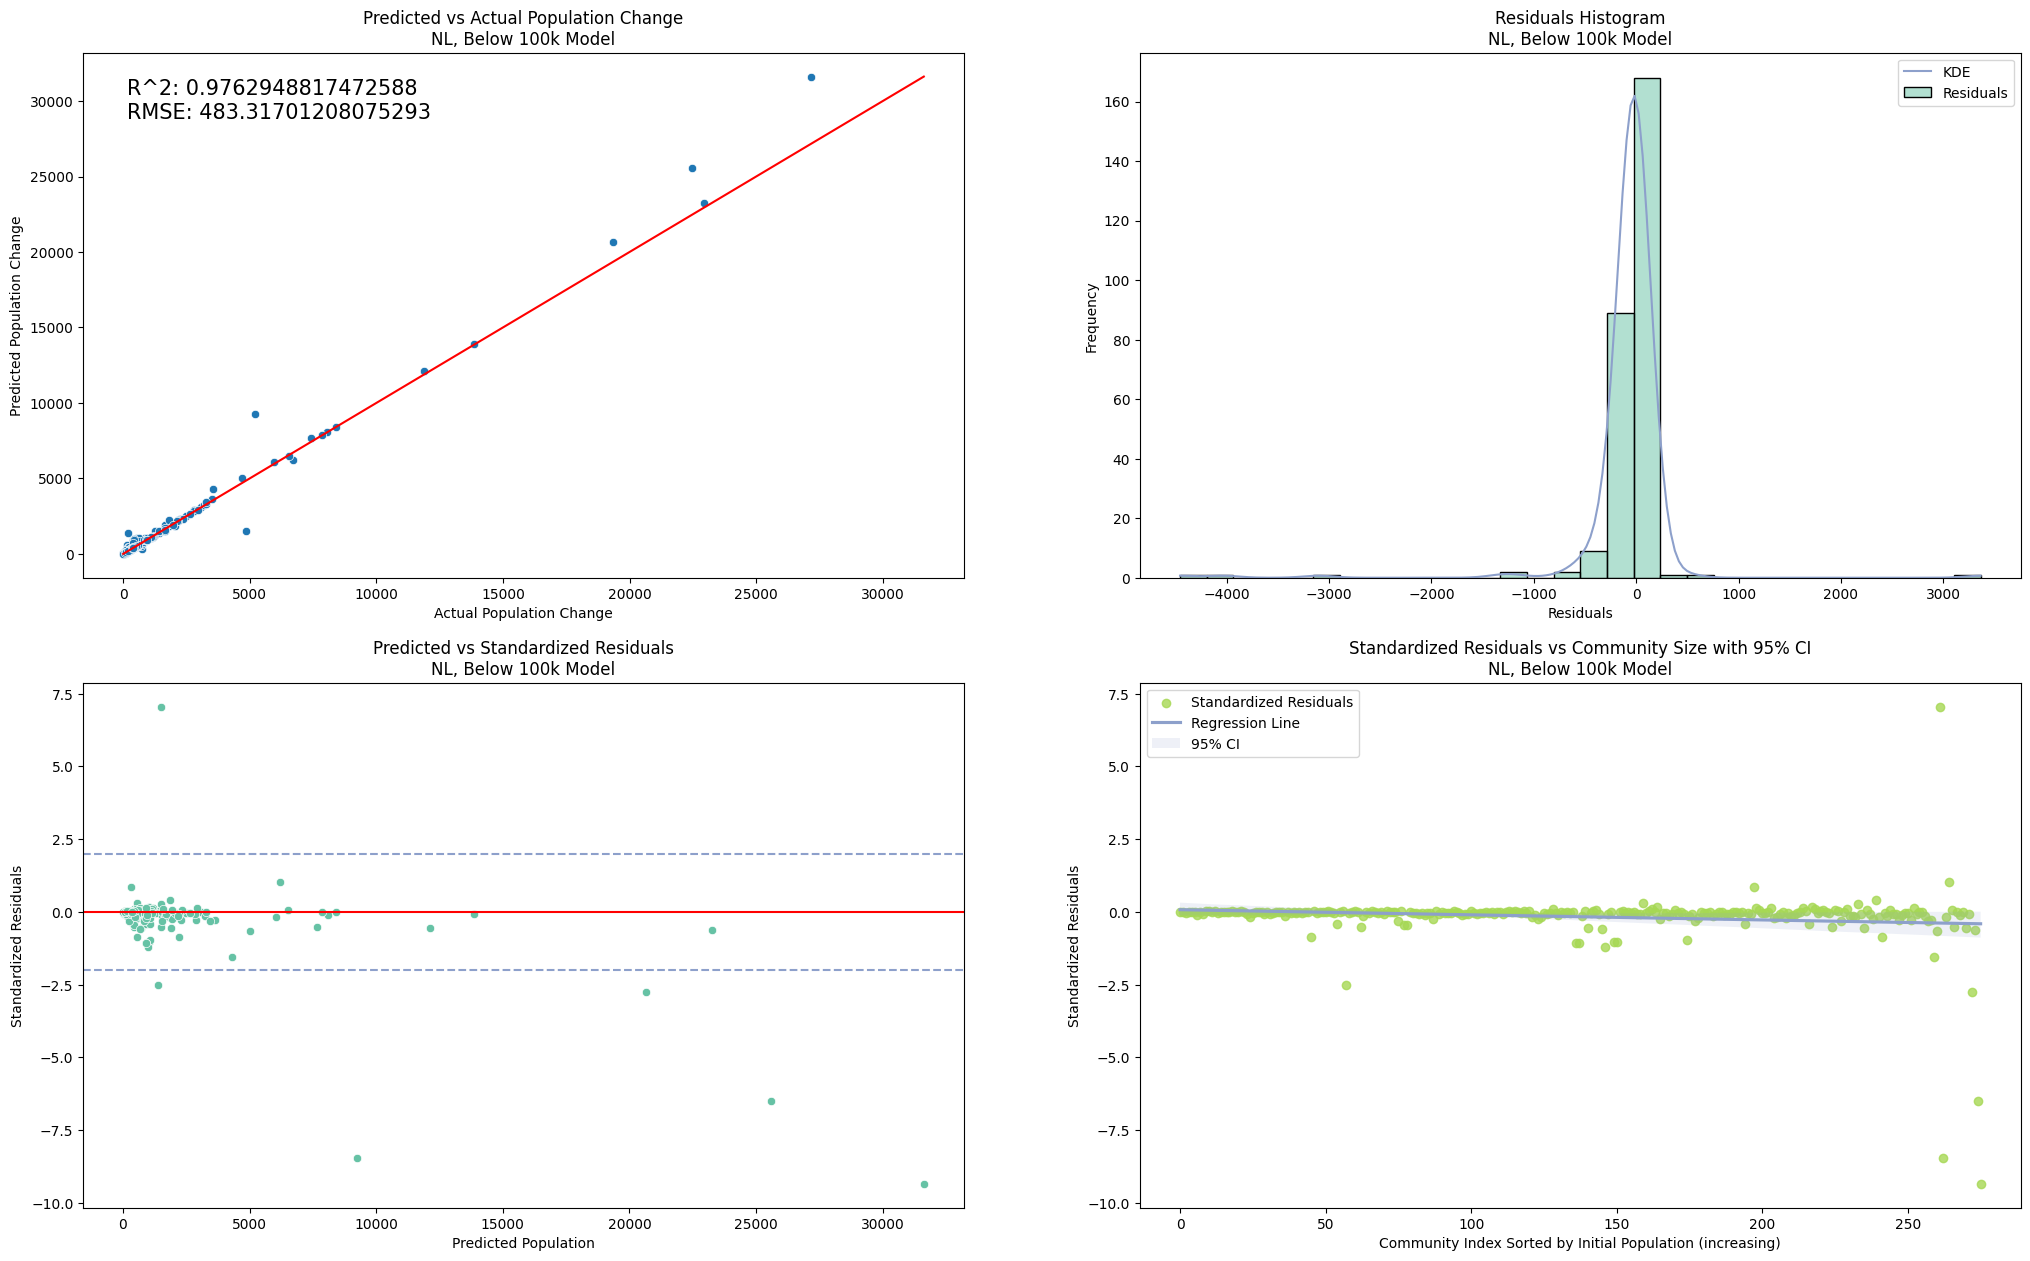

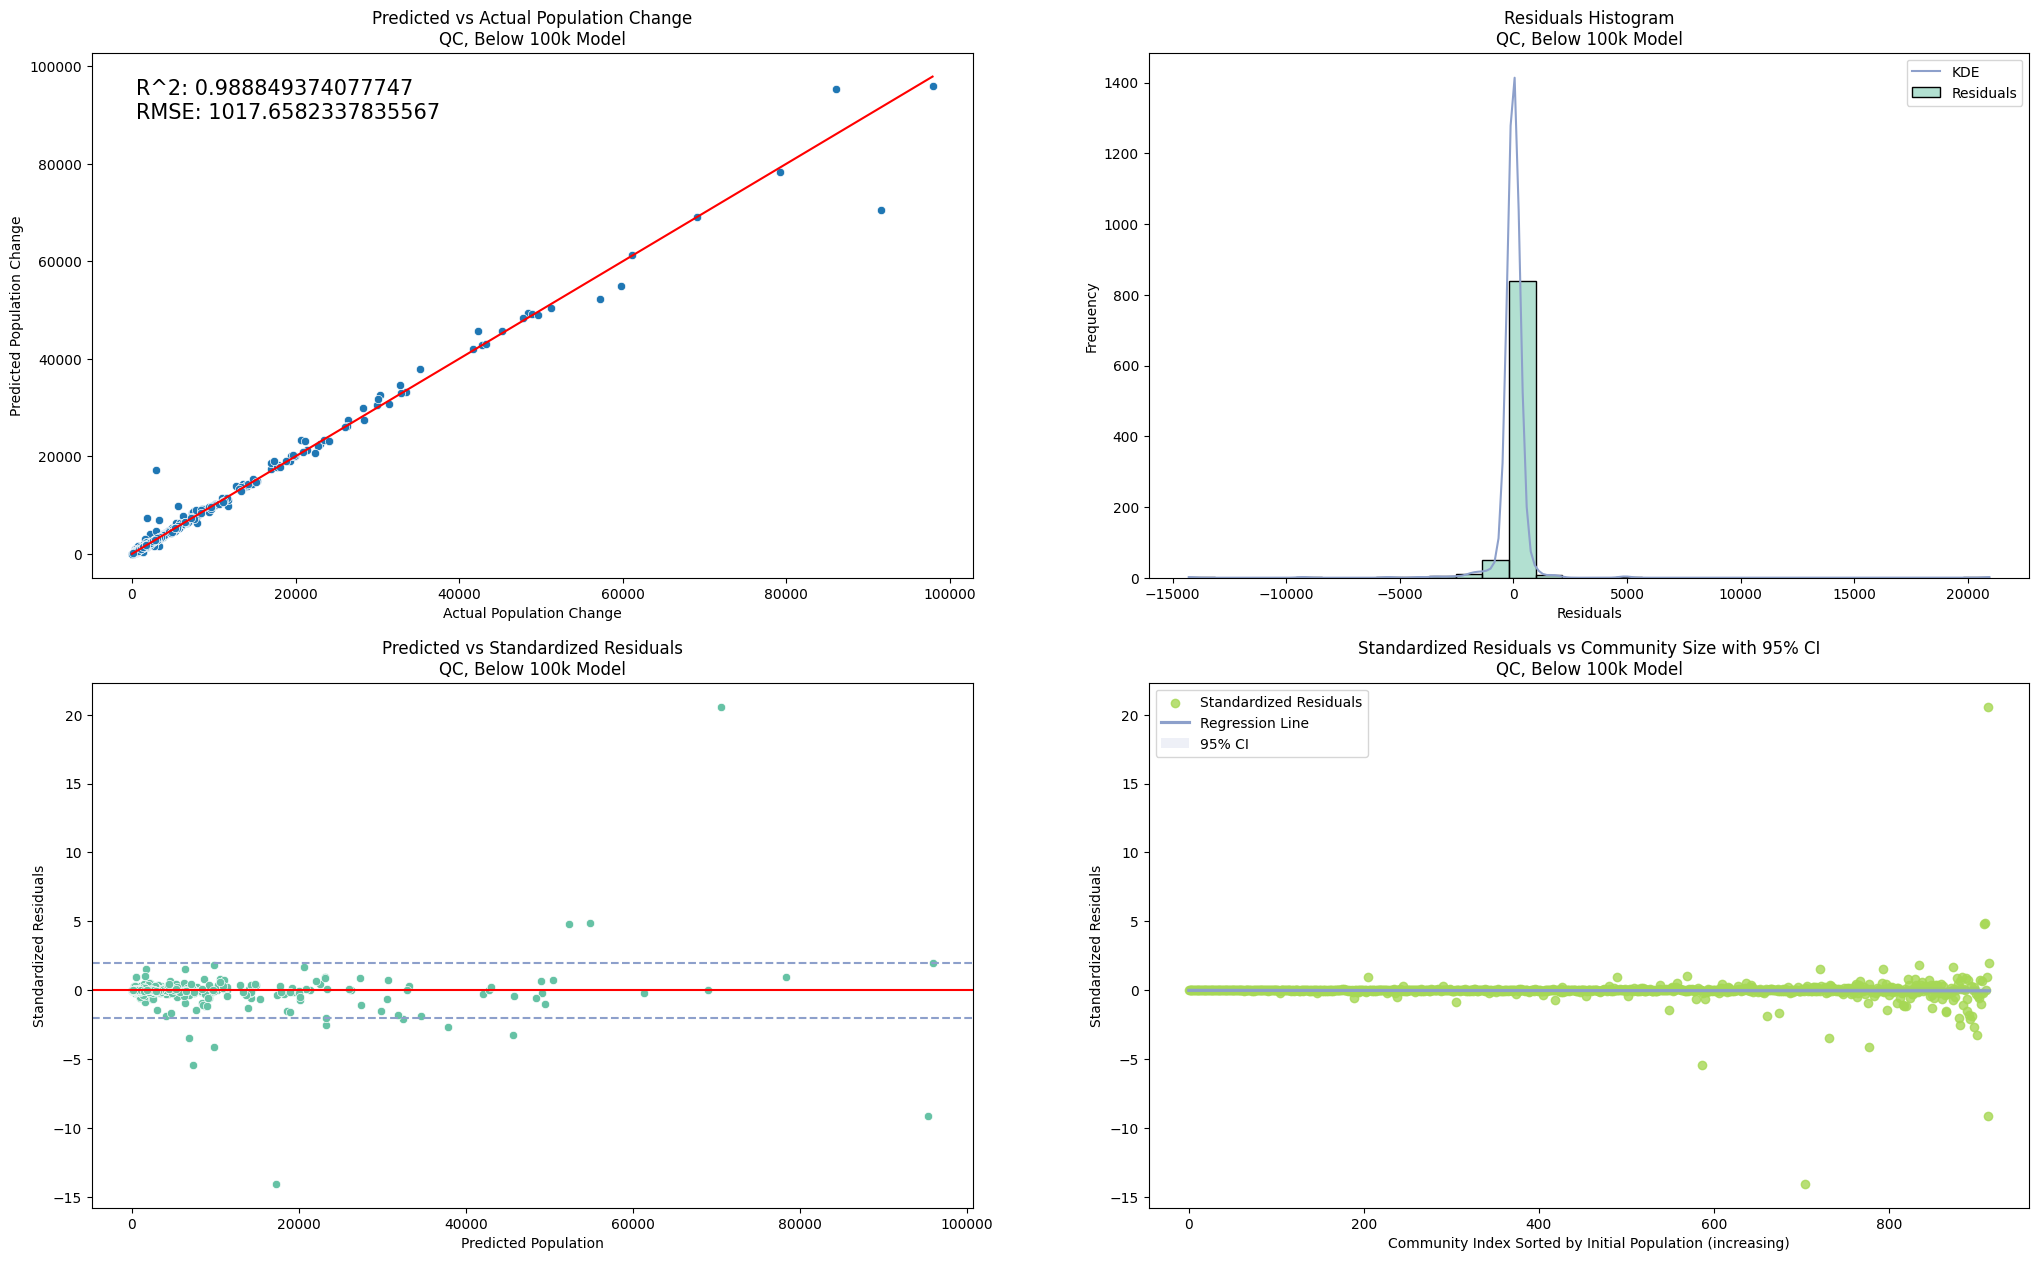

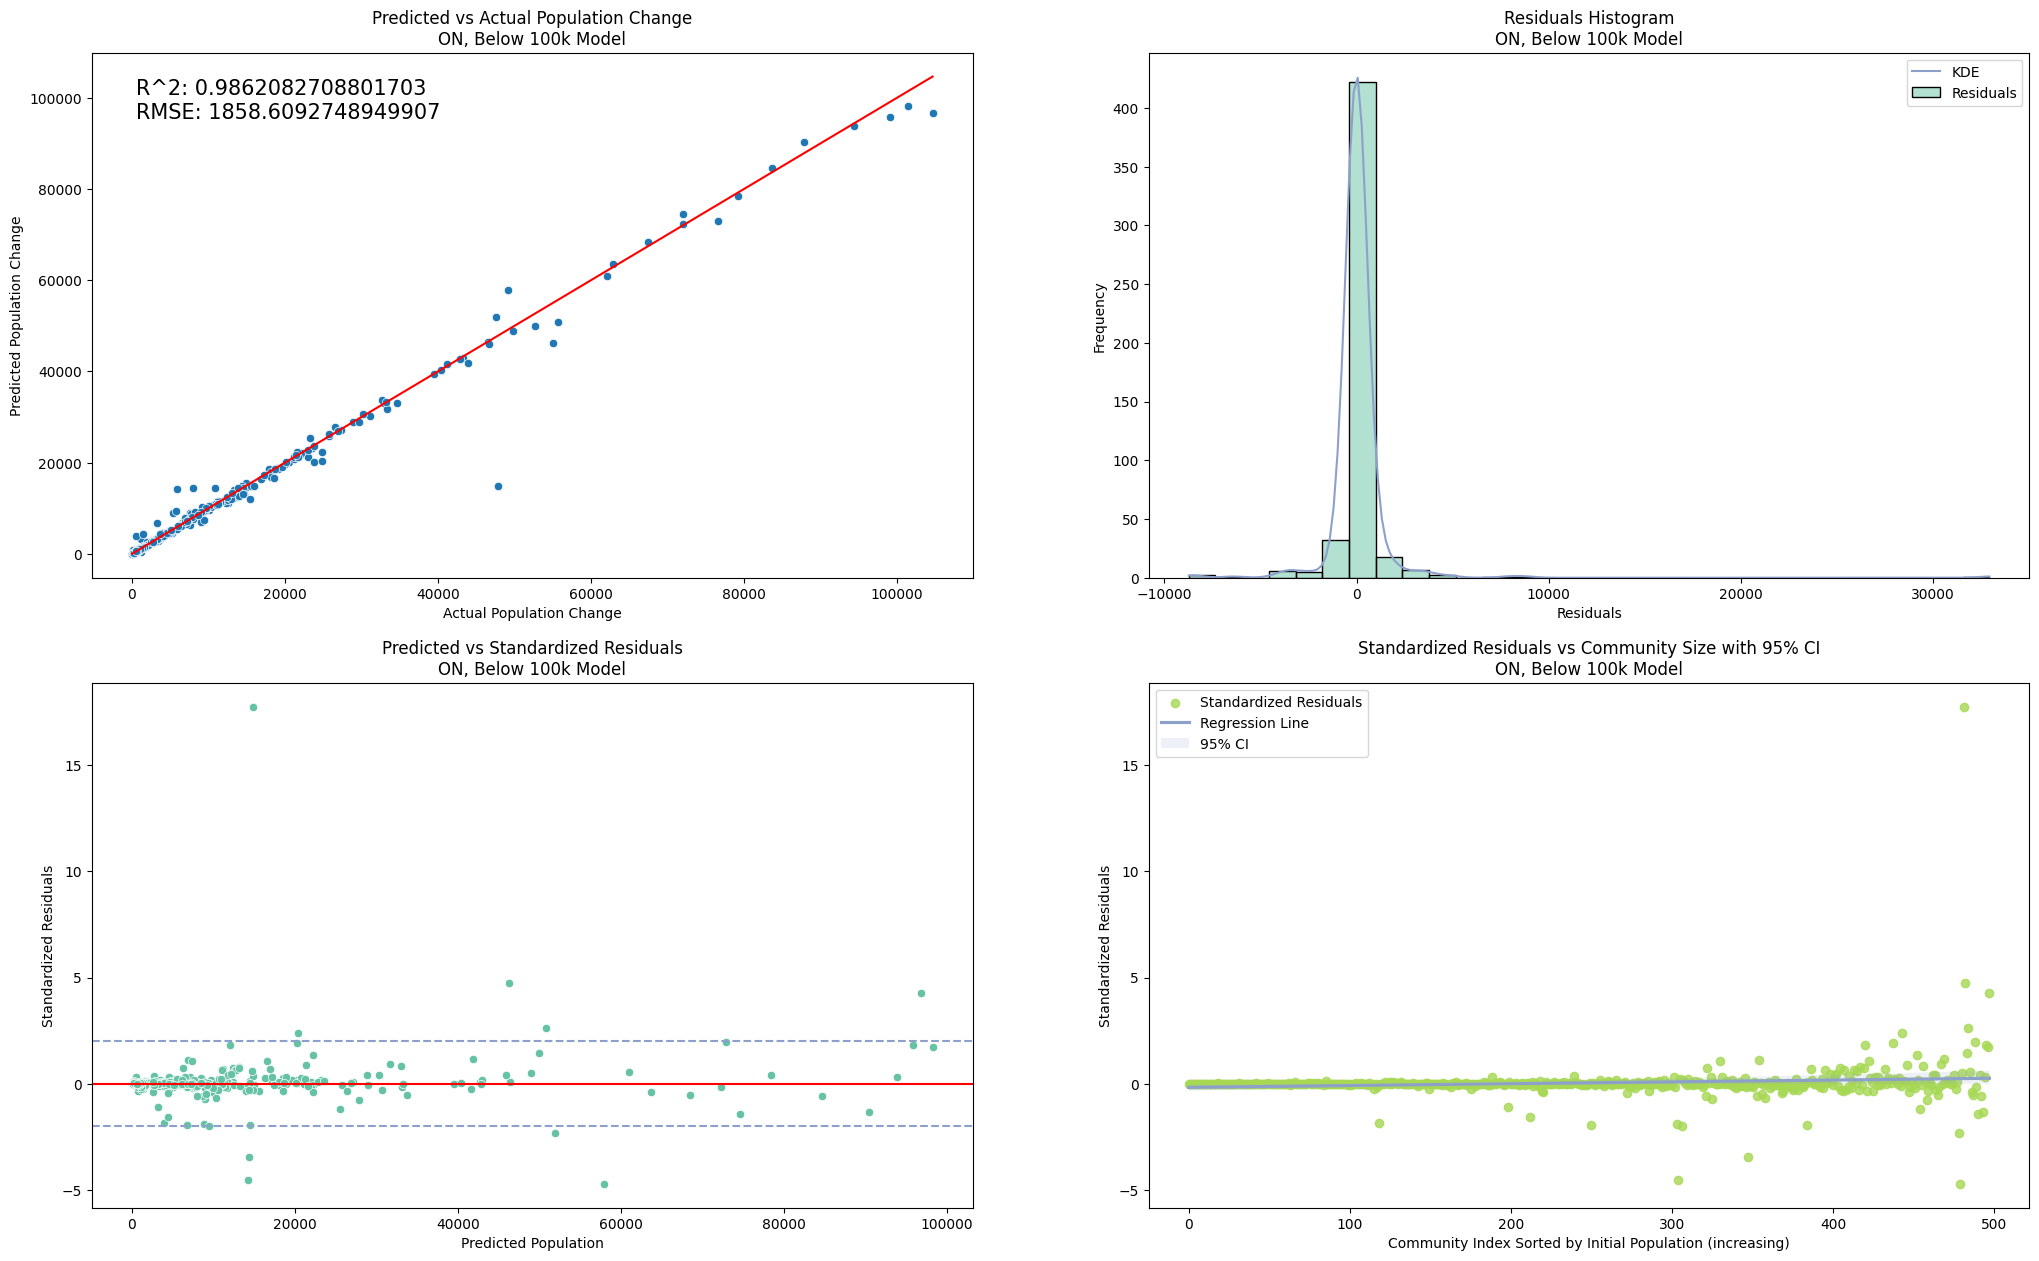

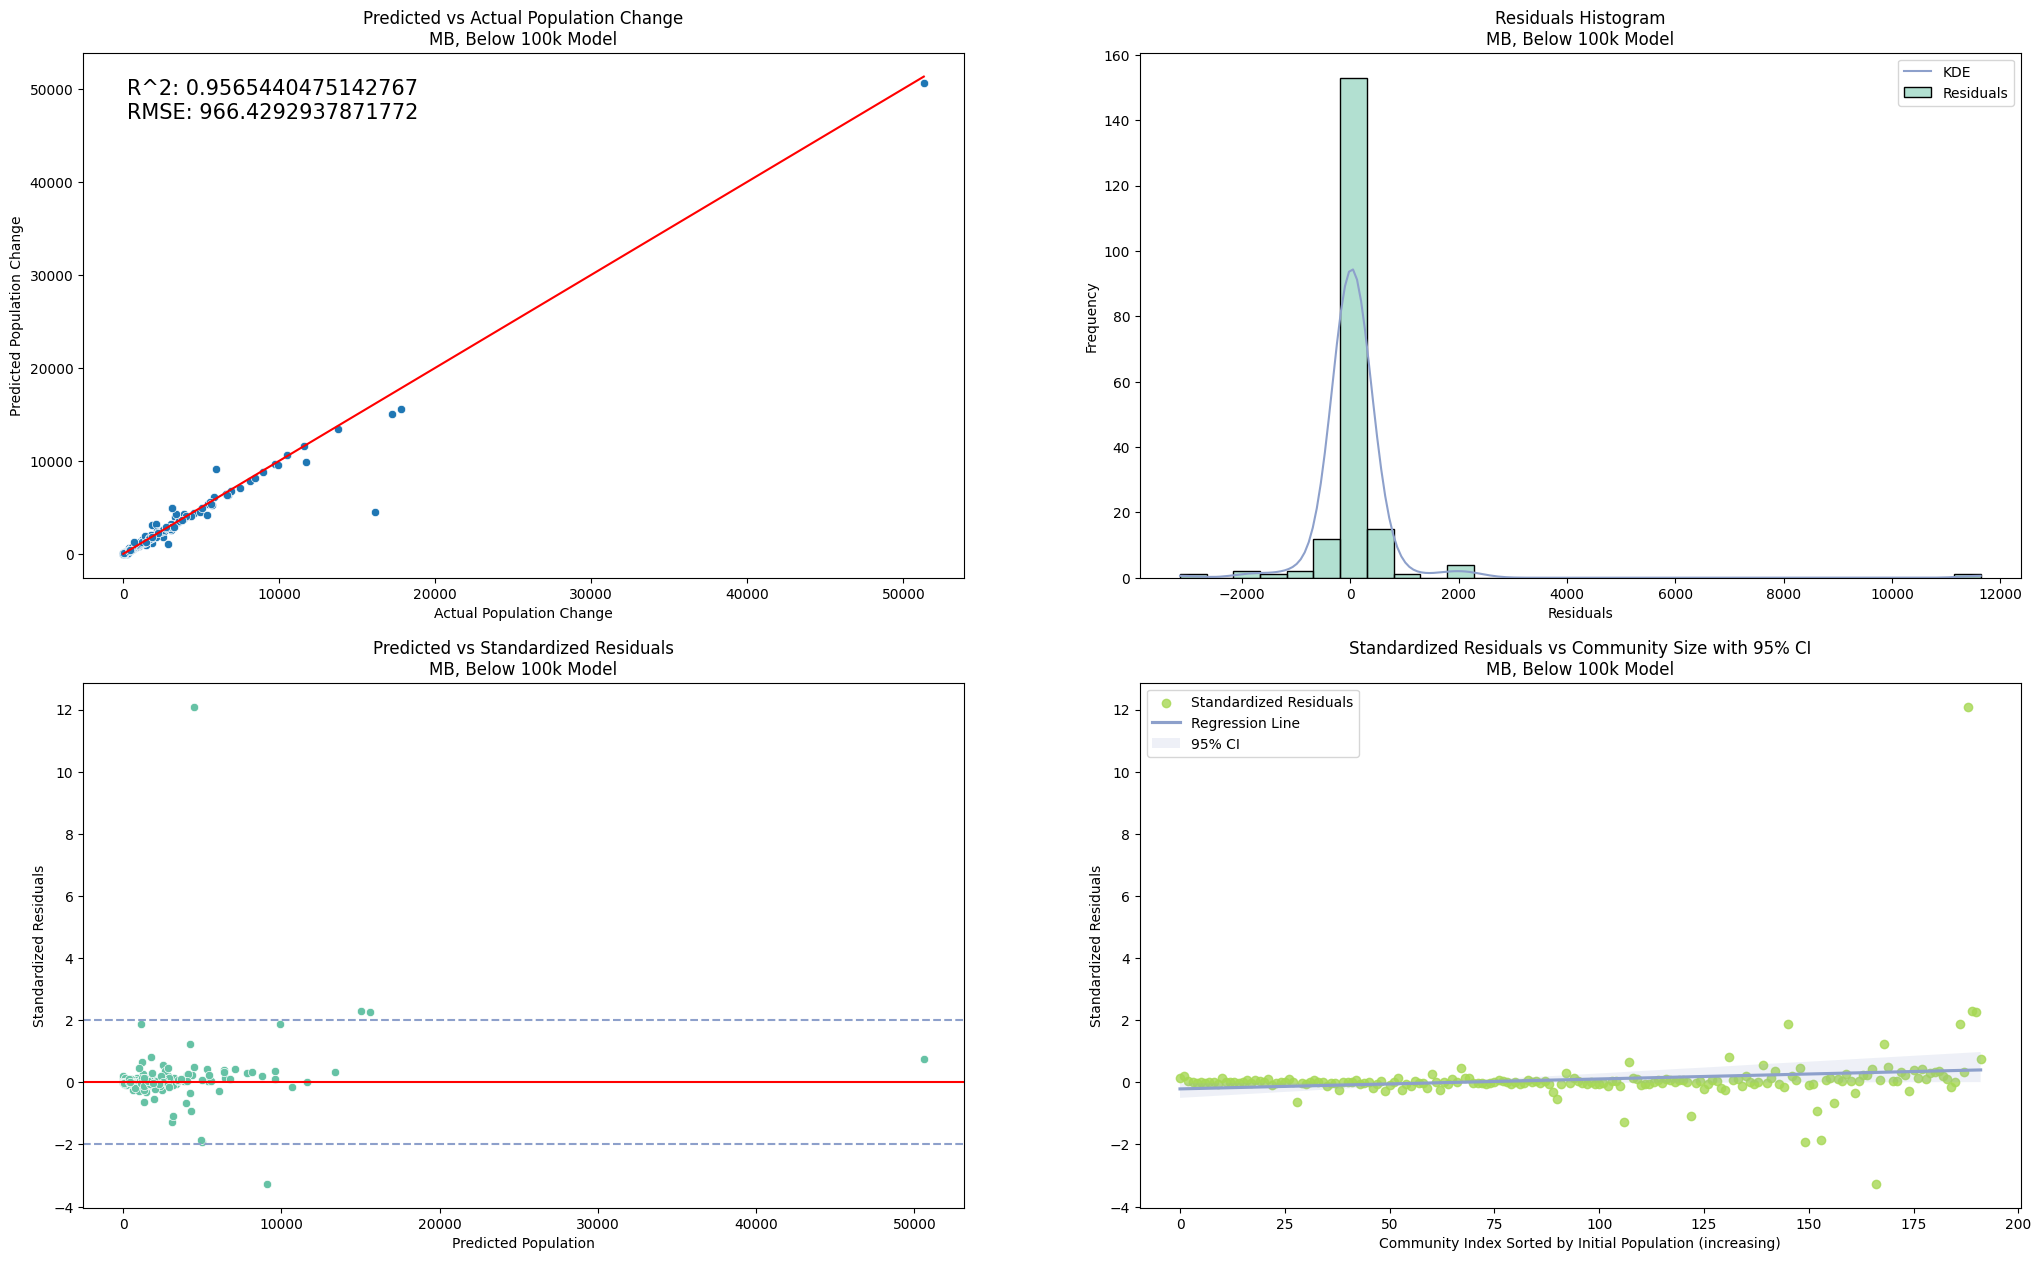

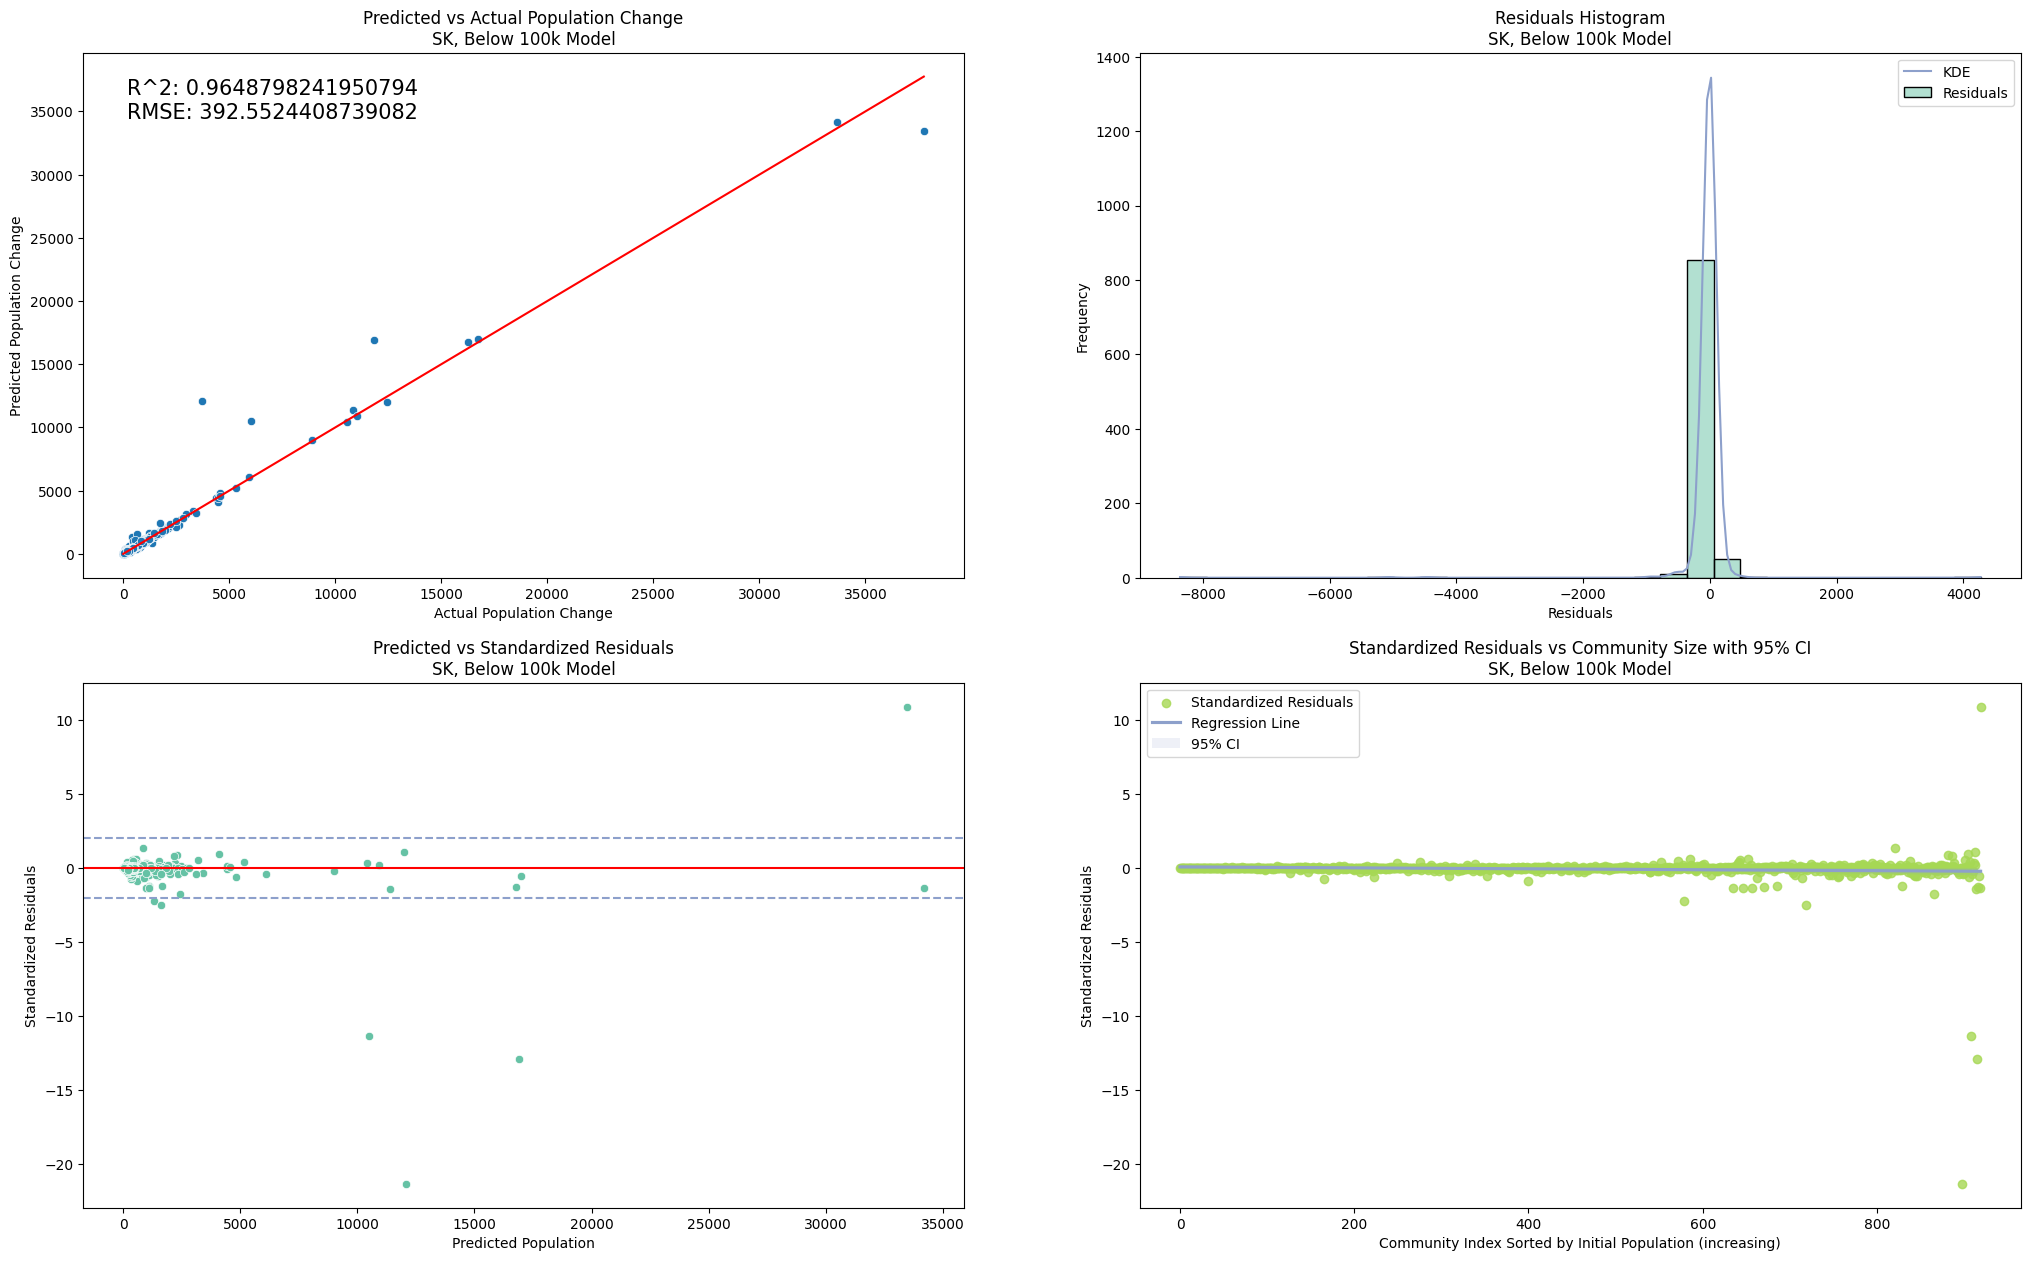

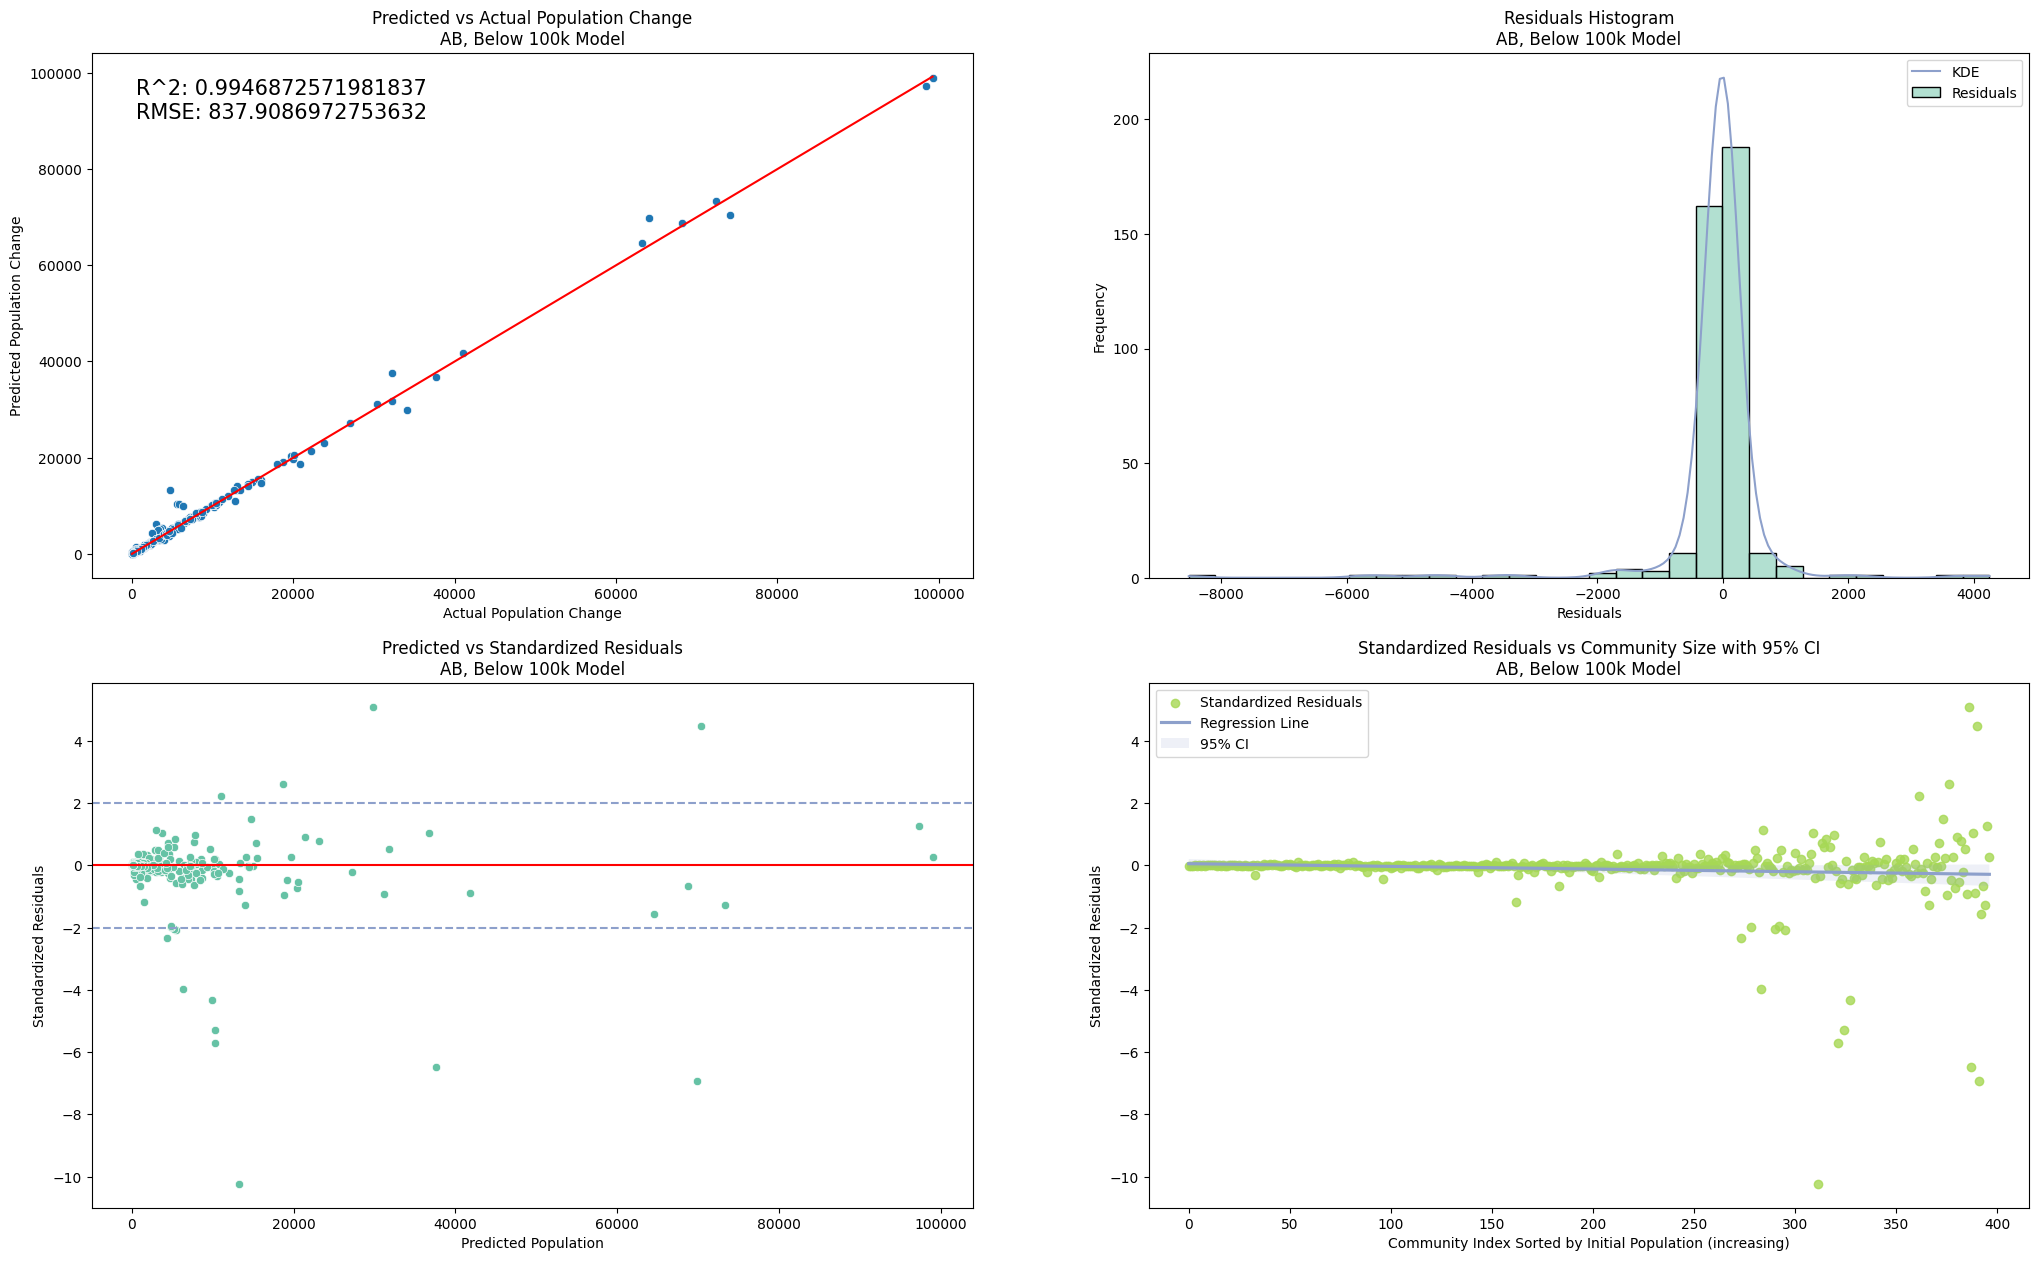

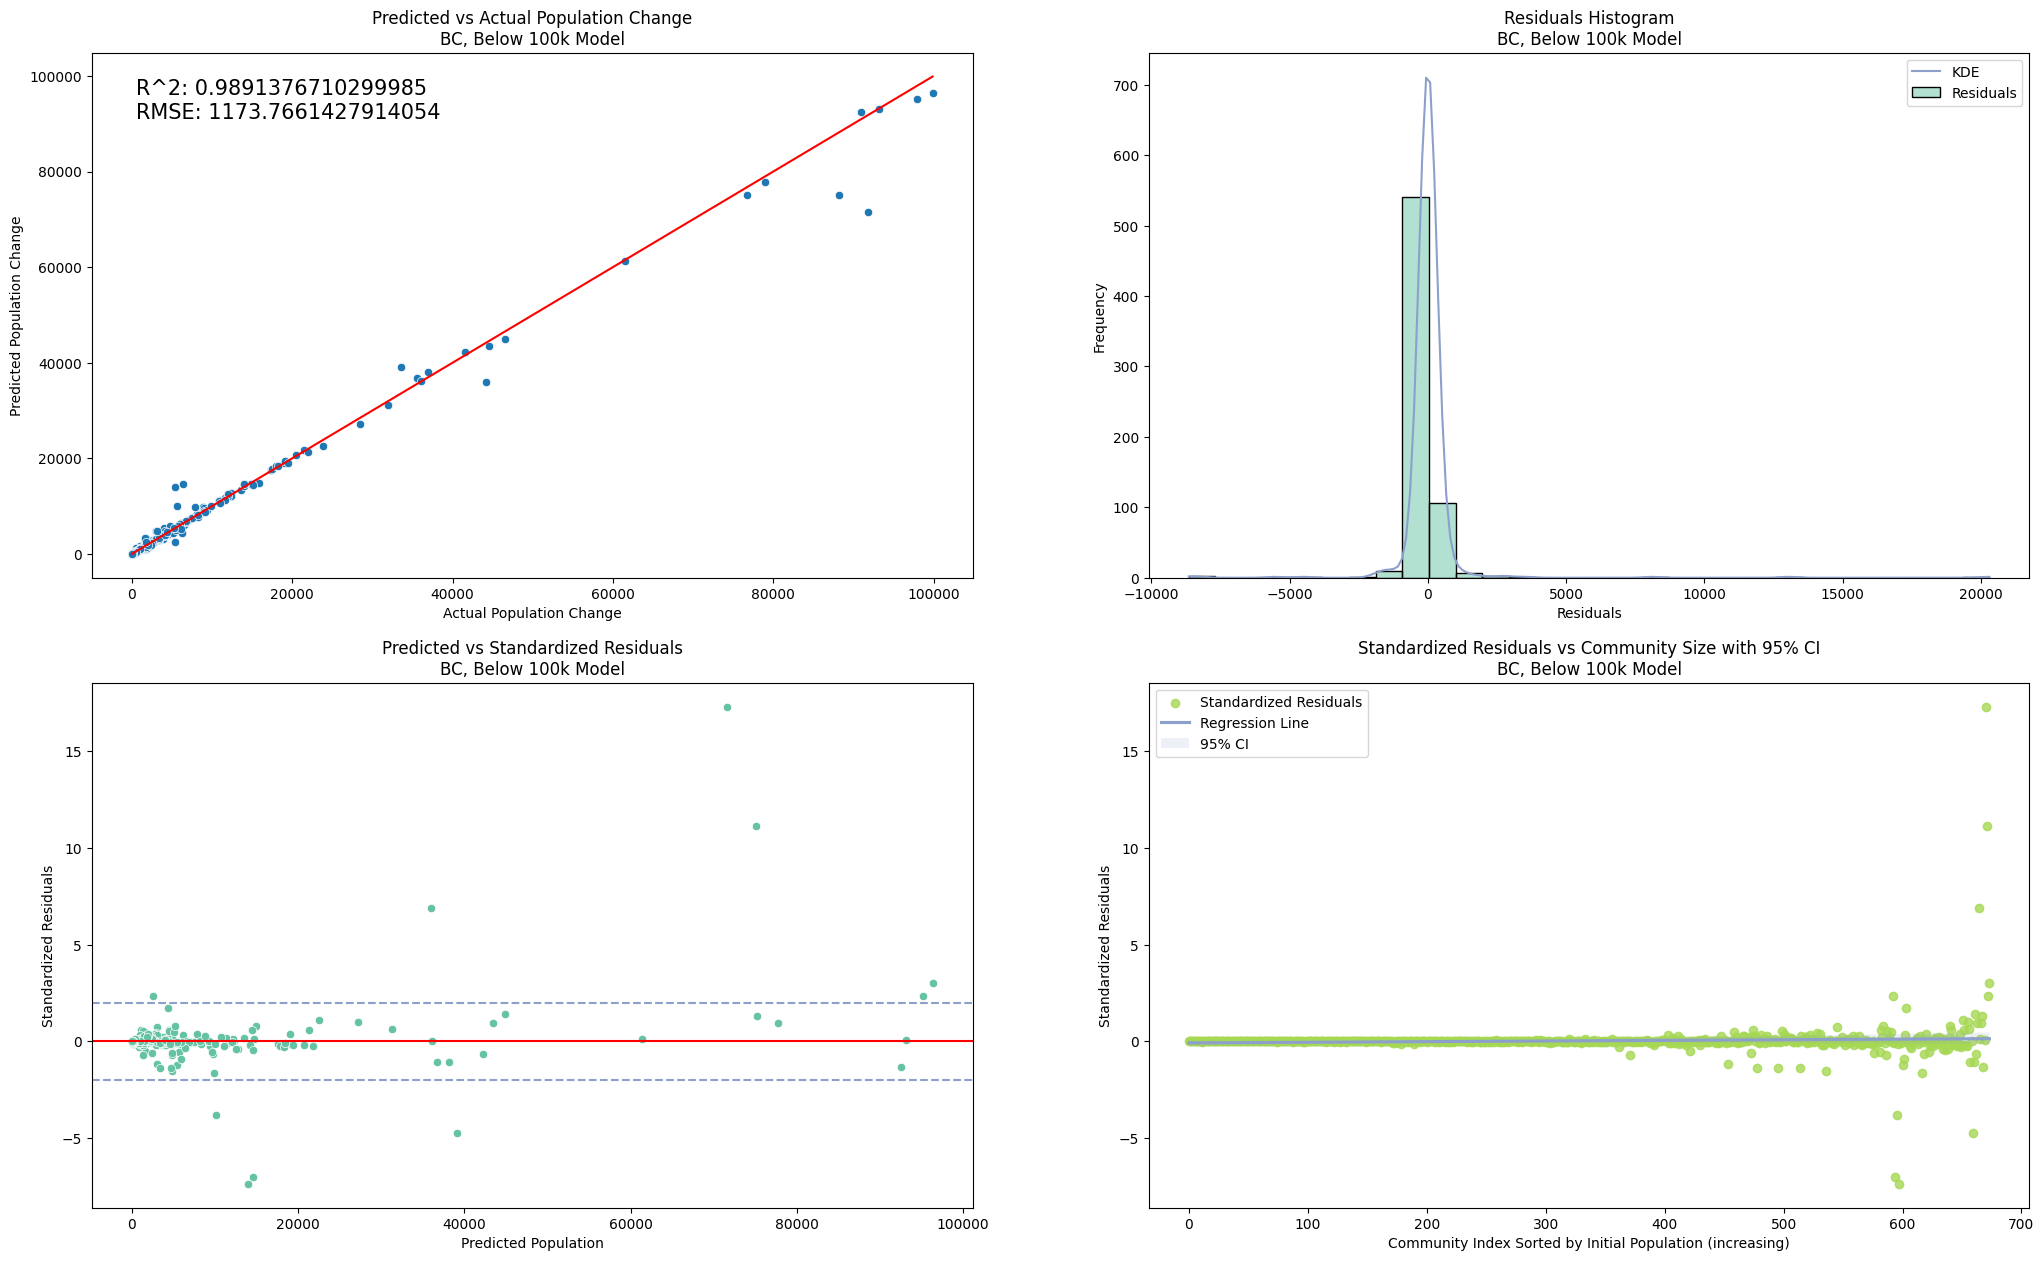

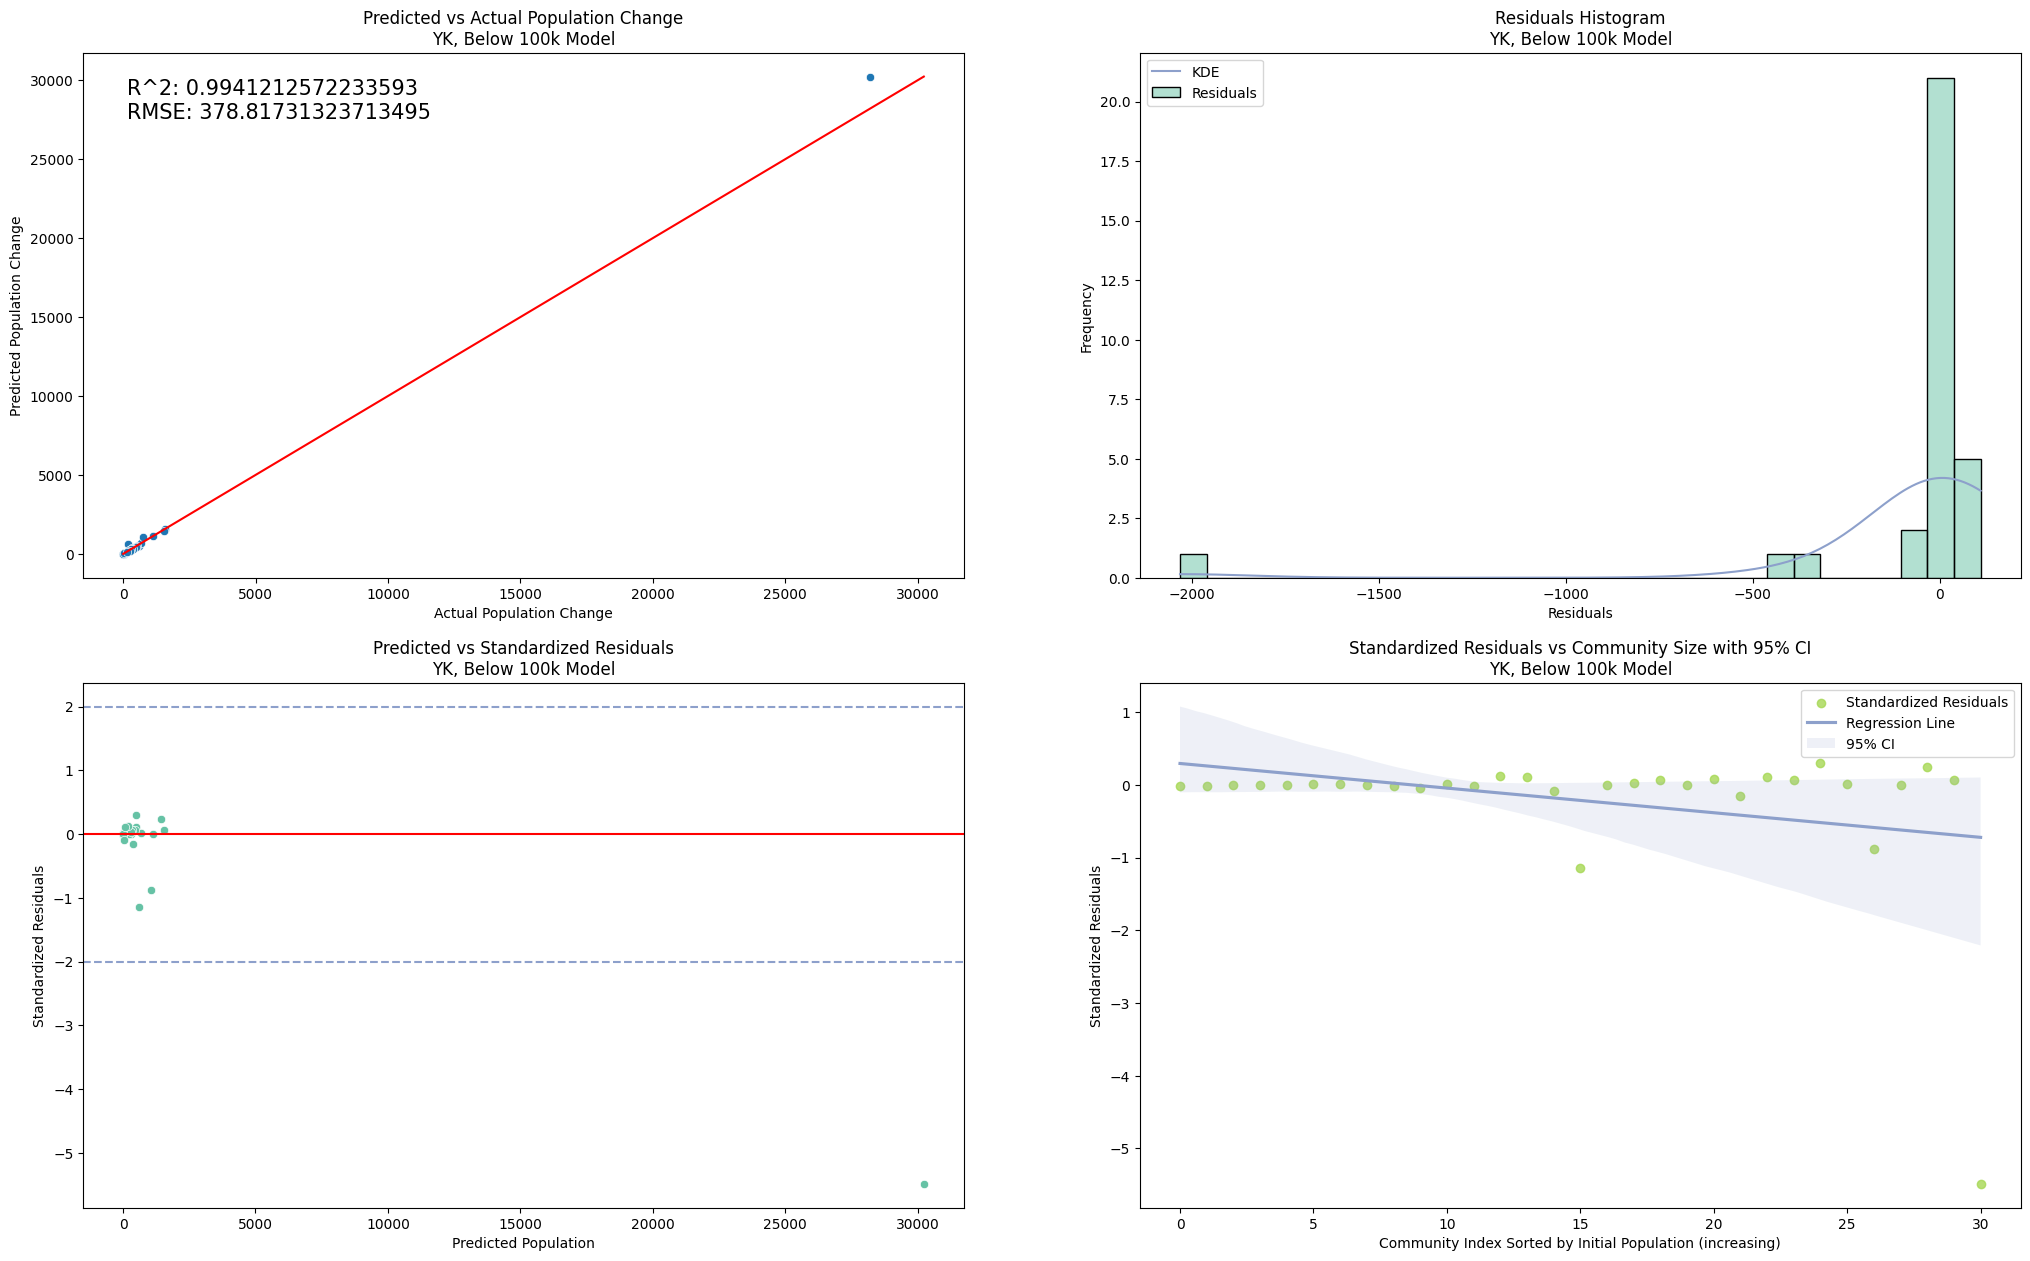

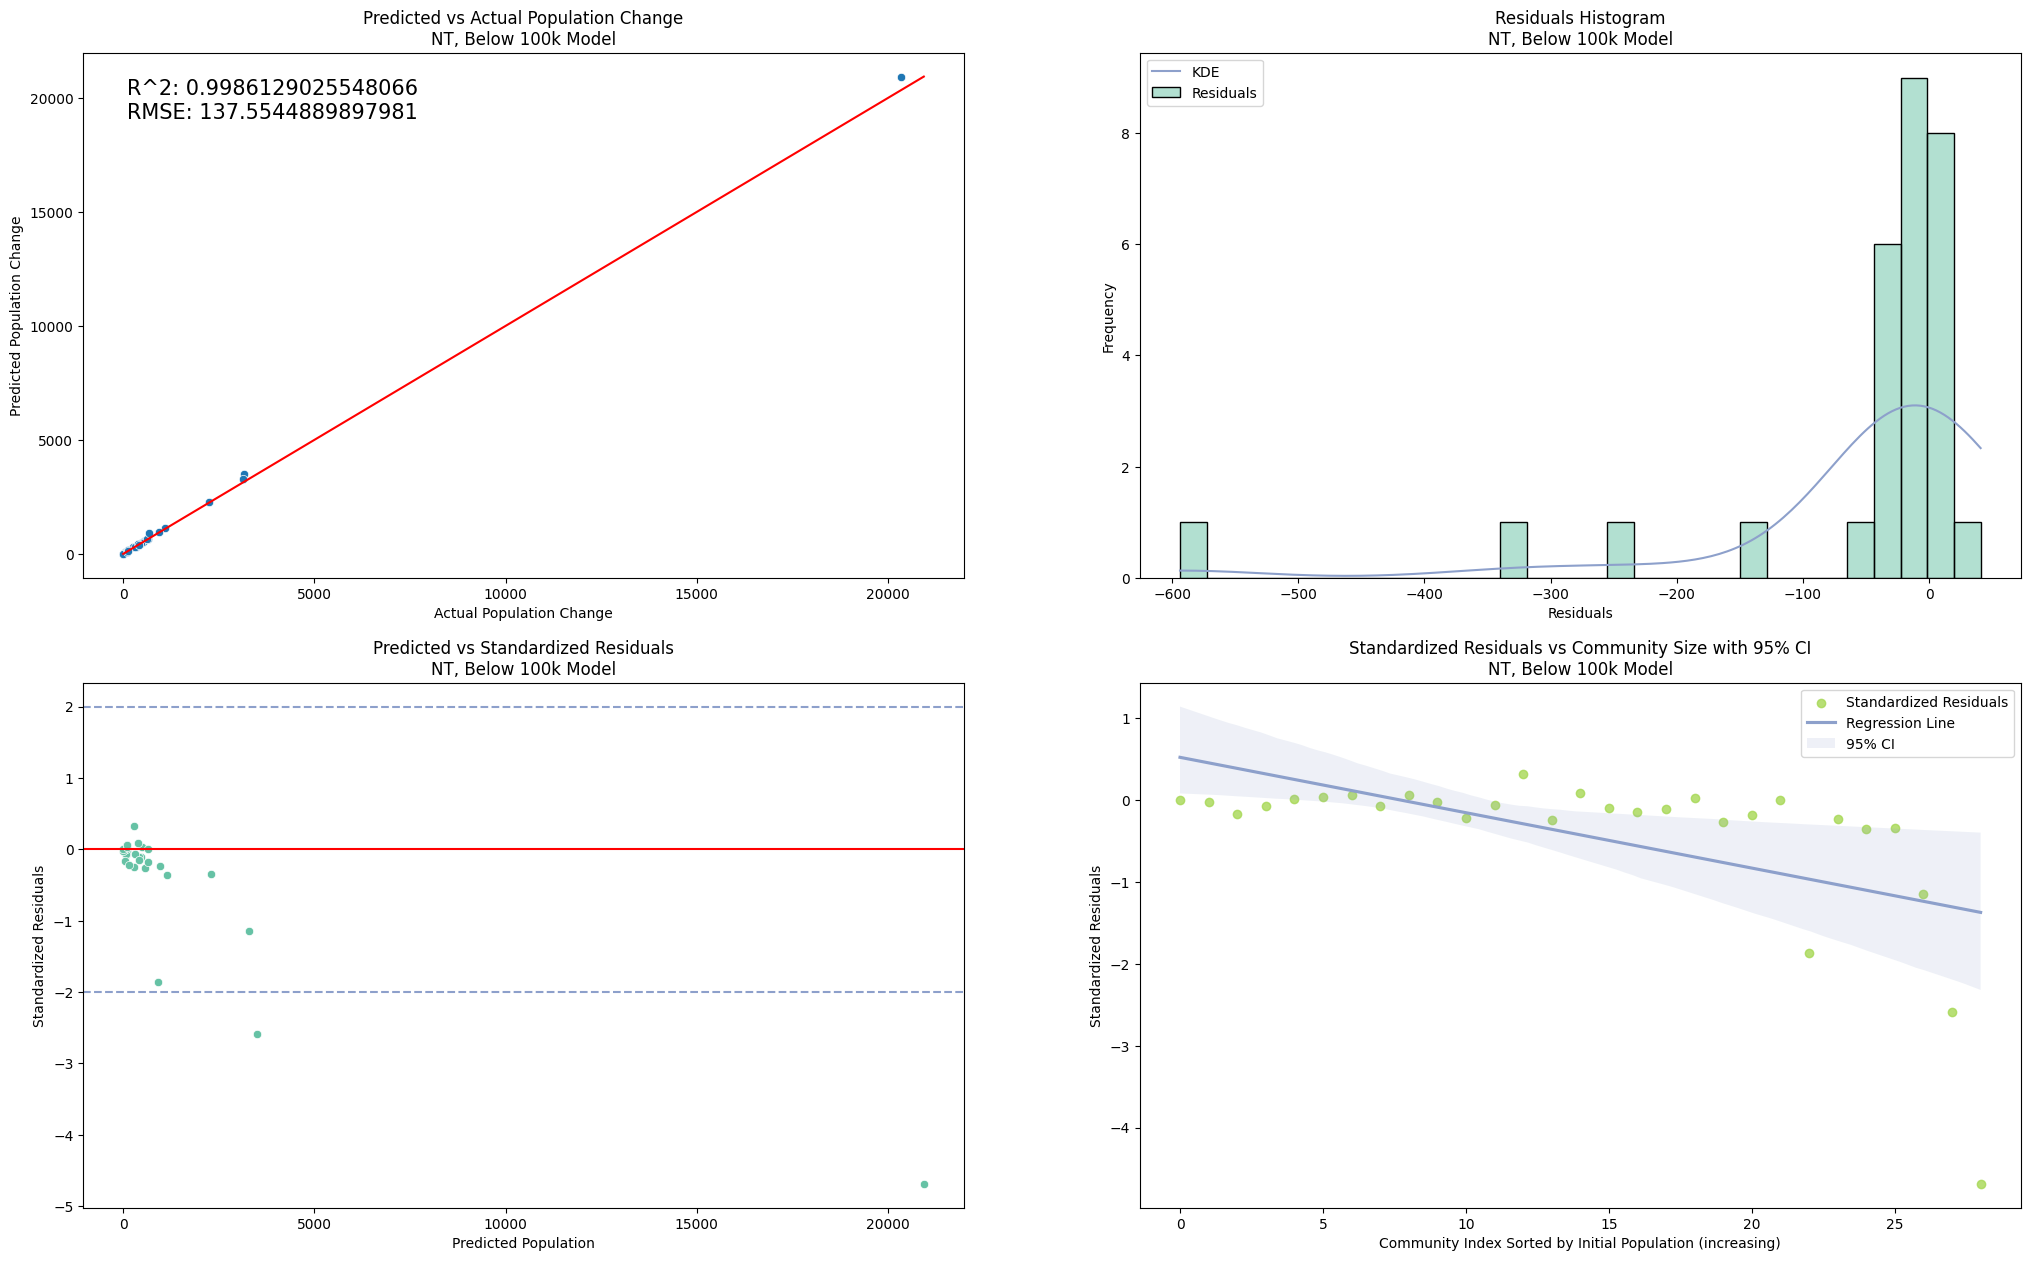

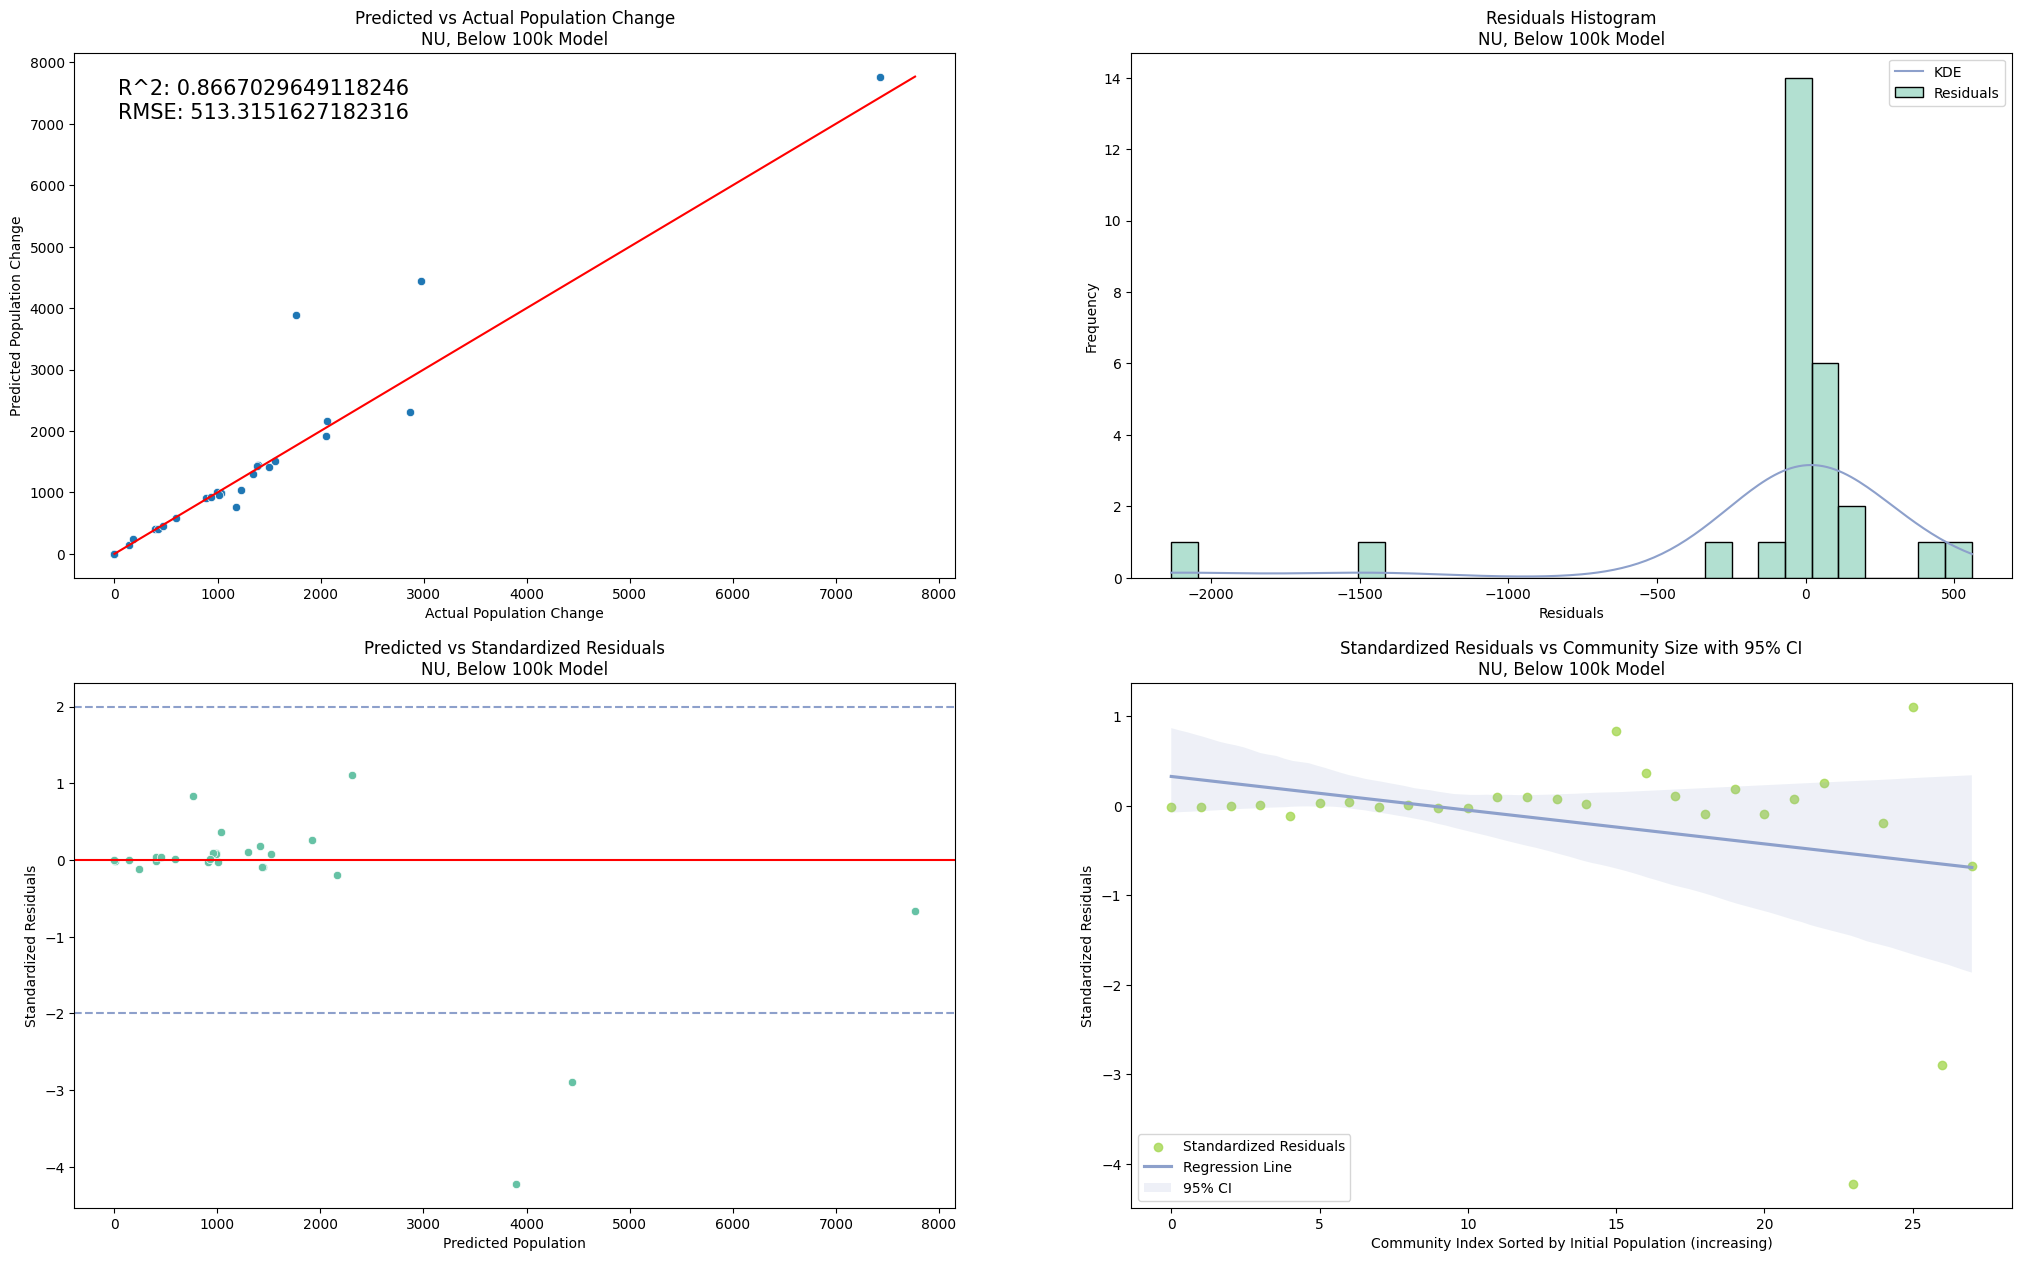

In [35]:
# Now let's trim down the dataset to only include communities with a population of less than 100,000
# and redo our prediction using the below100k model
# If we trim out the 2016 data, the dataPrep function call inside of predictProvinces will do the work for the 2021 data

below100k2016 = []

for entry in import2016:
    below100k2016.append({'name': entry['name'], 'data': entry['data'][entry['data']['Population, 2016'] < 100000]})
    

resultsBelow100k = predictProvinces(below100k2016, import2021, model = below100kModel)

visualizeResults(resultsBelow100k, dataLabel='Below 100k Model')





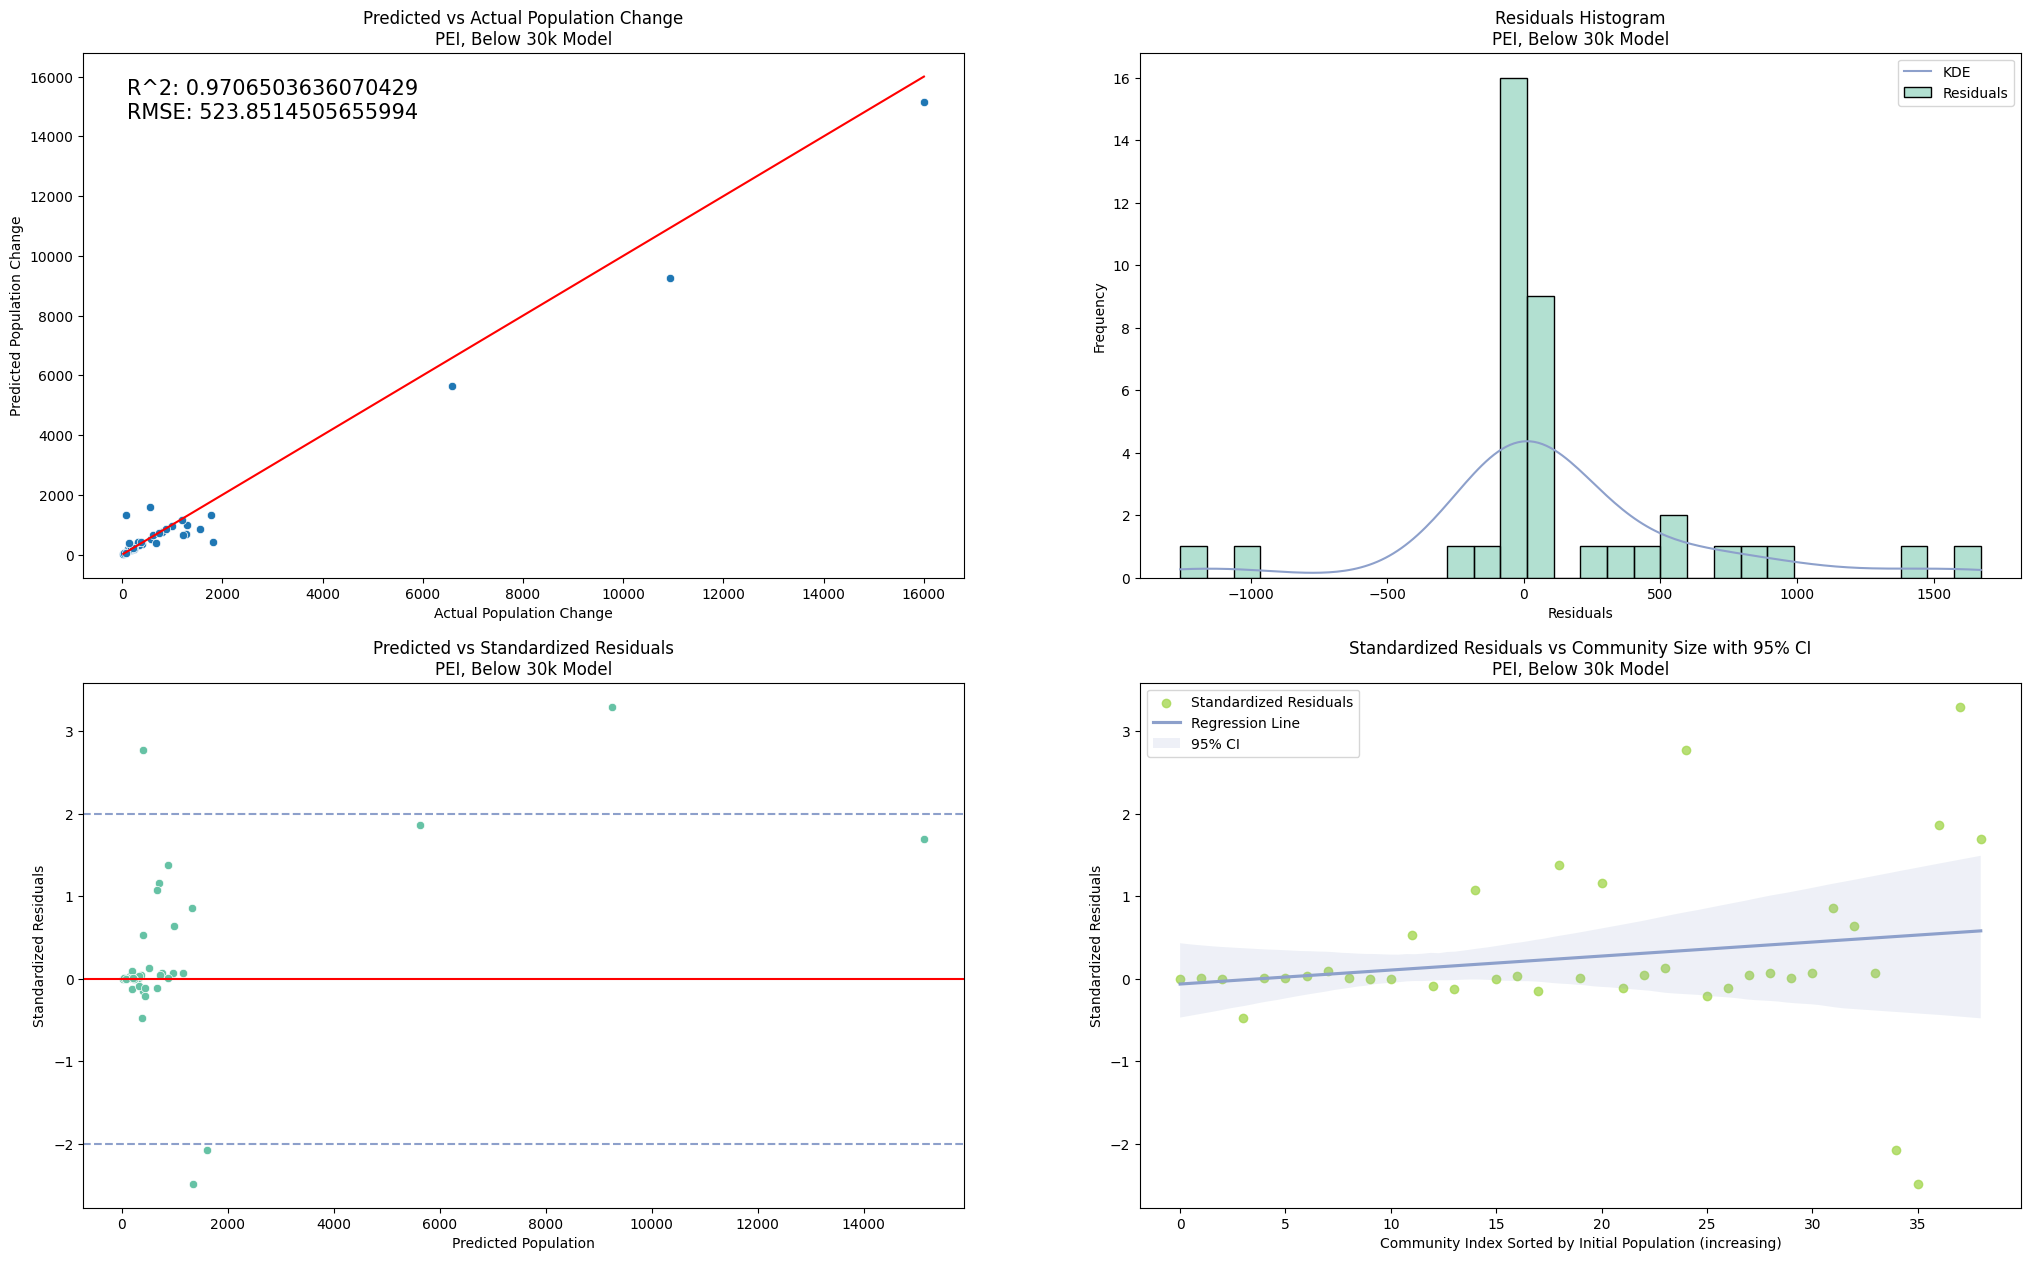

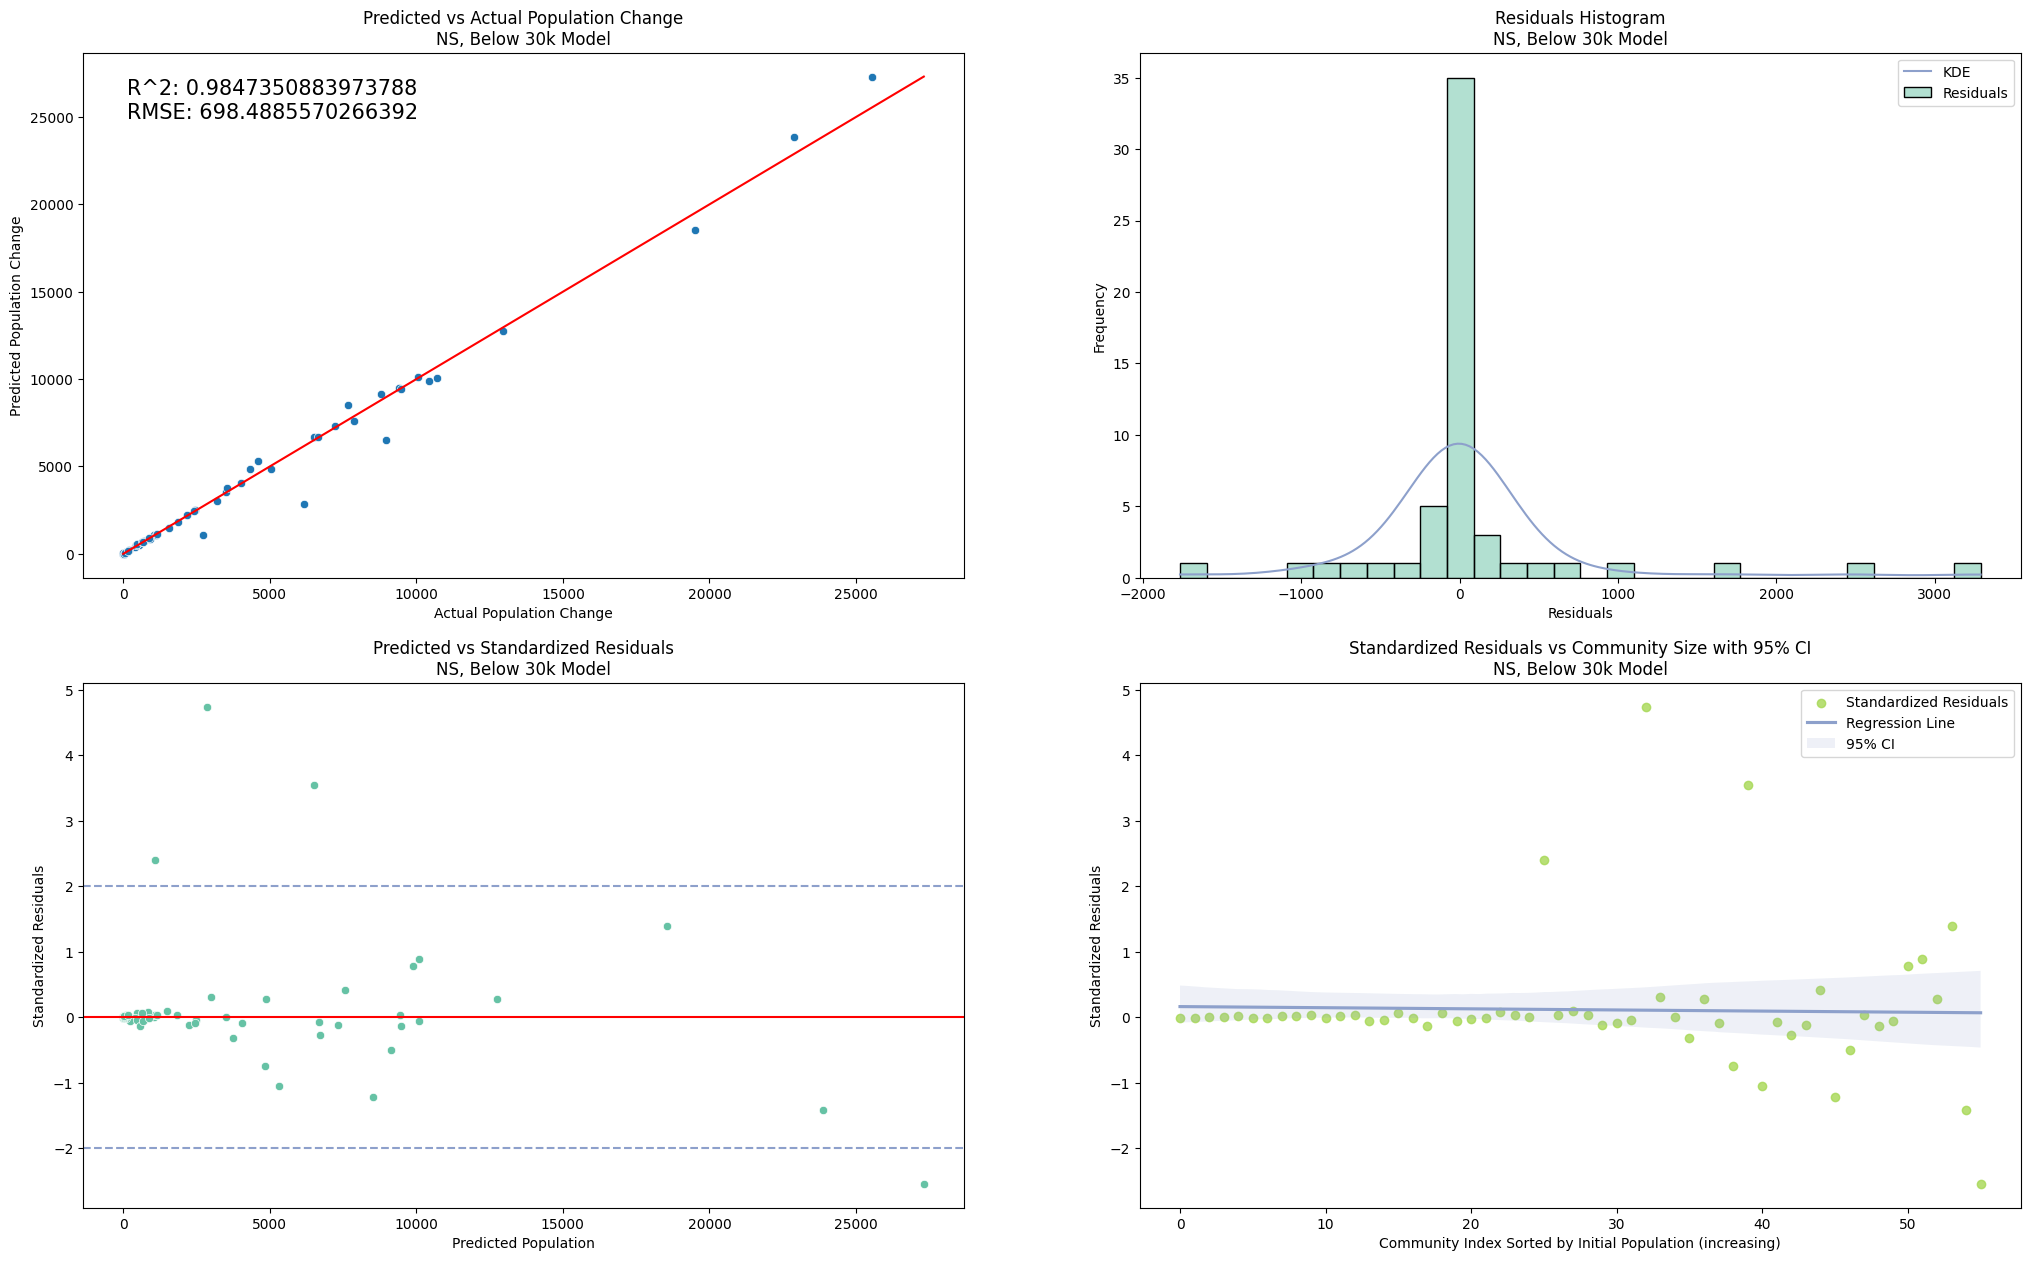

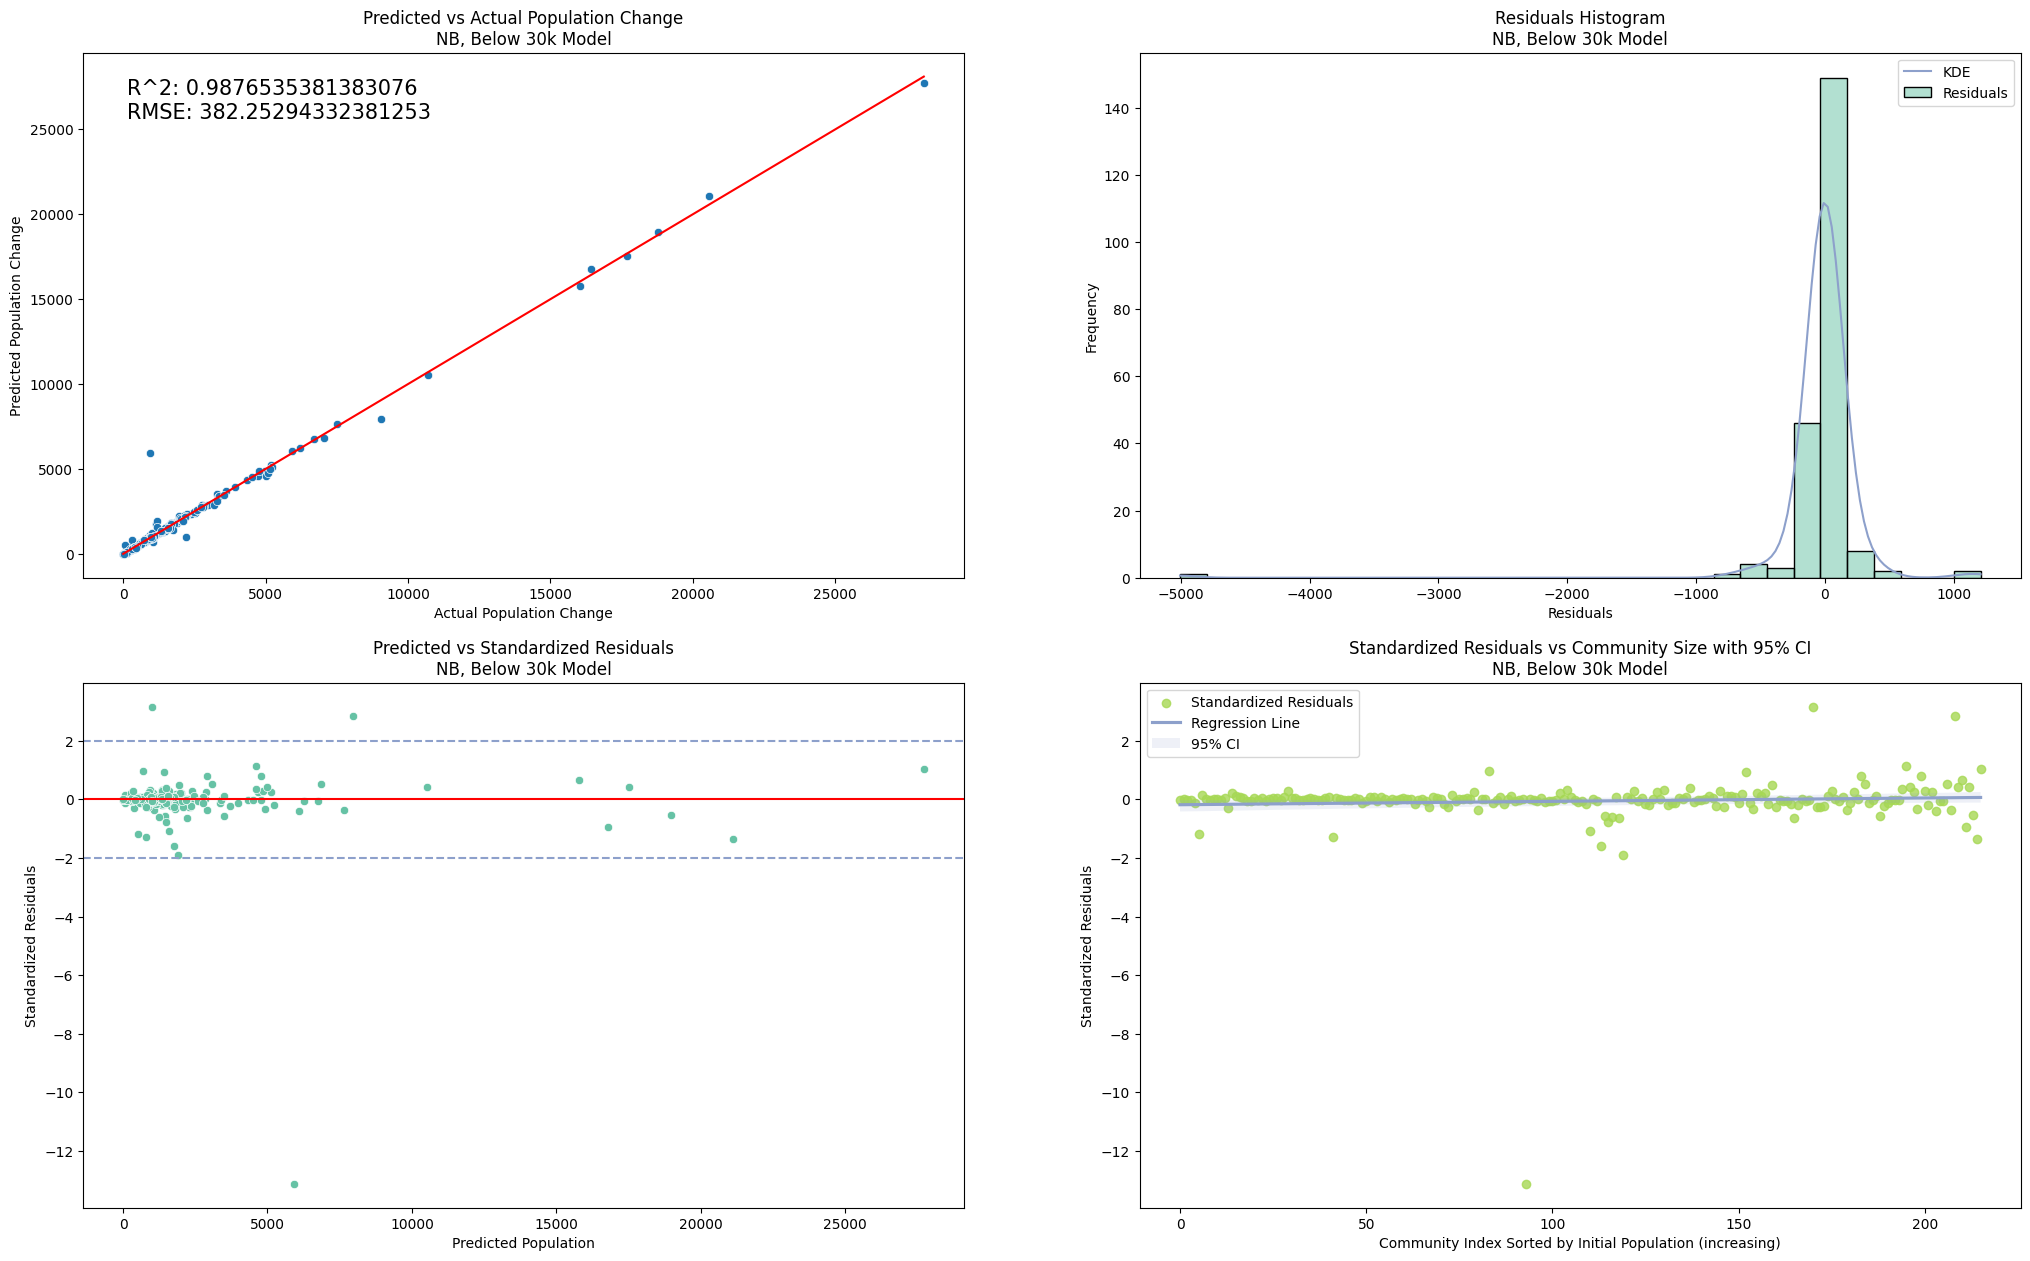

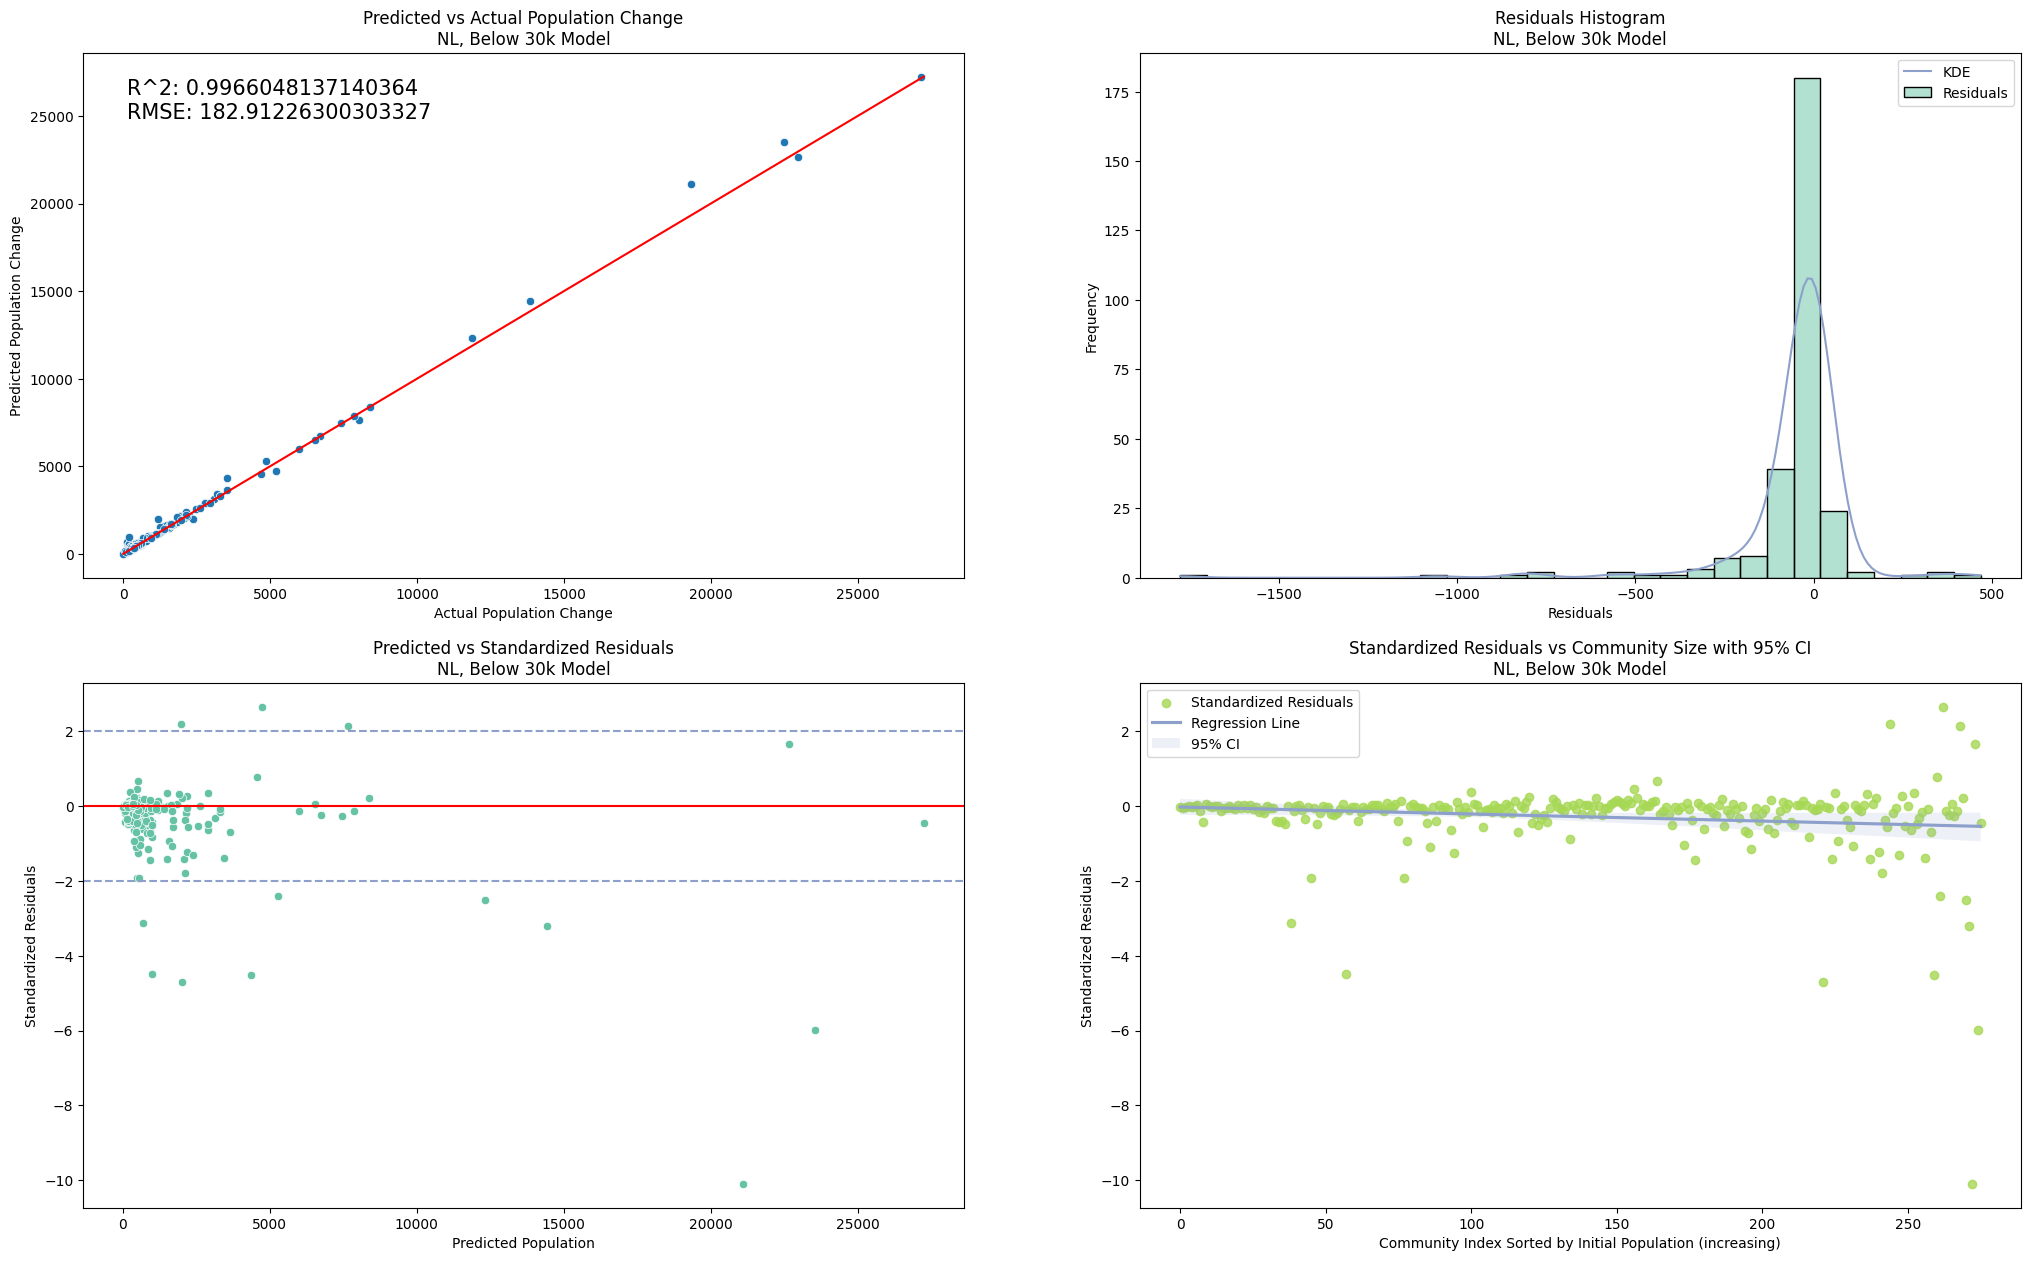

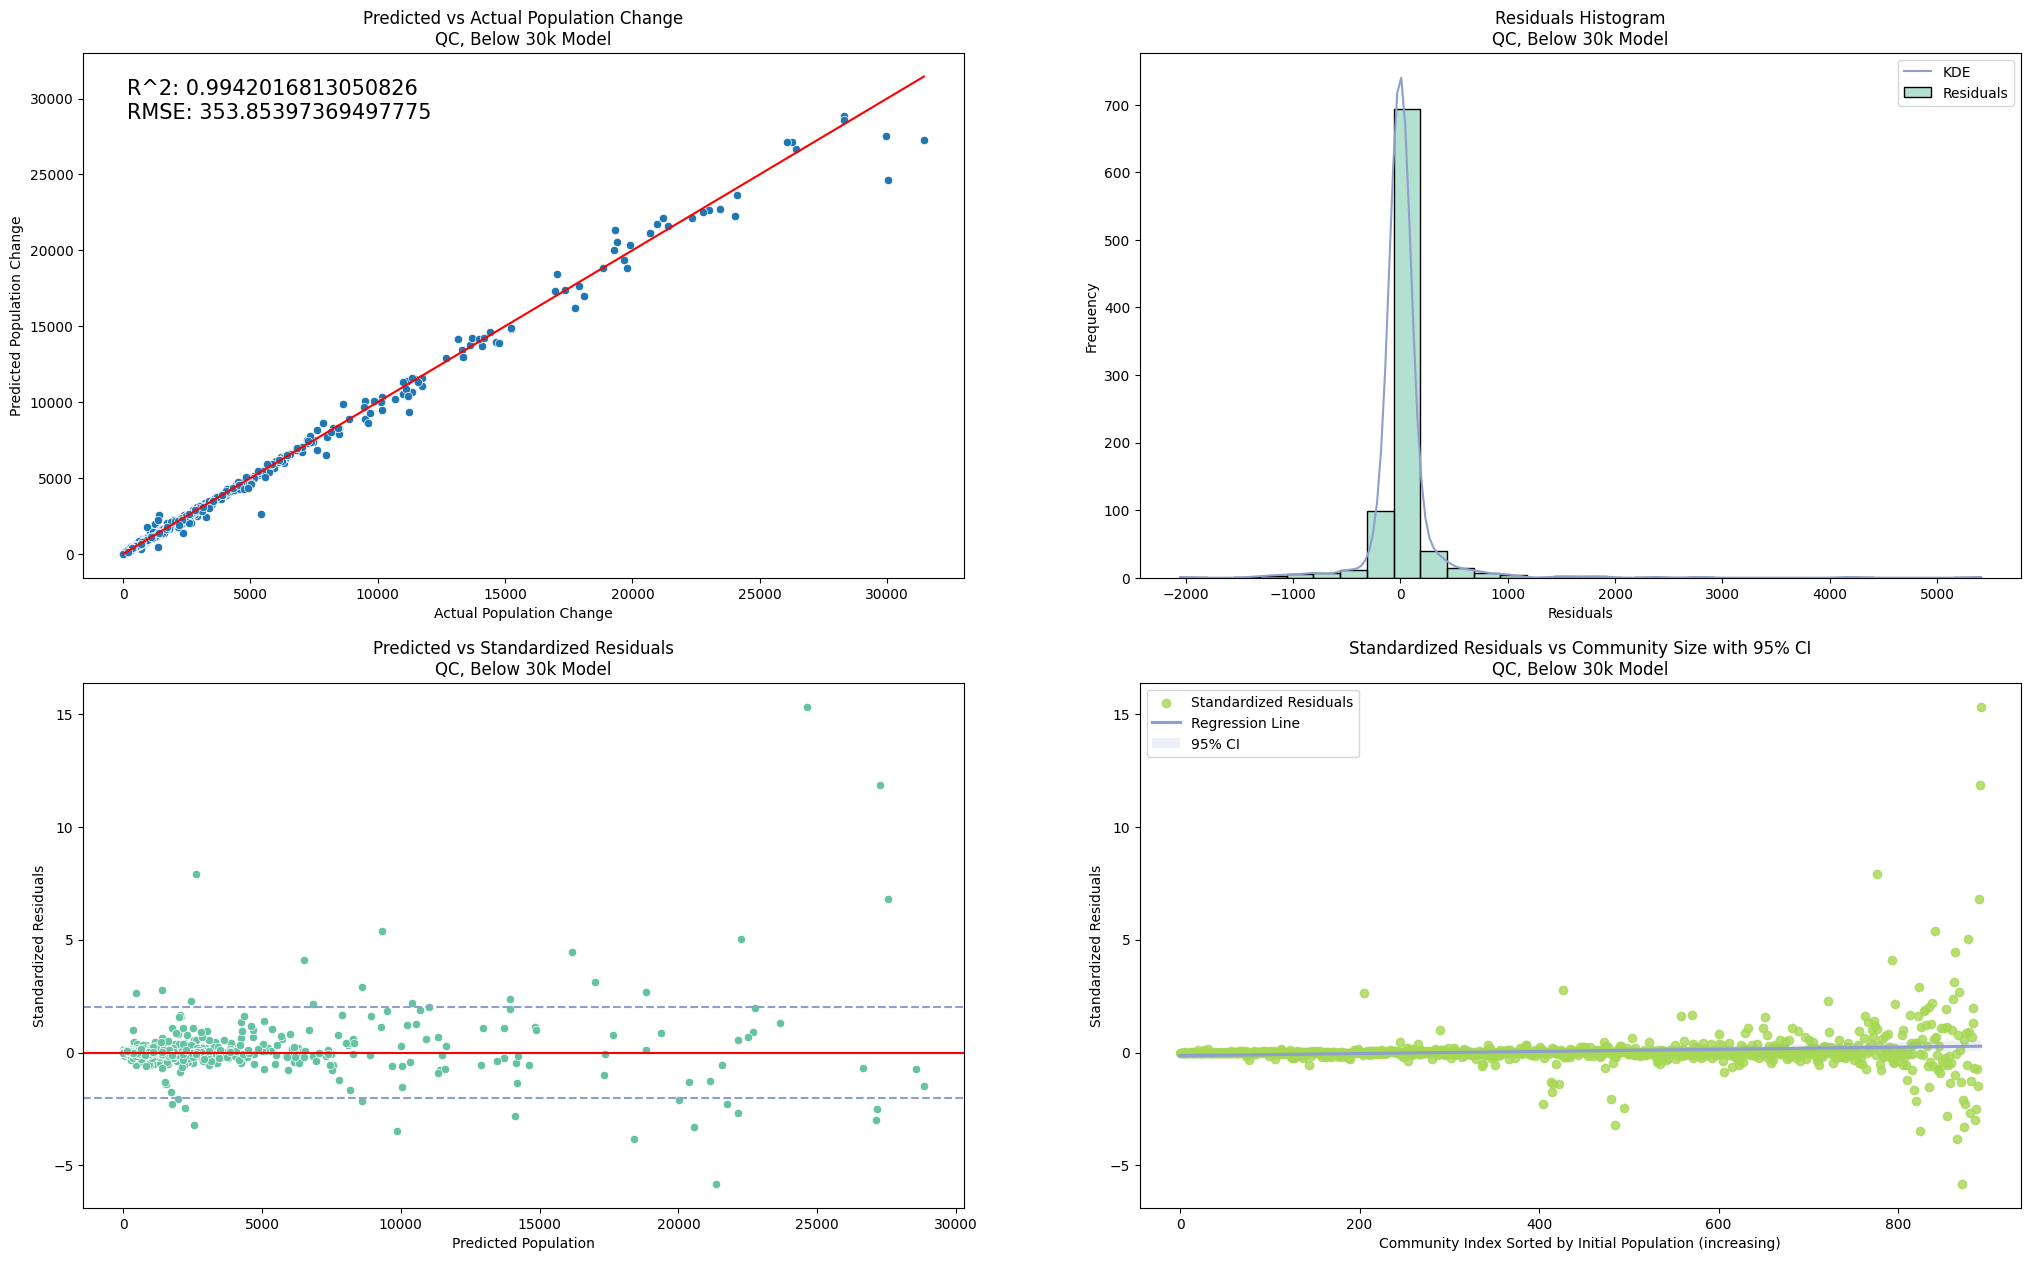

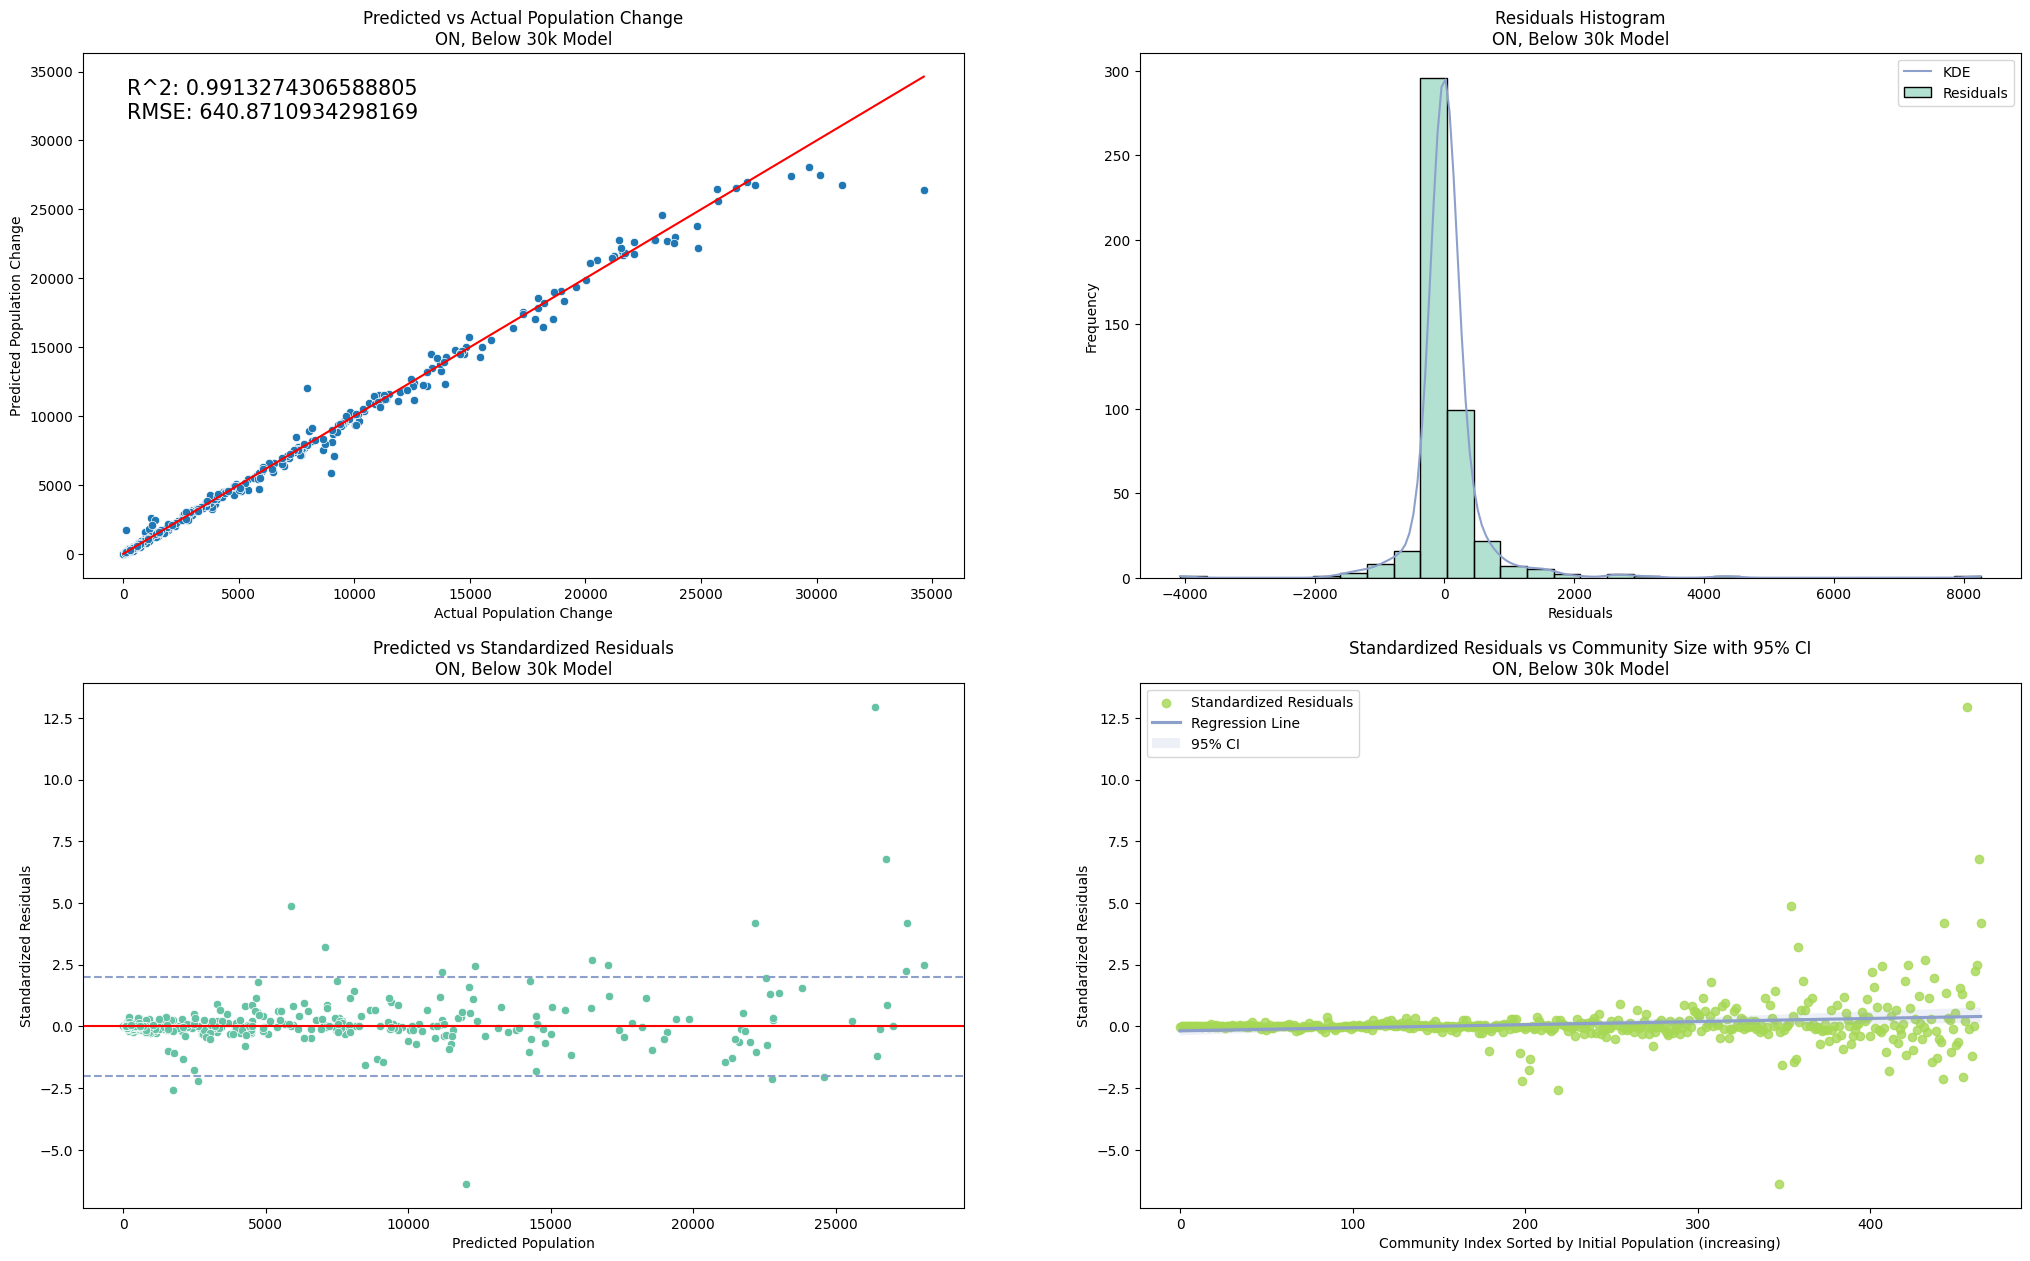

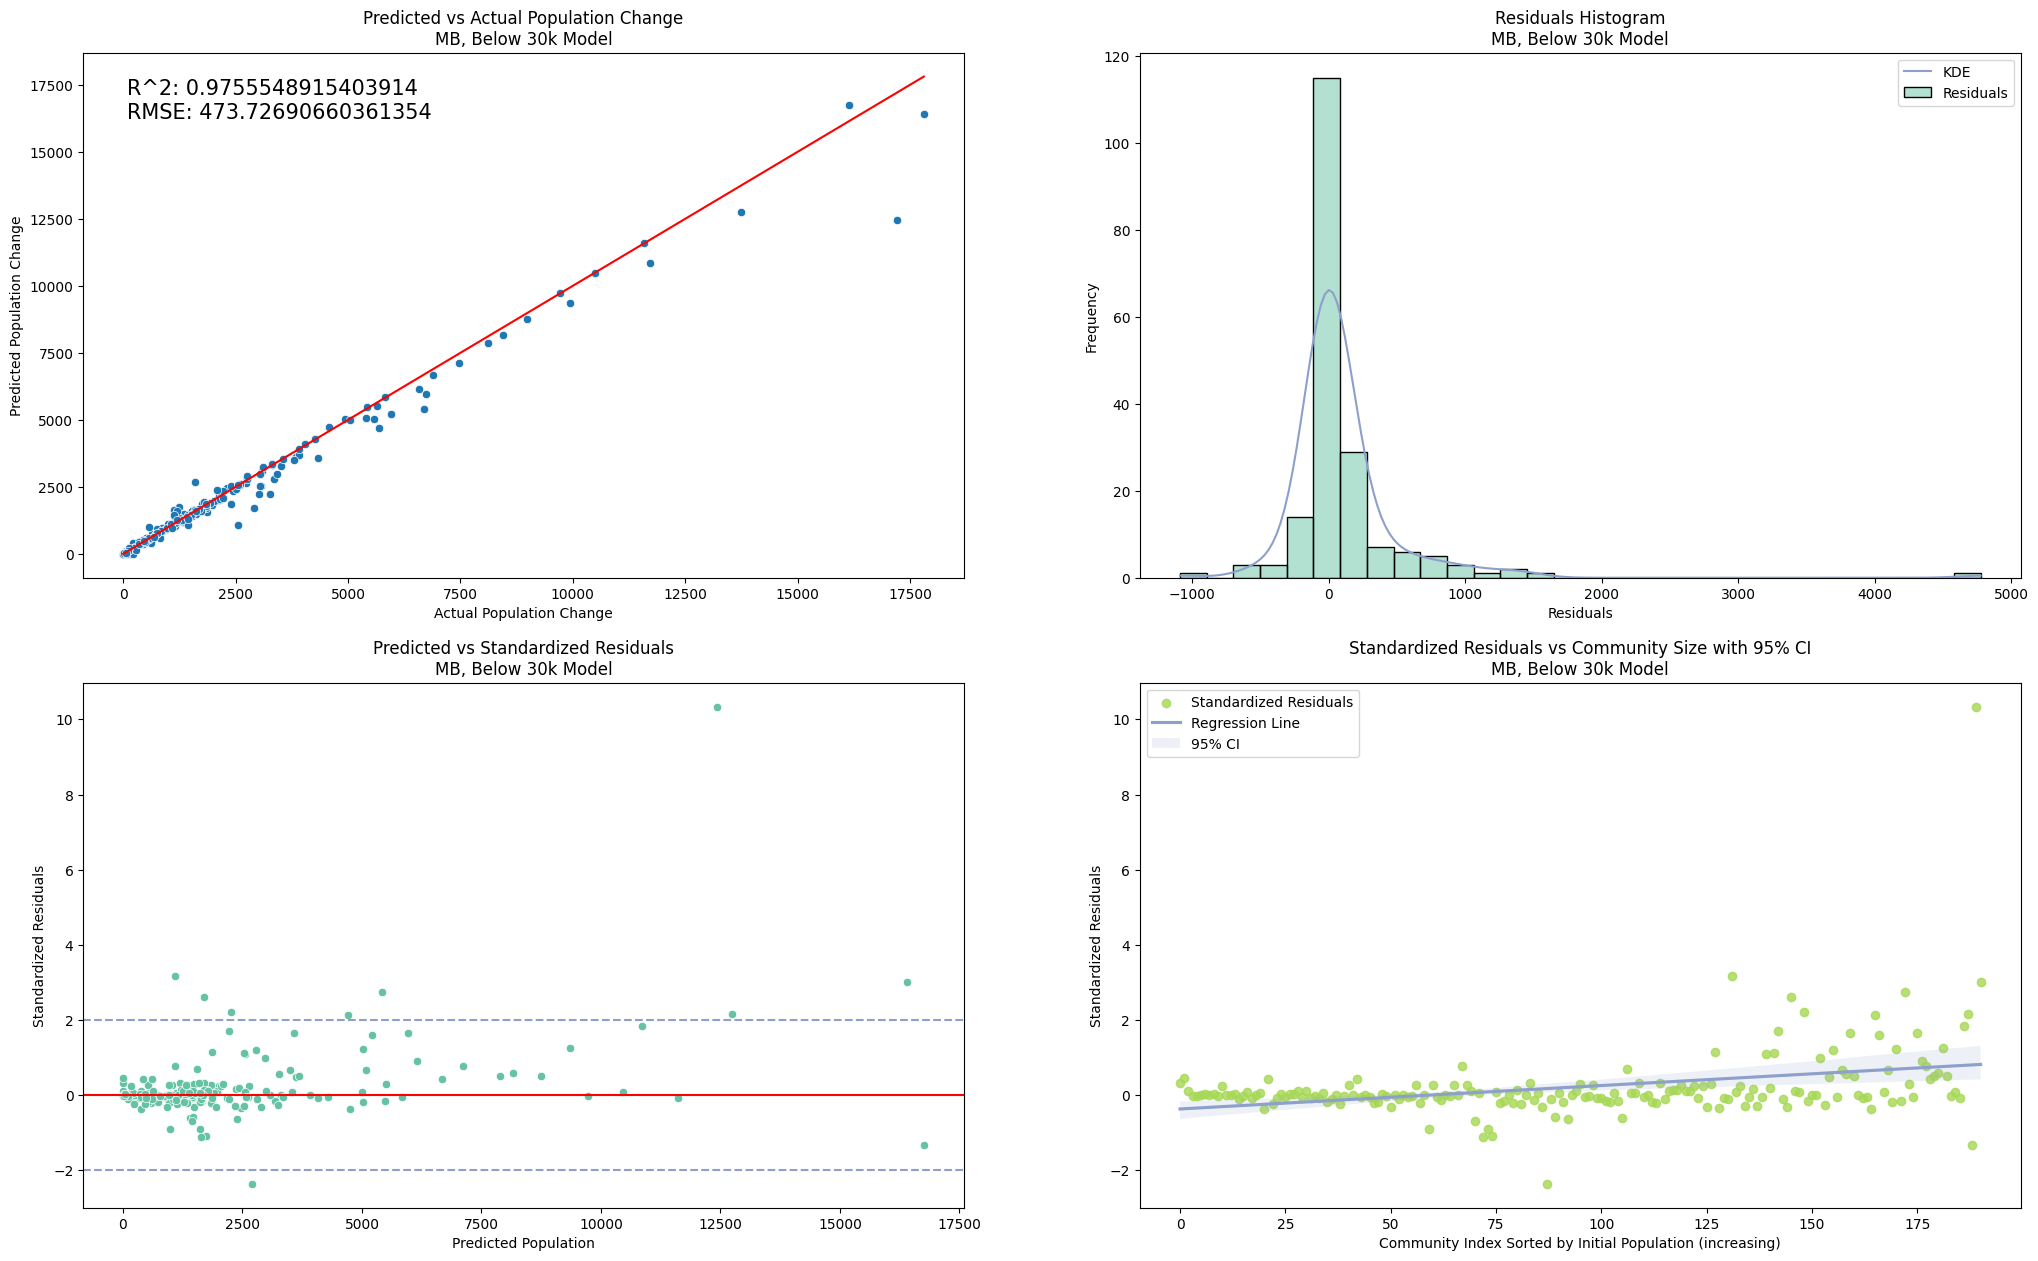

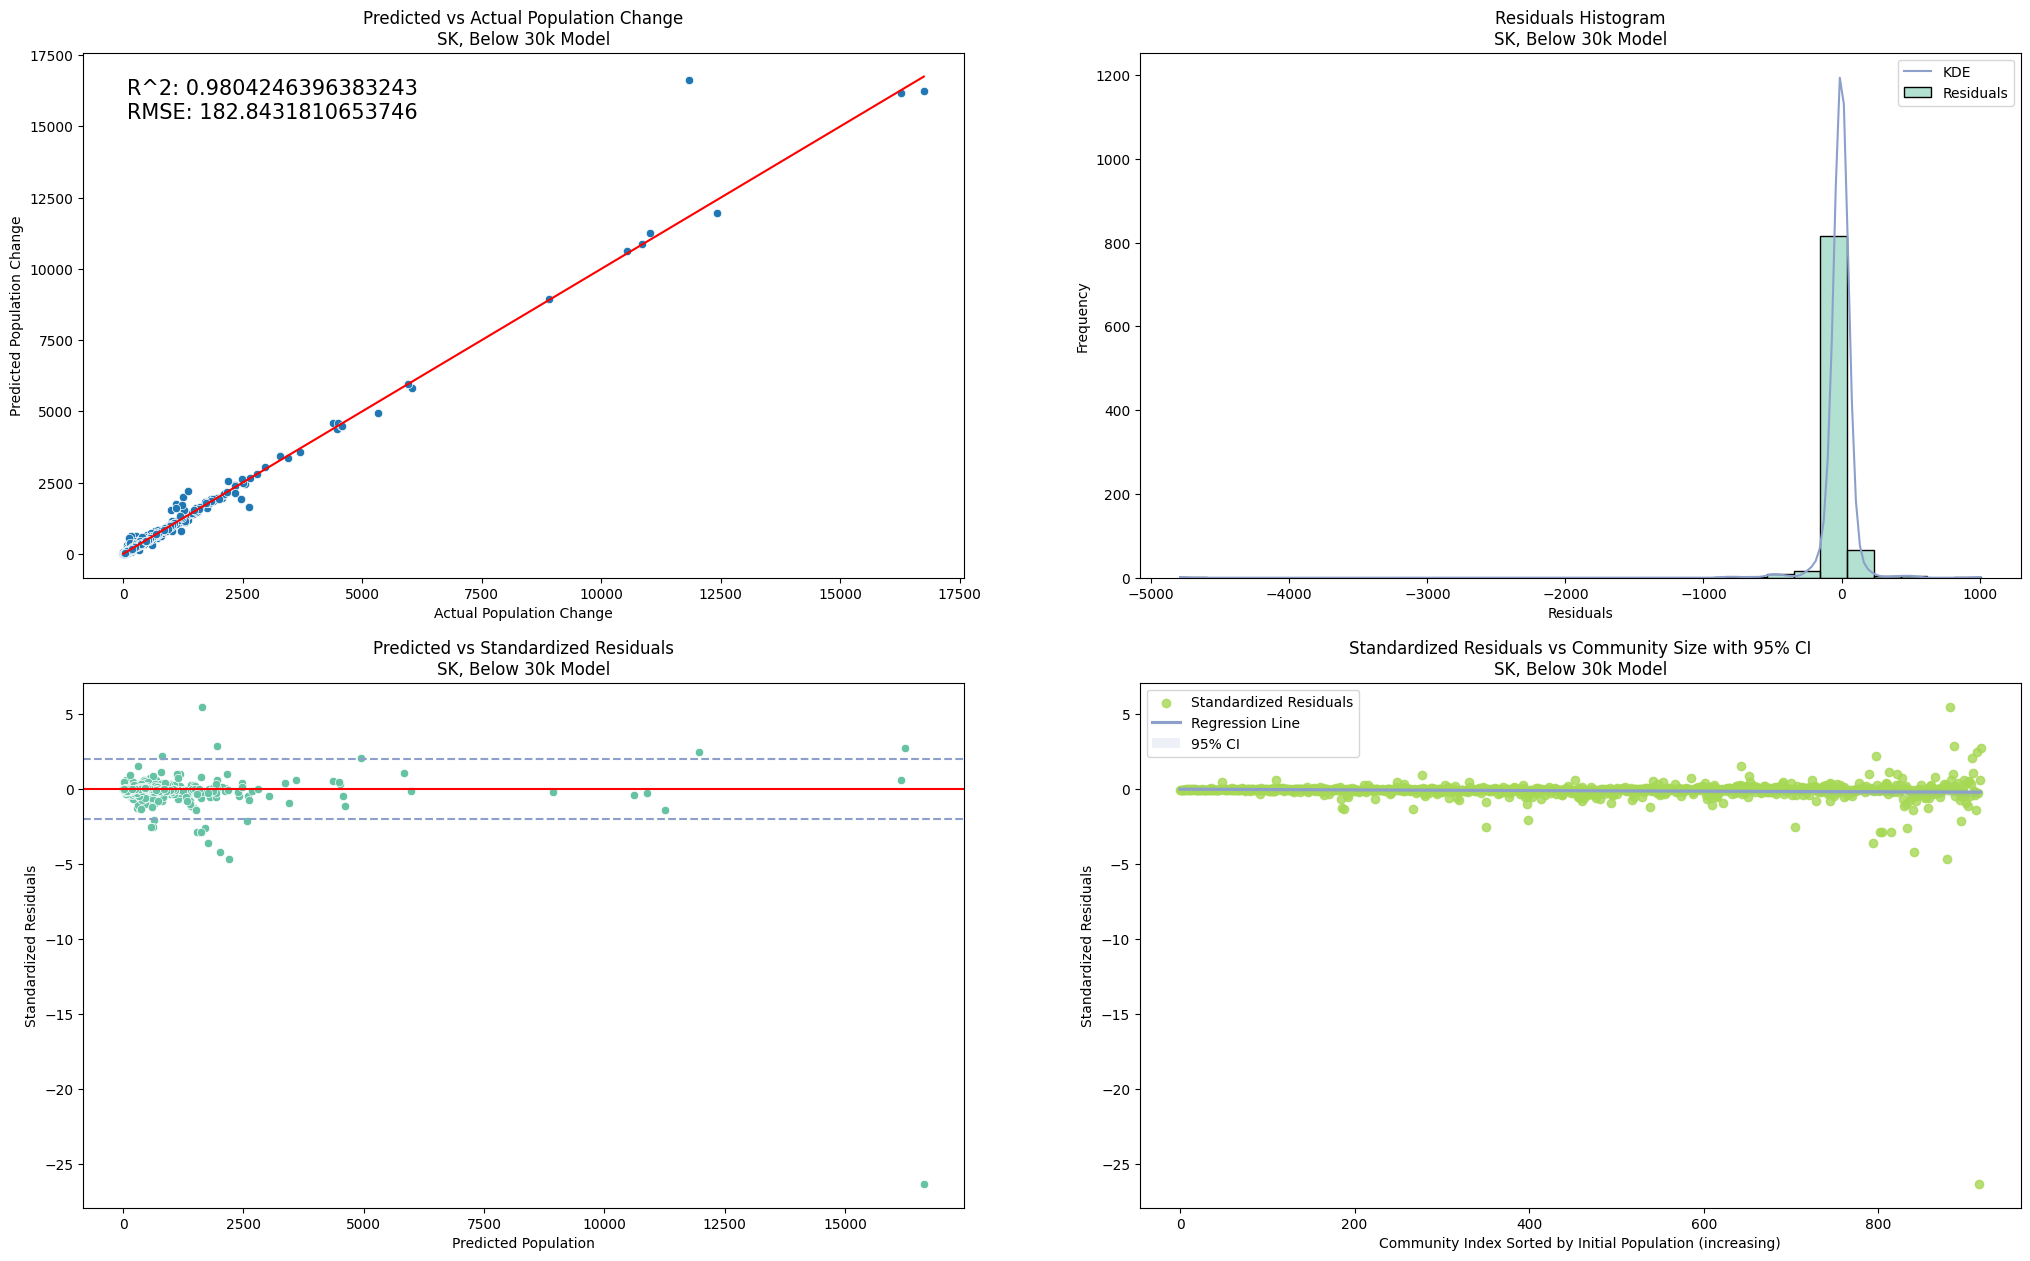

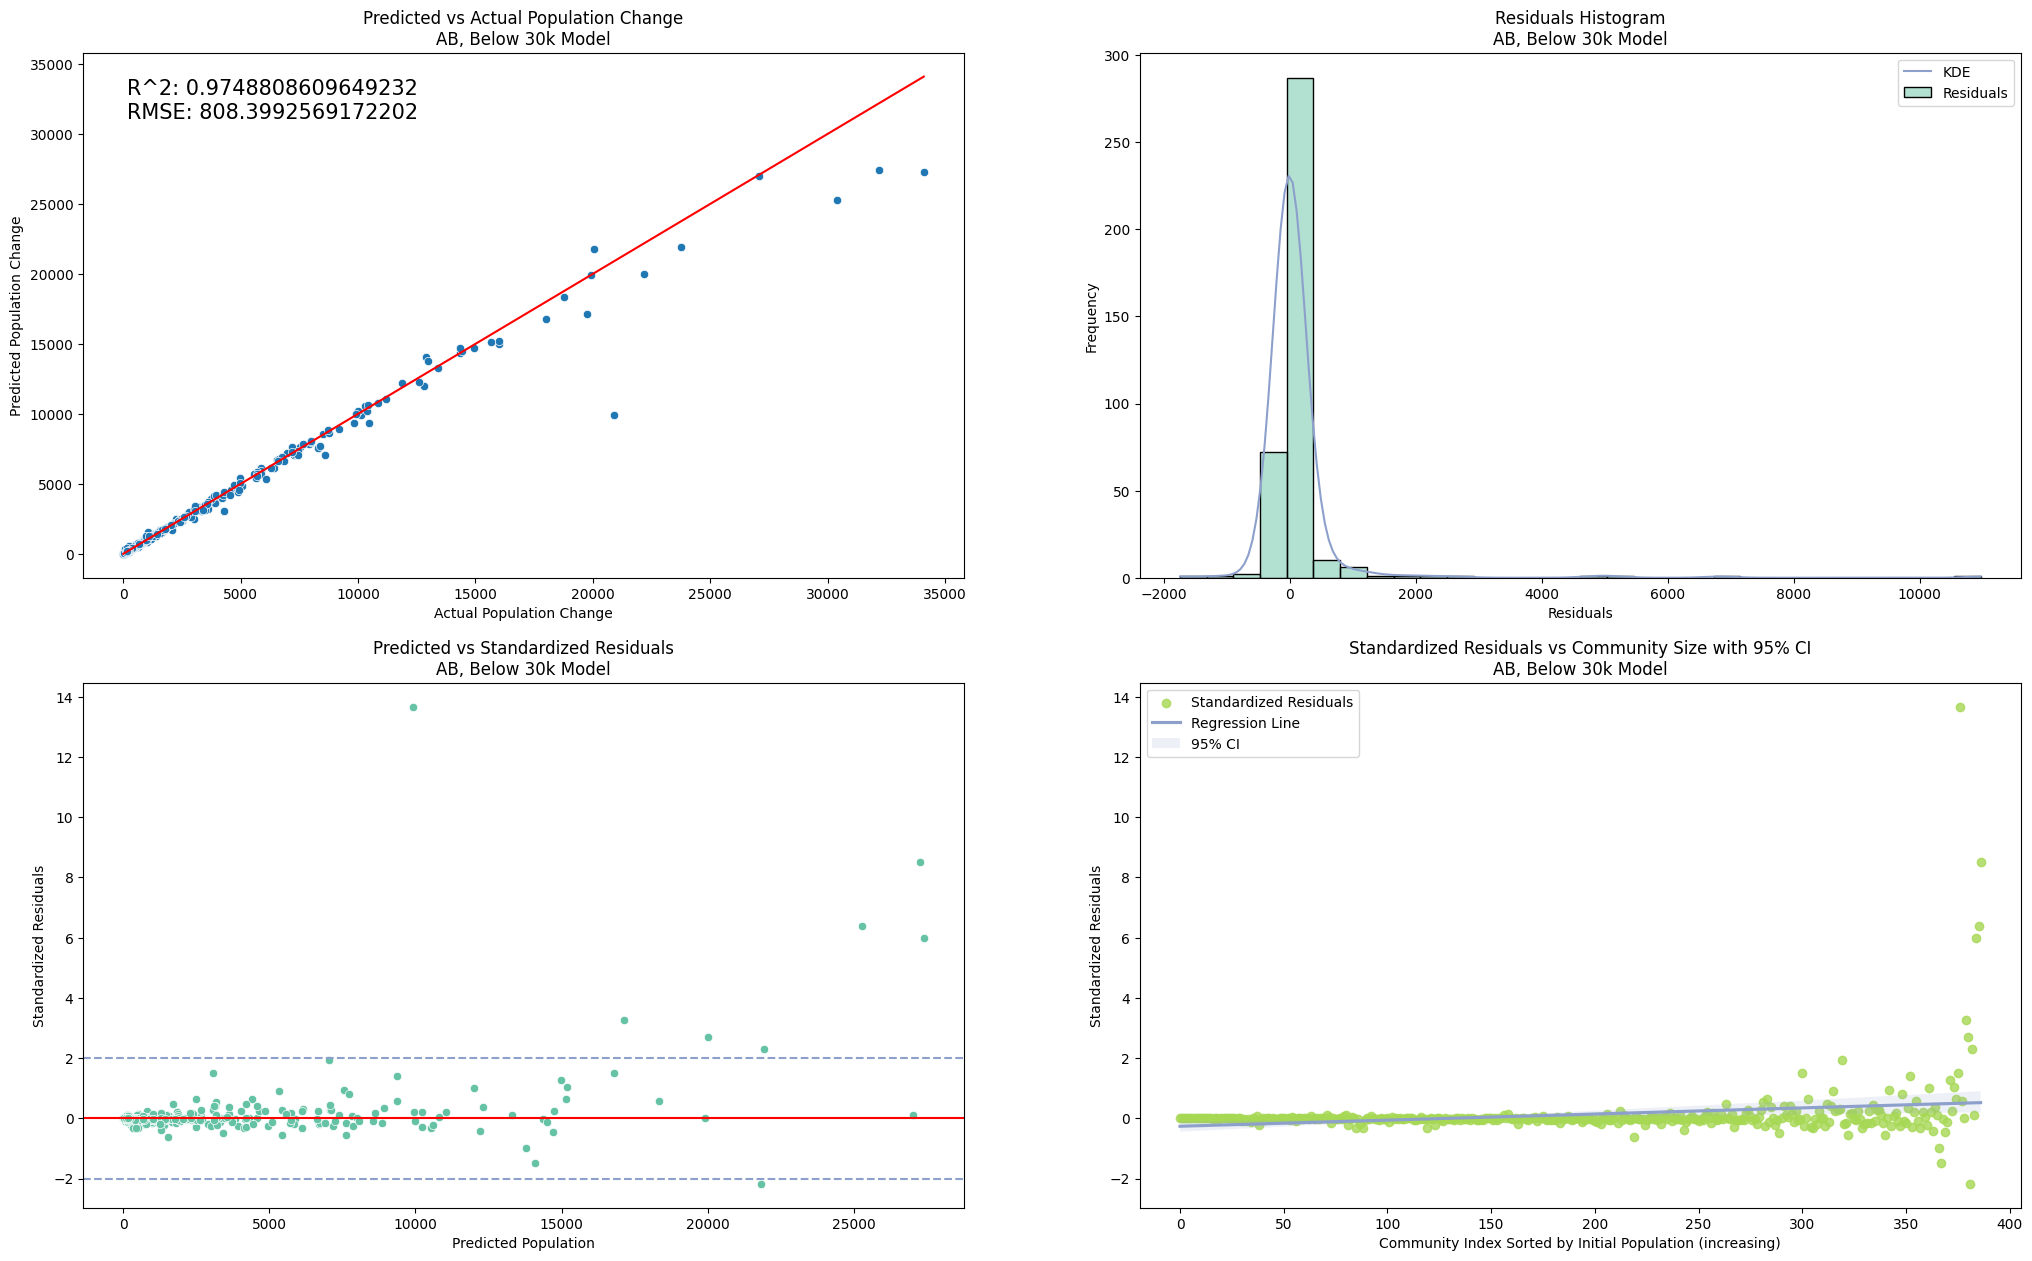

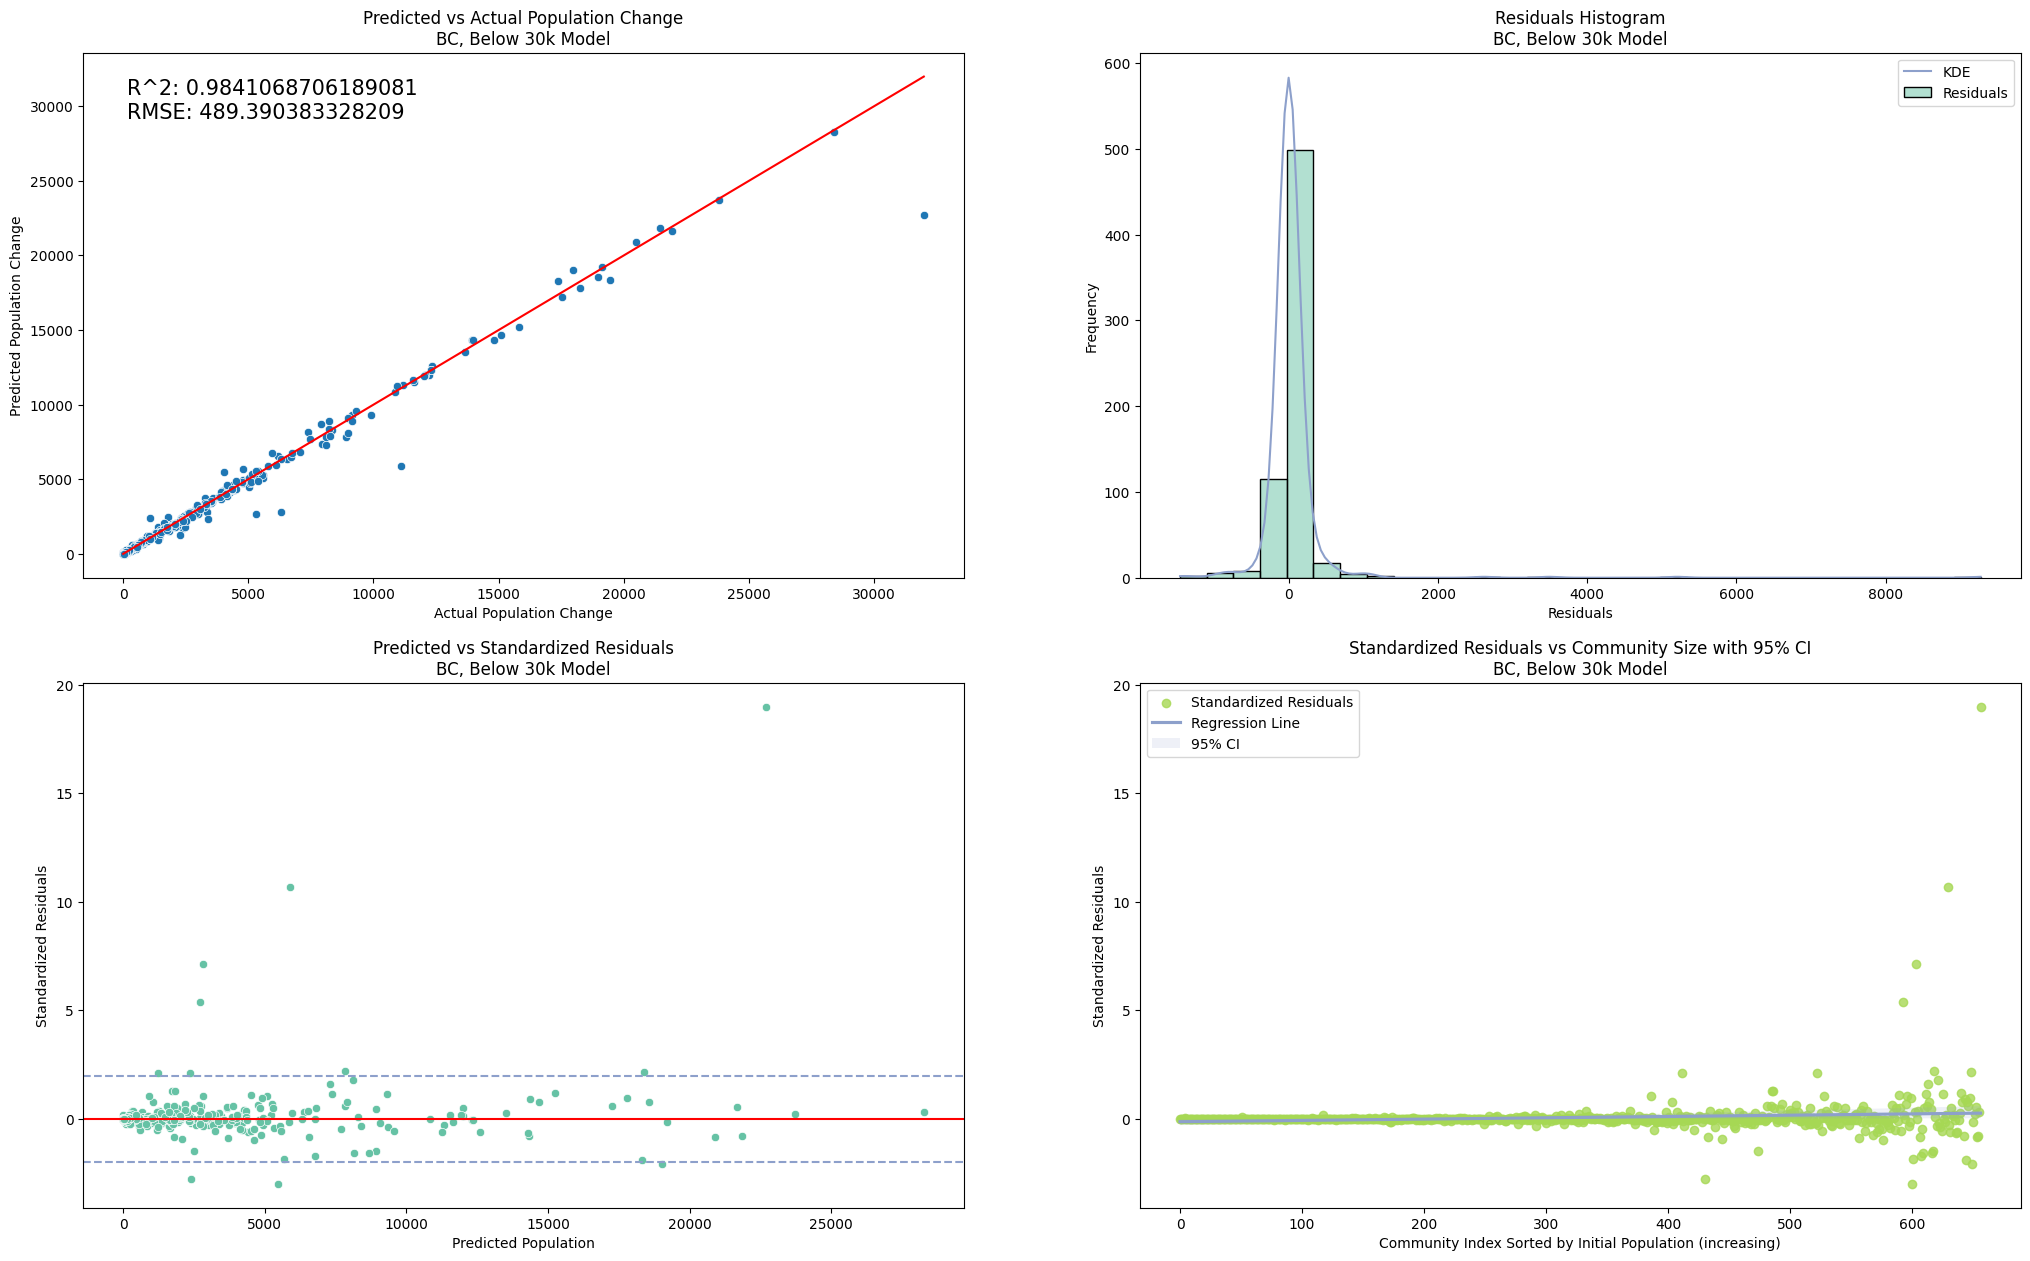

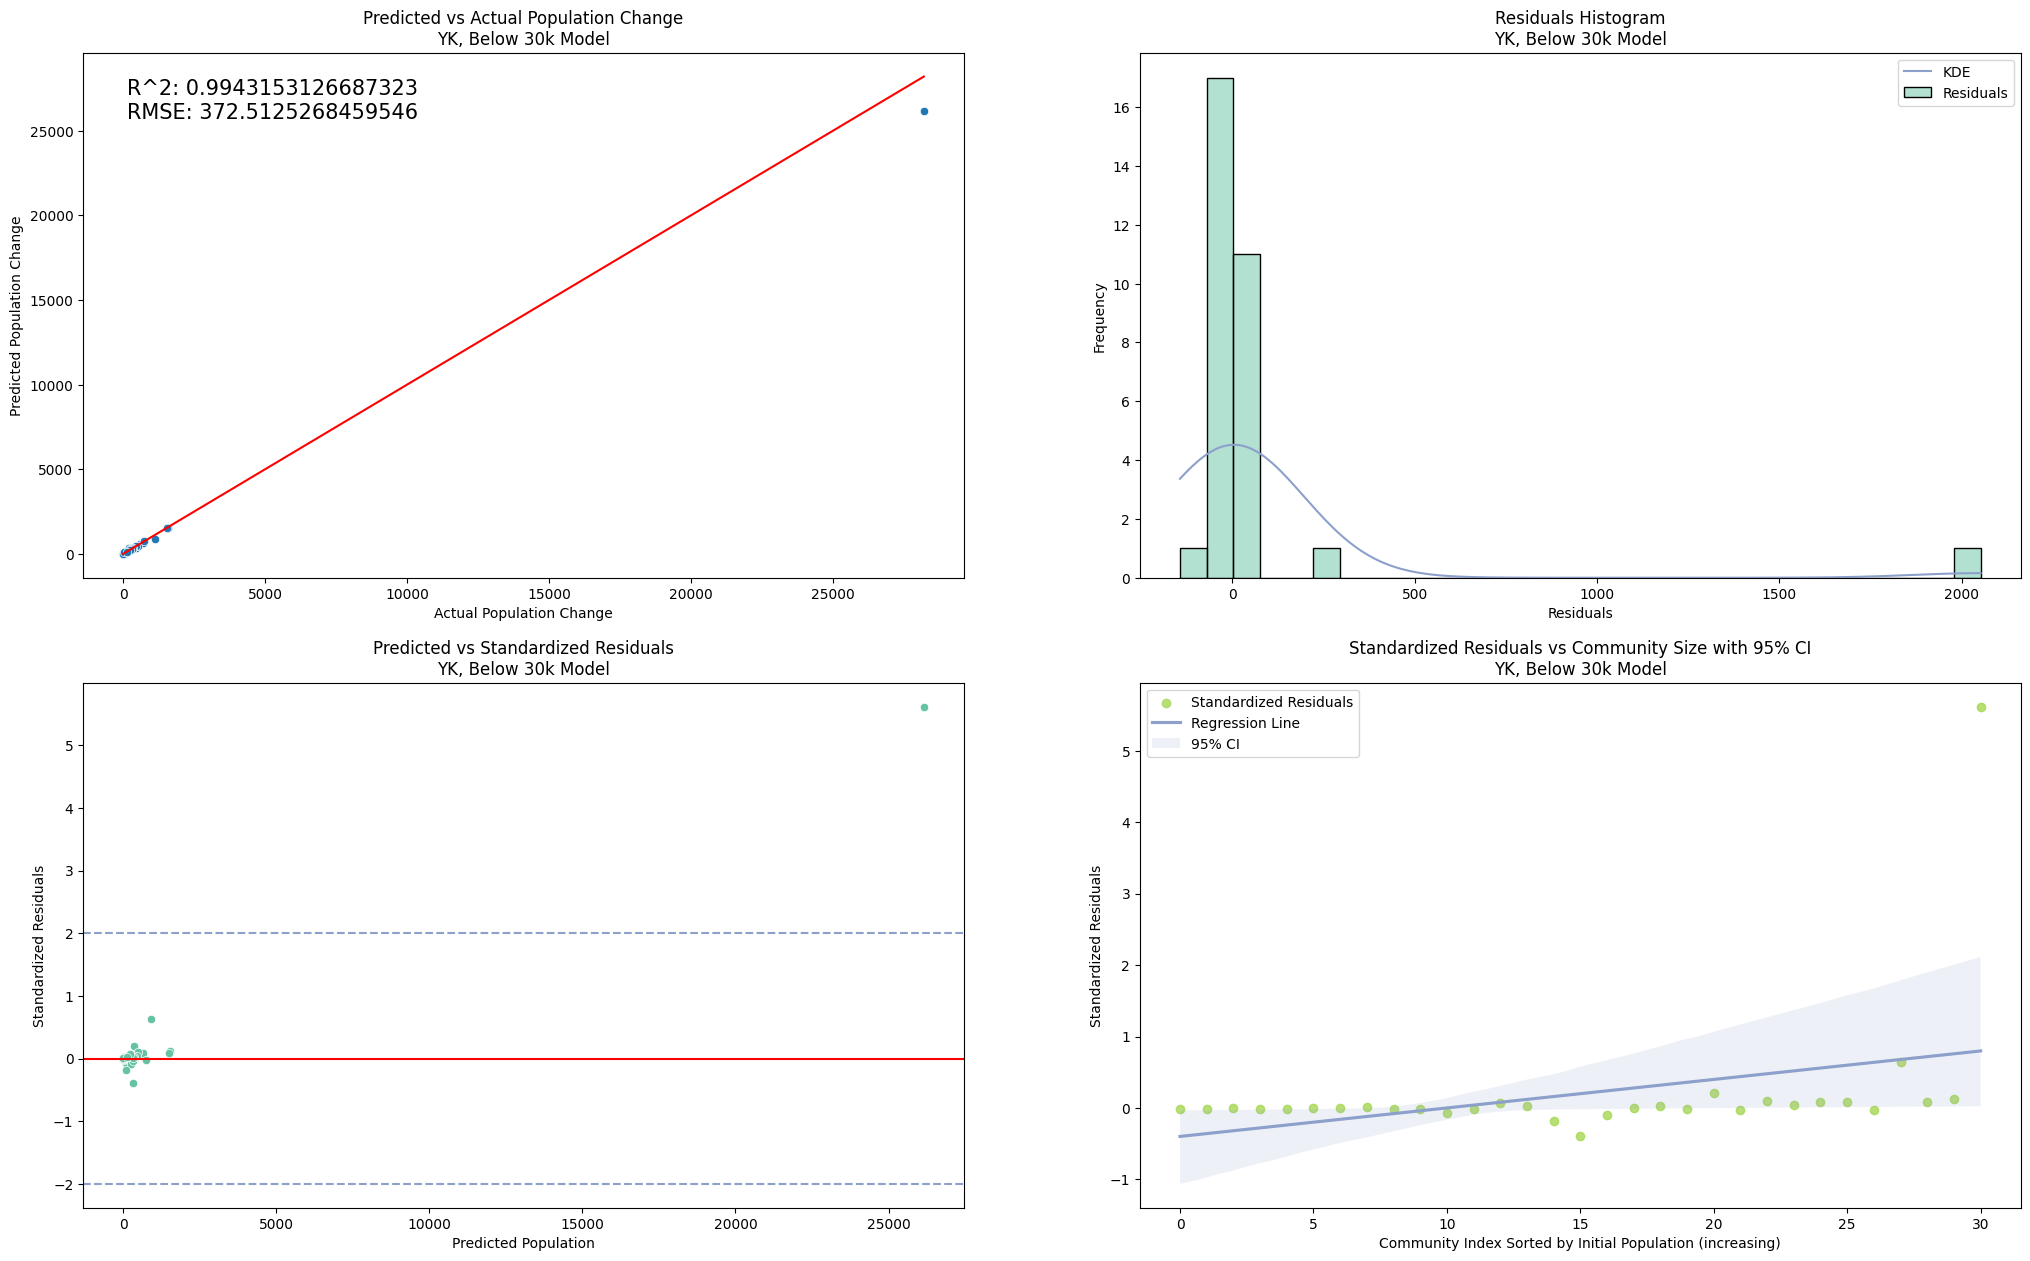

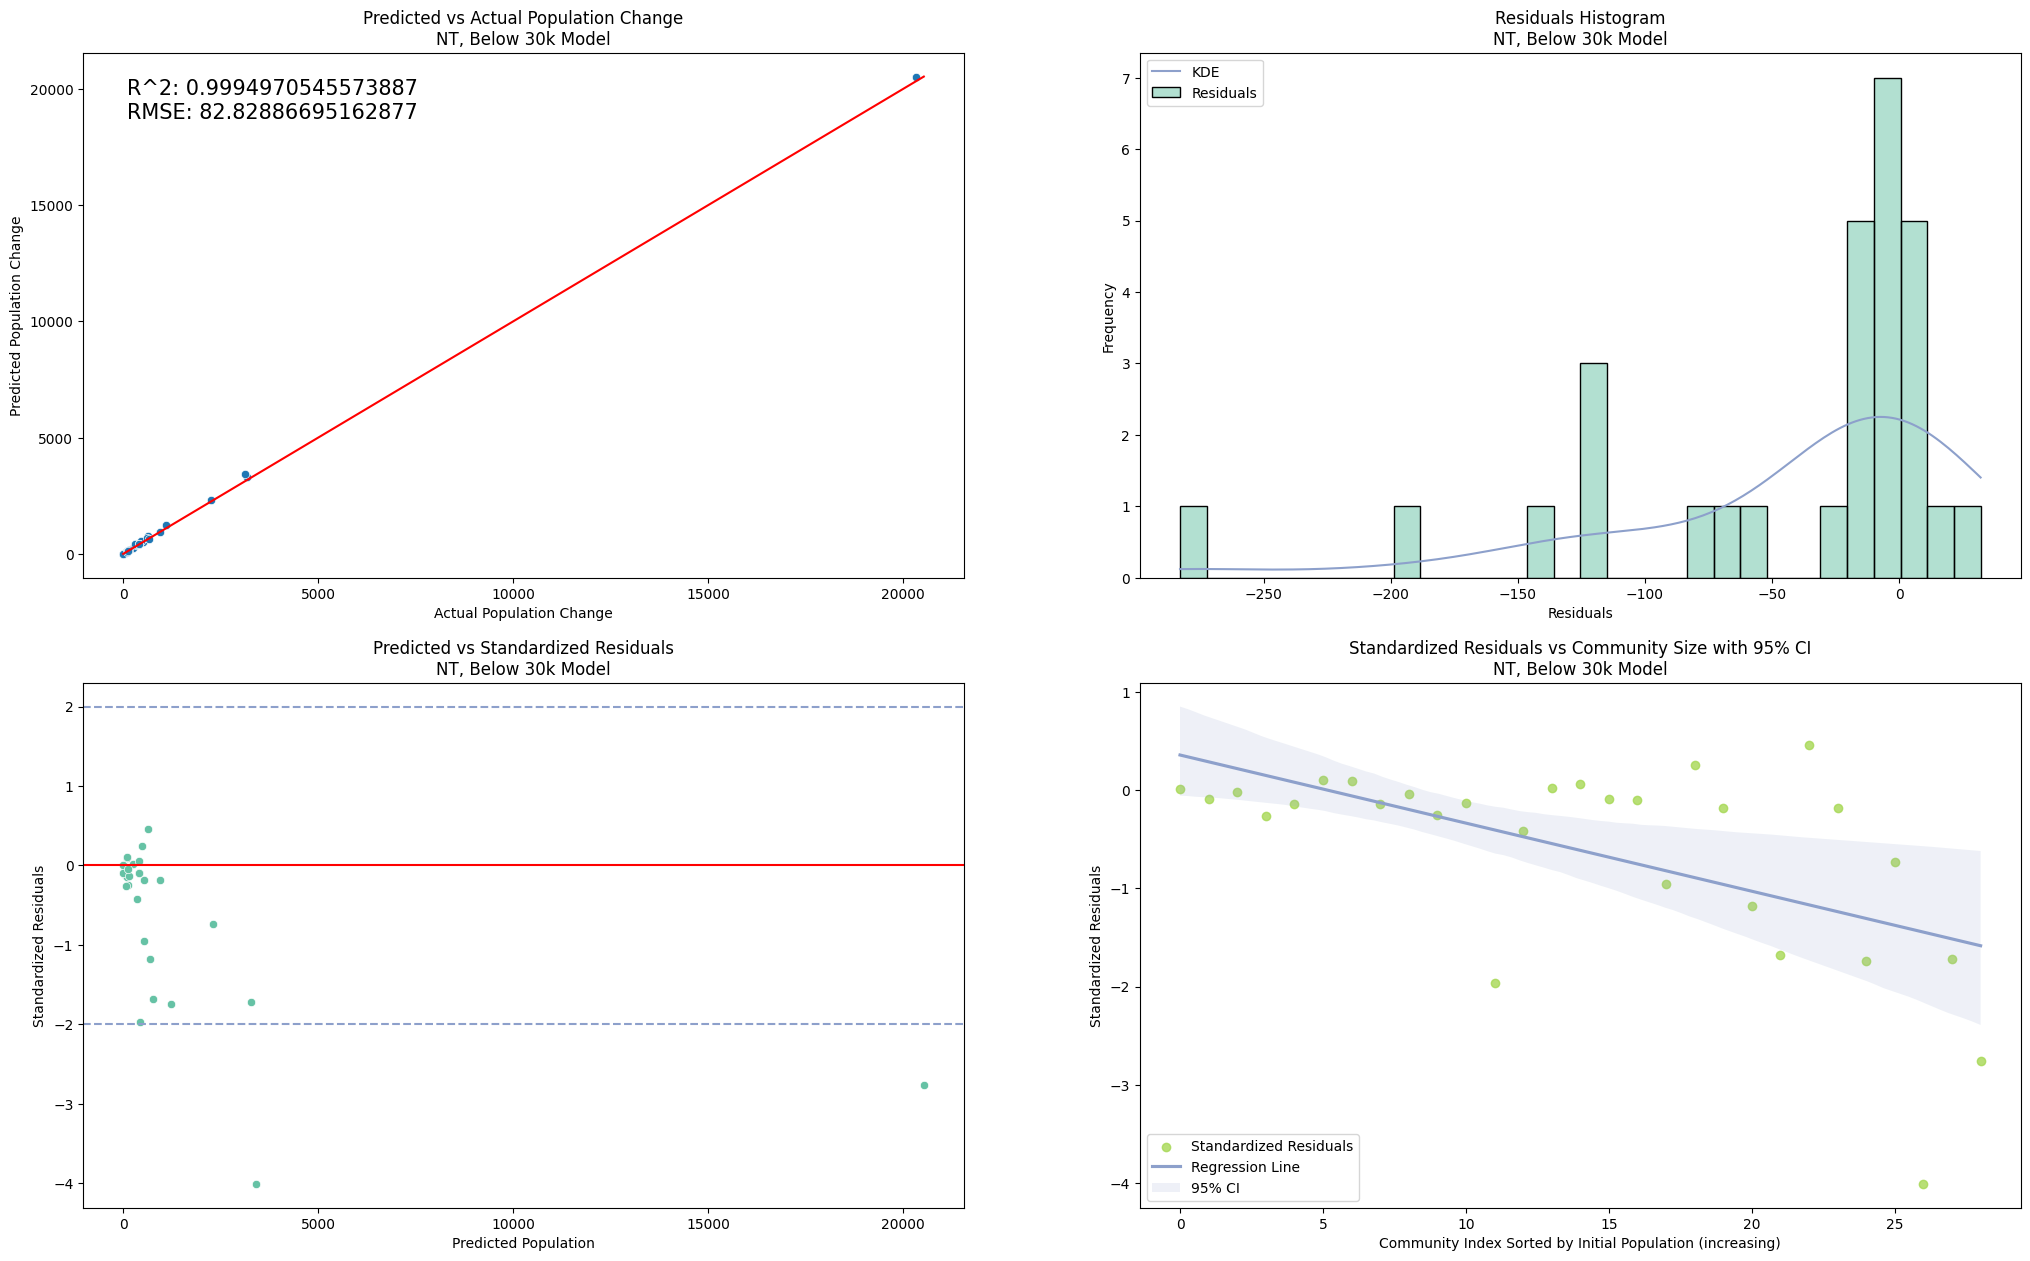

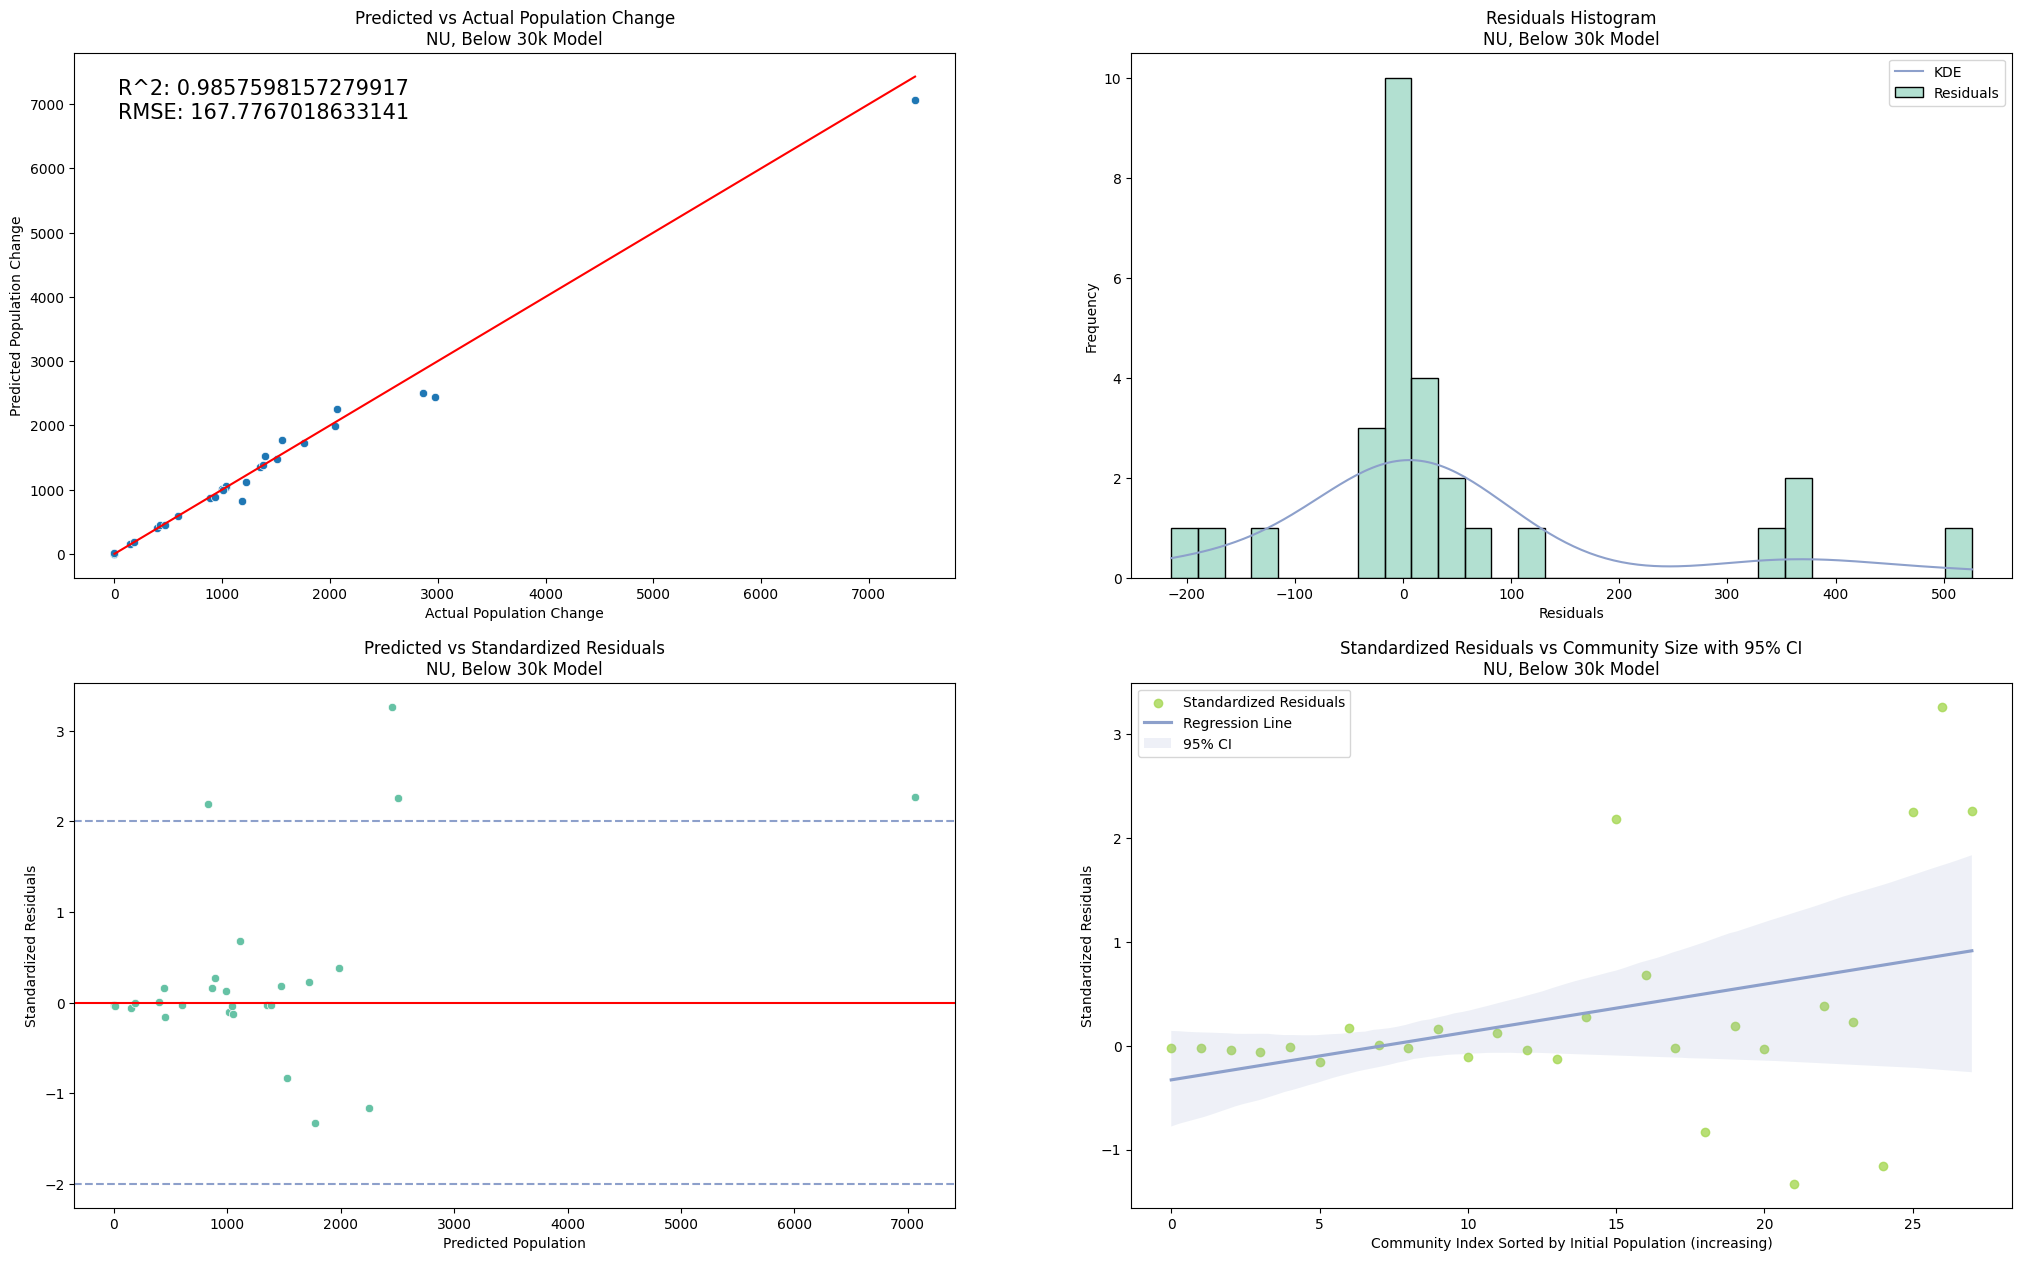

In [36]:
# One last time with the <30k model

below30k2016 = []

for entry in import2016:
    below30k2016.append({'name': entry['name'], 'data': entry['data'][entry['data']['Population, 2016'] < 30000]})
    

resultsBelow30k = predictProvinces(below30k2016, import2021, model = below30kModel)

visualizeResults(resultsBelow30k, dataLabel='Below 30k Model')

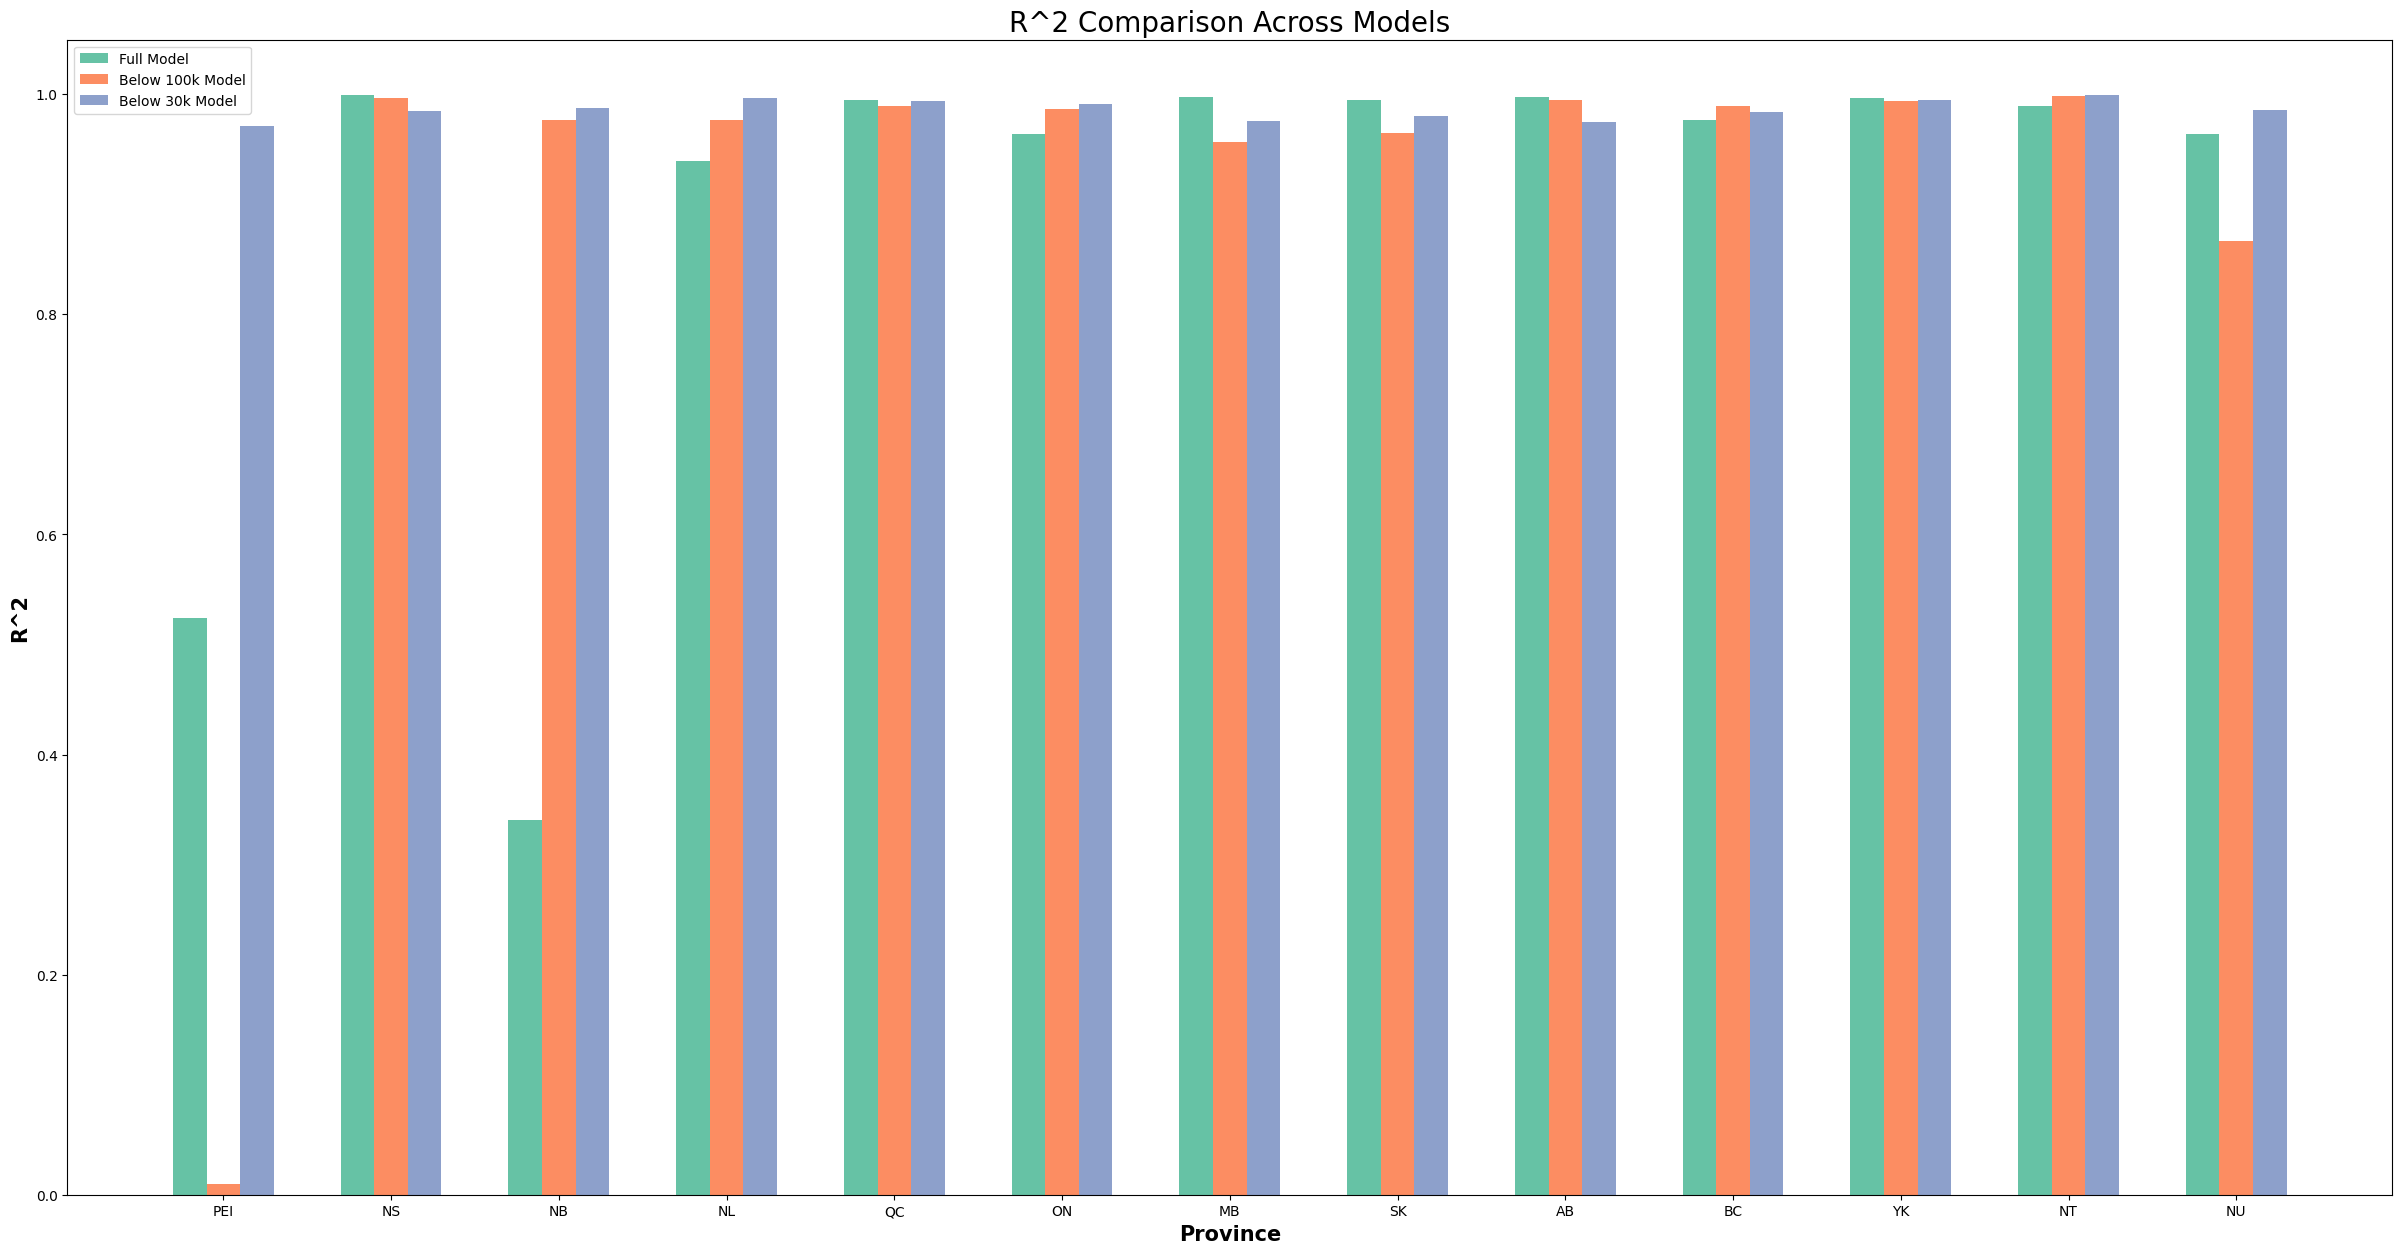

In [37]:
# One final graph to compare across provinces
# Let's plot a bar graph comparing the R^2 values for each province for each model

fig = plt.figure(figsize=(30, 15))
# We'll do a bar graph, with a color for each model
palette = sns.color_palette('Set2')

r2Full = [result['r2'] for result in results]
r2Below100k = [result['r2'] for result in resultsBelow100k]
r2Below30k = [result['r2'] for result in resultsBelow30k]

barWidth = 0.2
bar1 = np.arange(len(r2Full))
bar2 = [x + barWidth for x in bar1]
bar3 = [x + barWidth for x in bar2]

plt.bar(bar1, r2Full, color=palette[0], width=barWidth, label='Full Model')
plt.bar(bar2, r2Below100k, color=palette[1], width=barWidth, label='Below 100k Model')
plt.bar(bar3, r2Below30k, color=palette[2], width=barWidth, label='Below 30k Model')

plt.xlabel('Province', fontweight='bold', fontsize=15)
plt.ylabel('R^2', fontweight='bold', fontsize=15)
plt.title('R^2 Comparison Across Models', fontsize=20)
plt.xticks([r + barWidth for r in range(len(r2Full))], [result['name'] for result in results])
plt.legend()
plt.savefig('./figures/R2Comparison.png')





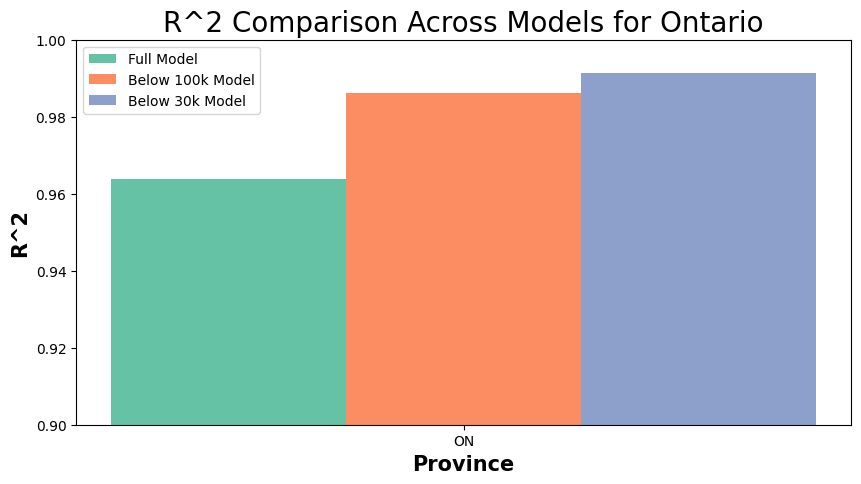

In [38]:
# For presentation purposes, we'll make that same graph for Ontario only

fig = plt.figure(figsize=(10, 5))
# We'll do a bar graph, with a color for each model
palette = sns.color_palette('Set2')

r2FullON = [result['r2'] for result in results if result['name'] == 'ON']
r2Below100kON = [result['r2'] for result in resultsBelow100k if result['name'] == 'ON']
r2Below30kON = [result['r2'] for result in resultsBelow30k if result['name'] == 'ON']

barWidth = 0.2
bar1 = np.arange(1)
bar2 = [x + barWidth for x in bar1]
bar3 = [x + barWidth for x in bar2]

plt.bar(bar1, r2FullON, color=palette[0], width=barWidth, label='Full Model')
plt.bar(bar2, r2Below100kON, color=palette[1], width=barWidth, label='Below 100k Model')
plt.bar(bar3, r2Below30kON, color=palette[2], width=barWidth, label='Below 30k Model')

plt.xlabel('Province', fontweight='bold', fontsize=15)
plt.ylabel('R^2', fontweight='bold', fontsize=15)
plt.title('R^2 Comparison Across Models for Ontario', fontsize=20)
plt.xticks([r + barWidth for r in range(1)], ['ON'])
plt.ylim(0.9, 1)
plt.legend()
plt.savefig('./figures/R2ComparisonON.png')
